# P6 Analysez les ventes d'une librairie avec R ou Python

## La société
    Lapage, une grande librairie généraliste en ligne
    -il est originellement une librairie physique avec plusieurs points de vente
    -il ouvrt un site de vente en ligne
    -il souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc

## Les demandes de l'entreprise
   -Analyser les ventes (partie 2 de plan d'analyse ci dessous)
   -Analyser les corrélations des variables (partie 3 de plan d'analyse ci dessous)

## Les outils mises en place par la société:
    3 tableaux CSV
    customers : identifiant, genre, date de naissance des client
    products: référence, prix, catégorie des produits
    transactions: données des ventes comme date de vente, id de session, client et prod concerné
    
## L'analyse va dérouler en 4 parties :
    1. Préparation des données
        - la compréhension des données 
        - la nettoyage des données et le rapprochement des 3 tableaux
        - la mise en forme des données (année,mois,âge)
        
    2. Une analyse des différents indicateurs de vente (différents indicateurs et graphiques autour du chiffre d'affaires)
        - l’évolution dans le temps
        - mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale
        - l'analyse des périodes baissières et pic
        - un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc
        - les profils de nos clients et la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz
        
    3. Une analyse plus ciblée sur les clients et comprendre le comportement de nos clients en ligne via certaines corrélations
        - le lien entre le genre d’un client et les catégories des livres achetés avec test CHI2
        - le lien entre l'âge des clients et le montant total d'achat, la fréquence d'achat, la taille du panier moyen et les catégoriés des livres achetés
            - la première vision des corrélations via heatmap
            - Tester les corrélations par groupe de 2 variables
                - Le lien entre l'âge des clients et le montant total des achats avec le nuage des points et le test pearson
                - Le lien entre l'âge des clients et la fréquence d’achat avec le nuage des points et le test pearson
                - Le lien entre l'âge des clients et la taille du panier moyen avec le nuage des points et le test pearson
                - Le lien entre l'âge des clients et les catégories des livres achetés avec le boîte mostache et le test anova
        
    4. Analyser le comportement des clients
        -La capacité d'attraction des nouveaux client
        -La risque de perte des clients
        -la taux de rétention des client en fonction de premier d'achat
        -Analyse avec algorithme RFM
        -Evolution de statu des clients inter-semestre.
       

In [1]:
#importer les outils python


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Eviter l'affichage des messages erreurs
import warnings
warnings.filterwarnings('ignore')



# Partie 1 Préparation des données

# 1.1 Intégrer les 3 tableaux csv dans la notebook 

In [2]:

customers=pd.read_csv('C:/Users/PF/Desktop/openclassroom/P6/DAN-P6-donnees/customers.csv',sep=',')
products=pd.read_csv('C:/Users/PF/Desktop/openclassroom/P6/DAN-P6-donnees/products.csv',sep=',')
transactions=pd.read_csv('C:/Users/PF/Desktop/openclassroom/P6/DAN-P6-donnees/transactions.csv',sep=',')

# 1.2 Comprendre les données

## 1.2.1 Comprendre Tableau transactions

### 1.2.1.1  Le tableau transactions a une dimension de 679532 lignes X 4 colonnes
    Liste des 4 colonnes de tableau transactions: ['id_prod', 'date', 'session_id', 'client_id']
    Temporairement, nous ne pouvons pas identifier le clés primaire de tableau transactions.

In [3]:
#Lire les 5 premières lignes de tableau transactions.
display(transactions.head())

#Imprimer la dimension de tableau transactions
print('La dimension de tableau transactions est :',transactions.shape)

#Imprimer le nombre des colonnes et les noms des colonnes de tableau transactions
print('Le tableau transactions contient',len(transactions.columns) ,'colonnes qui sont :',transactions.columns)

id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232

La dimension de tableau transactions est : (679532, 4)
Le tableau transactions contient 4 colonnes qui sont : Index(['id_prod', 'date', 'session_id', 'client_id'], dtype='object')


### 1.2.1.2 Il n'existe pas des valeurs vides dans le tableau transactions.
    Tous les colonnes sont avec 679532 lignes de données, donc il n'y a pas de case vide dans le tableaux transactions

In [4]:
#Affichier le type des données de chaque colonne et nombre de données par colonne.
display(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


None

### 1.2.1.3 Il existe les doublons dans toutes les colonnes de tableau transactions
    Le tableau transaction disposent 679532 lignes des données, mais le nombre des valeurs uniques des chaque colonne est inférieur à 679532

In [5]:
#Affichier le nombre des valeurs uniques de chaque colonne
transactions.nunique()

id_prod         3267
date          679371
session_id    342316
client_id       8602
dtype: int64

### 1.2.1.4 Comprendre les données doublons dans la colonne 'date' de tableau transactions
    -Les doublons de colonne date concerne id_prod T_0, client_id ct_0 et ct_1. 
    -Format de date commence avec 'test', il signifie que ces données sont susceptible d'être crées pour la raison de test de système par la société.

In [6]:
#Créer une dataframe date_check en selectionnant les lignes des données avec les dates en doublons.
date_check=transactions[transactions['date'].duplicated()]
#Ranger les données selon les informations des dates en ordre croissant
date_check.sort_values('date',inplace=True)
#Affichier les 10 premières lignes de dataframe date_check
display(date_check.head(10))

#Affichier la dimension de date_check
display(date_check.nunique())

#Vérifier le nombre des valeurs uniques de data_check
display(date_check.nunique())

print('*************************************')

#Affichier les valeurs uniques de chaque colonne de dataframe date_check
for i in date_check.columns:
    print(i,date_check[i].unique())

id_prod                             date session_id client_id
96687      T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
453857     T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
548383     T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
607892     T_0  test_2021-03-01 02:30:02.237412        s_0      ct_0
606326     T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
394969     T_0  test_2021-03-01 02:30:02.237413        s_0      ct_0
412584     T_0  test_2021-03-01 02:30:02.237413        s_0      ct_0
255856     T_0  test_2021-03-01 02:30:02.237413        s_0      ct_1
427604     T_0  test_2021-03-01 02:30:02.237413        s_0      ct_0
440821     T_0  test_2021-03-01 02:30:02.237413        s_0      ct_0

id_prod        1
date          37
session_id     1
client_id      2
dtype: int64

id_prod        1
date          37
session_id     1
client_id      2
dtype: int64

*************************************
id_prod ['T_0']
date ['test_2021-03-01 02:30:02.237412' 'test_2021-03-01 02:30:02.237413'
 'test_2021-03-01 02:30:02.237414' 'test_2021-03-01 02:30:02.237415'
 'test_2021-03-01 02:30:02.237416' 'test_2021-03-01 02:30:02.237417'
 'test_2021-03-01 02:30:02.237418' 'test_2021-03-01 02:30:02.237419'
 'test_2021-03-01 02:30:02.237420' 'test_2021-03-01 02:30:02.237421'
 'test_2021-03-01 02:30:02.237422' 'test_2021-03-01 02:30:02.237423'
 'test_2021-03-01 02:30:02.237424' 'test_2021-03-01 02:30:02.237425'
 'test_2021-03-01 02:30:02.237426' 'test_2021-03-01 02:30:02.237427'
 'test_2021-03-01 02:30:02.237428' 'test_2021-03-01 02:30:02.237429'
 'test_2021-03-01 02:30:02.237430' 'test_2021-03-01 02:30:02.237431'
 'test_2021-03-01 02:30:02.237432' 'test_2021-03-01 02:30:02.237433'
 'test_2021-03-01 02:30:02.237434' 'test_2021-03-01 02:30:02.237435'
 'test_2021-03-01 02:30:02.237436' 'test_2021-03-01 02:30:02.237437'
 'test_2021-03-01 02:30:02.237438' 'test_202

### 1.2.1.5 Comprendre les doublons dans la colonne 'session_id'
    -Créer la dateframe session_check en supprimant session_id = 's_0' dont ses données date commence avec 'test'
    
    -Après l'enlever les doublons dans la colonne date (session_id=s_0), on constate que durant une session 1 client effectue l'achat de plusieurs produits.
        Example:  au 01/03/2021, durant une session 's_100', le client 'C_3854' a acheté 2 produits '0_1030' et '0_1451'
    
    -A une date donnée, il pourra avoir plusieurs session_id.
    
    -chaque session_id concerne seulement 1  client_id.
    
    -Durant une session, le client pourra acheter plusieurs produits (id_prod).
    

In [7]:
#Créer dataframe session_check d'où session_id n'égale pas 's_0'
session_check=transactions[transactions.session_id!='s_0']
#Ranger les données selon session_id en ordre croissant
session_check.sort_values('session_id',inplace=True)
#Affichier les 20 premières lignes des données
display(session_check.head(20))

id_prod                        date session_id client_id
480642  0_1259  2021-03-01 00:01:07.843138        s_1     c_329
138915   1_635  2021-03-01 00:10:33.163037       s_10    c_2218
360110  0_1030  2021-03-01 04:12:43.572994      s_100    c_3854
578825  0_1451  2021-03-01 04:43:58.025677      s_100    c_3854
542757  0_1449  2021-03-03 03:18:58.492283     s_1000    c_1014
377843  0_1590  2021-03-03 02:49:03.169115     s_1000    c_1014
87809   0_1438  2021-03-03 03:25:12.320225     s_1000    c_1014
142862  0_1625  2021-03-03 02:38:09.568389     s_1000    c_1014
220006  0_1324  2021-03-22 17:58:20.634519    s_10000     c_476
345988  0_1418  2021-03-22 18:15:03.831240    s_10000     c_476
405617   1_395  2021-03-22 17:46:05.819130    s_10000     c_476
112227  0_1506  2021-10-04 18:49:57.033281   s_100000    c_6924
388932  0_2032  2021-10-04 19:27:50.709593   s_100003    c_8020
198762   0_385  2021-10-04 19:05:04.915134   s_100003    c_8020
552641  0_1160  2021-10-04 19:36:44.118781   s_100003    c_8020
426721   0_170  2021-10-04 19:24:47.782204   s_100004    c_3034
310075  0_1447  2021-10-04 19:05:42.371494   s_100005    c_1966
306246    0_39  2021-10-04 19:19:05.414742   s_100007    c_7695
393031  0_1192  2021-10-04 19:56:24.069857   s_100008    c_7896
625839  0_1239  2021-03-22 18:03:24.055279    s_10001    c_7022

### Goupby par session_id en vérifiant le valeur unique des client_id dans chaque session_id
    Quand on ranger le nombre des client_id de chaque session_id par l'ordre décroissant, la valuer maximume de nombre de client_id unique par session_id est 1.
    Donc on pourra dire que chaque session_id concerne seulement 1 seul client_id

In [8]:
#Groupby par session_id pour trouver le nombre de client_id unique de chaque session_id, puis ranger en ordre décroissant pour identifier la valeur maximume de nombre de client_id unique
session_check.groupby('session_id',as_index=False).client_id.nunique().sort_values('client_id',ascending=False).rename({'client_id':'Nombre client_id unique'},axis=1)

session_id  Nombre client_id unique
0             s_1                        1
228216   s_310042                        1
228214   s_310040                        1
228213    s_31004                        1
228212   s_310039                        1
...           ...                      ...
114104   s_205793                        1
114103   s_205792                        1
114102   s_205791                        1
114101   s_205790                        1
342314    s_99998                        1

[342315 rows x 2 columns]

## 1.2.2 Comprendre les données de Tableau customers

### 1.2.2.1 Le tableau customers contient 8623 lignes X 3 colonnes. 
    Les colonnes de tableau customers est : ['client_id', 'sex', 'birth']
    Le clés primaire de tableau customers est : client_id
    Via ce clés primaire, le tableau de transactions pourra récupérer l'information de sex et birth avec la méthode merge.

In [9]:
#Affichier les 5 premières lignes de customers
display(customers.head())

#Imprimer la dimension de customers
print('la dimension de tableau customers est :',customers.shape)

#Affichier le liste des noms des colonnes de customers
print('les colonnes de tableau customers est :',customers.columns)

client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

la dimension de tableau customers est : (8623, 3)
les colonnes de tableau customers est : Index(['client_id', 'sex', 'birth'], dtype='object')


### 1.2.2.2 Le tableau customers n'ont pas des valeurs vides dans toutes les colonnes.
    Chaque colonne contient 8623 unités des données qui est équivalent à nombre de ligne totale de tableau customers 

In [10]:
#Affichier le nombre de données par colonne
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


### 1.2.2.3 Le tableau customers contient 8623 client_id unique donc il n'y a pas de client_id en doublons. La colonne sex contient 2 valuers unique 'f' et 'm', et qu'il y a 76 valeurs uniques pour l'année de naissance du client.

In [11]:
#Affichier le valeur unique de chaque colonne de customers
customers.nunique()

client_id    8623
sex             2
birth          76
dtype: int64

### 1.2.2.4 Vérifier la format de client_id
    client_id de tableau customers est formaté en 'c_' + un 'chiffre numérique', mais il y a 2 valeurs ['ct_0', 'ct_1'] qui n'ont pas respecté ce régle.

In [12]:
#Créer 1 liste vide client_id_false pour stocker client_id non conforme à la format standard C_+ numéro
client_id_false=[]
#Créer boucle pour vérifier si chaque client_id commence avec 'c_'
for i in customers['client_id'].index:
    client_id_check=customers['client_id'][i].startswith('c_')
#Si 'client_id' ne commence pas avec 'c_', le stocker dans le liste client_id_false
    if client_id_check==False:
        client_id_false.append(customers['client_id'][i])
#Imprimer le liste client_id_false après le boucle pour identifier tous les client_id non conformes
print('Valeur client_id non conforme:',client_id_false)

#Nous avons trouver 2 client_id non conformes, affichier ces 2 client_id dans customers
display(customers[(customers['client_id']=='ct_0')|(customers['client_id']=='ct_1')])

Valeur client_id non conforme: ['ct_0', 'ct_1']


client_id sex  birth
2735      ct_0   f   2001
8494      ct_1   m   2001

### Ces 2 client_id non conformes ['ct_0', 'ct_1']  indiquent un seule id_prod T_0 et un seul session_id s_0 dans le tableau transactions.

In [13]:
#Vérifier l'état de client_id non conformes dans transactions pour identifier id_prod et session_id concernés dans transactions
display(transactions[(transactions['client_id']=='ct_0')|(transactions['client_id']=='ct_1')])

#Imprimer id_prod concerné dans transactions
print('2 client_id non conformes concernent id_prod',transactions[(transactions['client_id']=='ct_0')|(transactions['client_id']=='ct_1')].id_prod.unique())

#Imprimer session_id concerné dans transactions
print('2 client_id non conformes concernent session_id',transactions[(transactions['client_id']=='ct_0')|(transactions['client_id']=='ct_1')].session_id.unique())


id_prod                             date session_id client_id
3019       T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
5138       T_0  test_2021-03-01 02:30:02.237425        s_0      ct_0
9668       T_0  test_2021-03-01 02:30:02.237437        s_0      ct_1
10728      T_0  test_2021-03-01 02:30:02.237436        s_0      ct_0
15292      T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0
...        ...                              ...        ...       ...
657830     T_0  test_2021-03-01 02:30:02.237417        s_0      ct_0
662081     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1
670680     T_0  test_2021-03-01 02:30:02.237449        s_0      ct_1
671647     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1
679180     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1

[200 rows x 4 columns]

2 client_id non conformes concernent id_prod ['T_0']
2 client_id non conformes concernent session_id ['s_0']


## 1.2.3 Comprendre les données de Tableau products


### 1.2.3.1 Structure de tableau products 
    Tableau products contient 3287 lignes X 3 colonnes.
    Le clés primaire de products est : id_prod. (nombre des données uniques id_prod = nombre des données de colonne id_prod 3287)
    Via ce clés primaire, le tableau transaction pourra récupérer le prix et le catégorie de produits.

In [14]:
#Affichier les premières lignes de tableau products
display(products.head())

#Affichier la dimension de tableau products
print(products.shape)

#Affichier le liste des noms des colonnes de tableau products
print(products.columns)


id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0

(3287, 3)
Index(['id_prod', 'price', 'categ'], dtype='object')


### 1.2.3.2 id_prod de tableau products a 3287 valeurs uniques donc il n'existe pas des id_prod doublons.
    Ces id_prod sont séparé en 3 catégories'0','1' et '2'
    Le clés primaire id_prod est formaté en 'catégorie' + 'numéro', ex catégorie '0_' + '1421'

In [15]:
#Affichier le nombre des valeurs de chaque colonne
display(products.info())

#Affichier le nombre des valeur unique de chaque colonne
display(products.nunique())

#Affichier le valeur unique de colonne catégorie
display(products.categ.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


None

id_prod    3287
price      1455
categ         3
dtype: int64

array([0, 1, 2], dtype=int64)

In [16]:
#Affichier les produits dans les tableaux par catégorie pour vérifier la relation de catégorie et le numéro prod_id
display(products[products.categ==2].head())
display(products[products.categ==1].head())
display(products[products.categ==0].head())

id_prod   price  categ
10   2_228  225.17      2
38   2_100   72.11      2
64    2_89  107.99      2
73   2_225  157.99      2
79   2_187  157.99      2

id_prod  price  categ
3    1_587   4.99      1
6    1_463  36.99      1
11   1_178  51.92      1
12   1_143   9.99      1
13   1_314   9.00      1

id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
4  0_1507   3.99      0
5  0_1163   9.99      0

### 1.2.3.3 Vérifier le valeur abérrante de colonne 'price'
    un prix -1.0 est identifié comme la valeur abérrante dans le tableau products qui nous s'oriente vers l'id_prod T_0, qui n'a pas respecté la format de id_prod non plus

In [17]:
#Affichier s'il y a le produit avec un prix égale ou inférieur à 0
products[products.price<=0]

id_prod  price  categ
731     T_0   -1.0      0

### 1.2.3.4 Vérifier le format de prod_id 
    un id_prod 'T_0' est la seule id_prod avec un format non conforme dans le tableau products.

In [18]:
#Créer liste vide prod_id_false
prod_id_false=[]

#Créer boucle pour identifier les id_prod commence avec 0_, 1_ ou 2_
for i in products['id_prod'].index:
    prod_id_check=products['id_prod'][i].startswith('0_')
    if prod_id_check==False:
        prod_id_check=products['id_prod'][i].startswith('1_')
        if prod_id_check==False:
            prod_id_check=products['id_prod'][i].startswith('2_')
#Si prod_id ne commence pas avec 0_, 1_ ou 2_, le stocker dans le liste prod_id_false en considèrant qu'il est non conforme à la format id_prod
            if prod_id_check==False:
                prod_id_false.append(products['id_prod'][i])
prod_id_false

['T_0']

### 1.2.3.5 Vérifier id_prod T_0 dans transactions
    Le id_prod T_0 concerne 2 valeurs client_id ct_0 et ct_1 et 1 valeur session_id s_0 dans le tableau de transaction

In [19]:
#Vérifier dans transactions, les clients_id concernés par id_prod T_0
print(transactions[transactions['id_prod']=='T_0'].client_id.unique())

#Vérifier dans transactions, les session_id concernés par id_prod T_0
print(transactions[transactions['id_prod']=='T_0'].session_id.unique())

['ct_0' 'ct_1']
['s_0']


### 1.2.4 Conclusion de la compréhension des données de 3 tableaux
    -Dans tableau customers, on identifie 2 valeurs client_id non conforme ['ct_0' 'ct_1'], qui nous s'oriente vers session_id s_0 de tableau transactions.
    
    -Dans tableau products, on identifie id_prod T_0 qui non conforme en format et avec un prix abérrant, qui nous s'oriente également vers session_id s_0 de tableau transactions.
    
    -Quand on selectionne session_id s_0 dans le tableau transactions, il indique seulement les client_id ['ct_0' 'ct_1'] et id_prod T_0
    
    Donc, on pourra conclure que les données abérrantes des 3 tableaux concernant seulement session_id s_0

In [20]:
#Vérifier client_id concernés par session_id s_0 dans transactions
print(transactions[transactions['session_id']=='s_0'].client_id.unique())
#Vérifier id_prod concernés par session_id s_0 dans transactions
print(transactions[transactions['session_id']=='s_0'].id_prod.unique())

['ct_0' 'ct_1']
['T_0']


## 1.3 Nettoyage des données et rapprocher les 3 tableaux products, customers, transactions

### 1.3.1 Supprimer de session_id s_0 dans le tableau de transactions et récupérer les informations des tableaux products et customers

In [21]:
#Supprimer session_id s_0 dans transactions qui est identifié comme les valeurs abérrantes
transactions=transactions[transactions['session_id']!='s_0']

#Dans transactions récupérer le prix et le catégorie de tableau products via le clés id_prod
transactions=pd.merge(transactions,products,how='left',on='id_prod')

#Dans transactions récupérer le sex et l'année de naissance de client de tableau customers via le clés client_id
transactions=pd.merge(transactions,customers,how='left',on='client_id')

#Affichier le tableau transactions après la récupération des données de customers et products
display(transactions.head())

id_prod                        date session_id client_id  price  categ sex  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534  15.99    1.0   m   
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714   7.99    0.0   f   
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941  69.99    2.0   m   
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232   4.99    0.0   m   

   birth  
0   1986  
1   1988  
2   1968  
3   2000  
4   1980

### 1.3.2 Après le merge des 3 tableaux dans le tableau de transaction, on a trouvé 221 valeurs vides dans la colonne price et categ
    Ces valeurs vides concernent un seule id_prod  ['0_2245']

### On trouve 221 lignes avec prix et categorie vide. 
### On comprend qu'il s'agit un id_prod connu de transations mais pas connu de products.

In [22]:
#Vérifier les valeurs vides de transactions
display(transactions.info())
#Affichier le nombre des valeurs vides de transactions
display(transactions.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679332 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679332 non-null  object 
 3   client_id   679332 non-null  object 
 4   price       679111 non-null  float64
 5   categ       679111 non-null  float64
 6   sex         679332 non-null  object 
 7   birth       679332 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 46.6+ MB


None

id_prod         0
date            0
session_id      0
client_id       0
price         221
categ         221
sex             0
birth           0
dtype: int64

### On trouve 0_2245 est le seul id_prod concerné par le prix et catégorie vide

In [23]:
#Affichier les données de transations quand price est vide
display(transactions[transactions.price.isna()==True])
#Affichier le id_prod de transations concerné par le prix et le catégorie vide
print(transactions[transactions.price.isna()==True].id_prod.unique())

id_prod                        date session_id client_id  price  categ  \
2633    0_2245  2022-09-23 07:22:38.636773   s_272266    c_4746    NaN    NaN   
10103   0_2245  2022-07-23 09:24:14.133889   s_242482    c_6713    NaN    NaN   
11723   0_2245  2022-12-03 03:26:35.696673   s_306338    c_5108    NaN    NaN   
15670   0_2245  2021-08-16 11:33:25.481411    s_76493    c_1391    NaN    NaN   
16372   0_2245  2022-07-16 05:53:01.627491   s_239078    c_7954    NaN    NaN   
...        ...                         ...        ...       ...    ...    ...   
669533  0_2245  2021-08-25 09:06:03.504061    s_80395     c_131    NaN    NaN   
670484  0_2245  2022-03-06 19:59:19.462288   s_175311    c_4167    NaN    NaN   
671088  0_2245  2022-05-16 11:35:20.319501   s_209381    c_4453    NaN    NaN   
675480  0_2245  2022-02-11 09:05:43.952857   s_163405    c_1098    NaN    NaN   
677797  0_2245  2021-12-14 22:34:54.589921   s_134446    c_4854    NaN    NaN   

       sex  birth  
2633     m   1940  
10103    f   1963  
11723    m   1978  
15670    m   1991  
16372    m   1973  
...     ..    ...  
669533   m   1981  
670484   f   1979  
671088   m   1981  
675480   m   1986  
677797   m   1968  

[221 rows x 8 columns]

['0_2245']


### 1.3.3 remplir les cases vides de transactions 
    l'id_prod 0_2245 commence par '0_', nous savons qu'il s'agit de catégorie '0', 
    donc nous pouvons donner le prix moyenne de catégorie '0' à ce id_prod 0_2245.

In [24]:
#Calculer le prix moyenne des produits de catégorie 0
avg_price_cat0=round(transactions[transactions.categ==0].price.mean(),2)

#Remplir le prix de 0_2245 avec le prix moyenne de son catégorie
transactions.loc[(transactions.price.isna()==True),'price']=avg_price_cat0

#Remplir le catégorie de 0_2245 avec catégorie 0
transactions.loc[(transactions.categ.isna()==True),'categ']=0.0

#Vérifier la résultat de remplissage de id_prod 0_2245
display(transactions[transactions.id_prod=='0_2245'])


#Vérifier s'il existe encore les cases vide après le traitement de id_prod 0_2245
transactions.info()

id_prod                        date session_id client_id  price  categ  \
2633    0_2245  2022-09-23 07:22:38.636773   s_272266    c_4746  10.64    0.0   
10103   0_2245  2022-07-23 09:24:14.133889   s_242482    c_6713  10.64    0.0   
11723   0_2245  2022-12-03 03:26:35.696673   s_306338    c_5108  10.64    0.0   
15670   0_2245  2021-08-16 11:33:25.481411    s_76493    c_1391  10.64    0.0   
16372   0_2245  2022-07-16 05:53:01.627491   s_239078    c_7954  10.64    0.0   
...        ...                         ...        ...       ...    ...    ...   
669533  0_2245  2021-08-25 09:06:03.504061    s_80395     c_131  10.64    0.0   
670484  0_2245  2022-03-06 19:59:19.462288   s_175311    c_4167  10.64    0.0   
671088  0_2245  2022-05-16 11:35:20.319501   s_209381    c_4453  10.64    0.0   
675480  0_2245  2022-02-11 09:05:43.952857   s_163405    c_1098  10.64    0.0   
677797  0_2245  2021-12-14 22:34:54.589921   s_134446    c_4854  10.64    0.0   

       sex  birth  
2633     m   1940  
10103    f   1963  
11723    m   1978  
15670    m   1991  
16372    m   1973  
...     ..    ...  
669533   m   1981  
670484   f   1979  
671088   m   1981  
675480   m   1986  
677797   m   1968  

[221 rows x 8 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679332 entries, 0 to 679331
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679332 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679332 non-null  object 
 3   client_id   679332 non-null  object 
 4   price       679332 non-null  float64
 5   categ       679332 non-null  float64
 6   sex         679332 non-null  object 
 7   birth       679332 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 46.6+ MB


## 1.4 Ajouter l'âge, retransformer les données de date dans le tableau transactions

In [25]:
#Récupérer les 11 premières lettres de colonne date comme la date de transation
transactions['transaction_date'] = pd.to_datetime(transactions['date'].str.slice(0,11))

#Calculer l'age de client de chaque ligne
transactions['age']=2023-transactions.birth

#Ajouter l'année selon la date de transaction identifié
transactions['year']=transactions['transaction_date'].dt.year

#Ajouter mois selon la date de transaction identifié
transactions['month']=transactions['transaction_date'].dt.month

#Vérifier le résultat après l'ajout des colonnes date de transaction, année, mois, age du client
transactions.head()

id_prod                        date session_id client_id  price  categ sex  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534  15.99    1.0   m   
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714   7.99    0.0   f   
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941  69.99    2.0   m   
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232   4.99    0.0   m   

   birth transaction_date  age  year  month  
0   1986       2022-05-20   37  2022      5  
1   1988       2022-02-02   35  2022      2  
2   1968       2022-06-18   55  2022      6  
3   2000       2021-06-24   23  2021      6  
4   1980       2023-01-11   43  2023      1

# Partie 2 Une analyse des différents indicateurs de vente

# 1.le chiffre d'affaire à l'évolution du temps

## 1.1 Construire le dataframe CA_jour pour trouver le chiffre d'affaire par transaction_date

In [26]:
#Créer dataframe CA_jour et calculer le CA par transaction_date avec la méthode groupby sur le tableau transactions
CA_jour=transactions.groupby('transaction_date',as_index=False)['price'].sum().rename({'price':'CAjour'},axis=1)
#Affichier le tableau CA_jour
CA_jour.head()

transaction_date    CAjour
0       2021-03-01  16575.86
1       2021-03-02  15497.09
2       2021-03-03  15198.69
3       2021-03-04  15196.07
4       2021-03-05  17471.37

## 1.2 Vérifier l'échelle de transaction_date de CA_jour avec un tableau du temps intermédiaire
    Créer df_Date avec l'échelle de date calendaire pour vérifier s'il y a les dates manquantes dans CA_jour.
    On trouve qu'il n'y a pas de transaction_date manquante dans le tableau CA_jour.

In [27]:
#définir la date début et la date fin des dates calendaire pour df_Date
start_date=min(CA_jour.transaction_date)
end_date=max(CA_jour.transaction_date)

#Import datetime et timedelta
from datetime import datetime, timedelta

#définir timedelta = 1 jour
day=timedelta(1)

#Définir df_Date commence par la date début
df_Date = [start_date]

#Ajouter les nouvelles dates dans df_Date jusqu'à la date fin
for date in df_Date:
    if date < end_date:
        date=max(df_Date)+day
        df_Date.append(date)
print(len(df_Date),df_Date[:5])

#Construire la dataFrame df_Date avec les dates calendaires générées
df_Date=pd.DataFrame(df_Date)

#renommer la colonne de df_Date
df_Date=df_Date.rename({0:'transaction_date'},axis=1)

#Affichier tableau df_Date
display(df_Date.head())

#Affichier date début et date fin de df_Date
print('date fin de df_Date',df_Date.transaction_date.max())
print('date début de df_Date',df_Date.transaction_date.min())

730 [Timestamp('2021-03-01 00:00:00'), Timestamp('2021-03-02 00:00:00'), Timestamp('2021-03-03 00:00:00'), Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-05 00:00:00')]


transaction_date
0       2021-03-01
1       2021-03-02
2       2021-03-03
3       2021-03-04
4       2021-03-05

date fin de df_Date 2023-02-28 00:00:00
date début de df_Date 2021-03-01 00:00:00


#### Dans df_Date, on récupère CA de CA_jour avec le clés transaction_date.
#### Comme il n'y a pas des données manquantes dans le CA de df_Date, nous pouvons dire que CA_jour a une échelle de date calendaire complete.

In [28]:
df_Date=pd.merge(df_Date,CA_jour,how='left',on='transaction_date')
display(df_Date.head())
display(df_Date.isna().sum())

transaction_date    CAjour
0       2021-03-01  16575.86
1       2021-03-02  15497.09
2       2021-03-03  15198.69
3       2021-03-04  15196.07
4       2021-03-05  17471.37

transaction_date    0
CAjour              0
dtype: int64

## 1.3 Affichier le chiffre d'affaire à l'évolution de jour de transaction par graphique

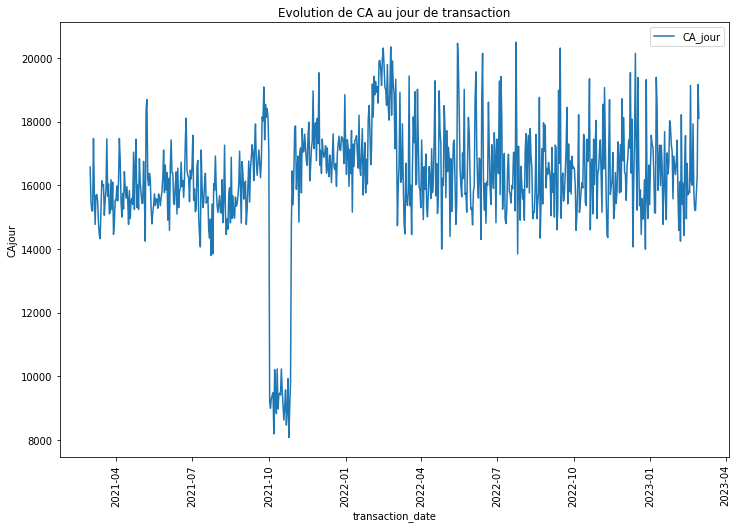

In [29]:

plt.figure(figsize=(12,8))
sns.lineplot(x='transaction_date',y='CAjour',data=CA_jour,label='CA_jour')
plt.xticks(rotation=90)
plt.title('Evolution de CA au jour de transaction')
plt.show()

# 2. Mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale

## 2.1 Calculer le CA moyenne de 7 jours(1 semaine), 14 jours(2 semaines), et 21 jours(3 semaines) en ajoutant dans le tableau CA_jour

In [30]:
#Créer colonne CAm7 pour CA moyenne de 7 jour
CA_jour['CAm7']=CA_jour['CAjour'].rolling(7).mean()
#Créer colonne CAm14 pour CA moyenne de 14 jour
CA_jour['CAm14']=CA_jour['CAjour'].rolling(14).mean()
#Créer colonne CAm21 pour CA moyenne de 21 jour
CA_jour['CAm21']=CA_jour['CAjour'].rolling(21).mean()
#Affichier le résultat
CA_jour.head()

transaction_date    CAjour  CAm7  CAm14  CAm21
0       2021-03-01  16575.86   NaN    NaN    NaN
1       2021-03-02  15497.09   NaN    NaN    NaN
2       2021-03-03  15198.69   NaN    NaN    NaN
3       2021-03-04  15196.07   NaN    NaN    NaN
4       2021-03-05  17471.37   NaN    NaN    NaN

## 2.2 Afficher CA moyenne de 1 semaine, 2 semaines, 3 semaines dans un graphique

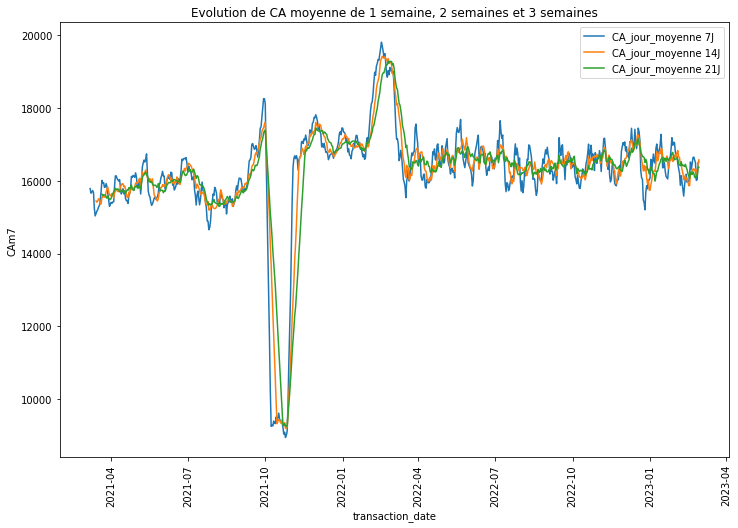

In [31]:

plt.figure(figsize=(12,8))
sns.lineplot('transaction_date','CAm7',ci=None,data=CA_jour,label='CA_jour_moyenne 7J')
sns.lineplot('transaction_date','CAm14',ci=None,data=CA_jour,label='CA_jour_moyenne 14J')
sns.lineplot('transaction_date','CAm21',ci=None,data=CA_jour,label='CA_jour_moyenne 21J')
plt.xticks(rotation=90)
plt.title('Evolution de CA moyenne de 1 semaine, 2 semaines et 3 semaines')
plt.show()

# 3. Analyse de la période baissière et pic de CA
    Nous trouvons qu'il y a une période baissière en octobre 2021 et une période de pic en février 2022 dans CA à l'évolution du temps.
    Nous rentrons en détail ces 2 périodes pour identifier les causes de la baisse et hausse.

## 3.1 Zoomer CA en baisse pendant la période entre 2021-09-30 et 2021-10-29 et CA en hausse pendant la période entre 2022-01-27 et 2022-03-05

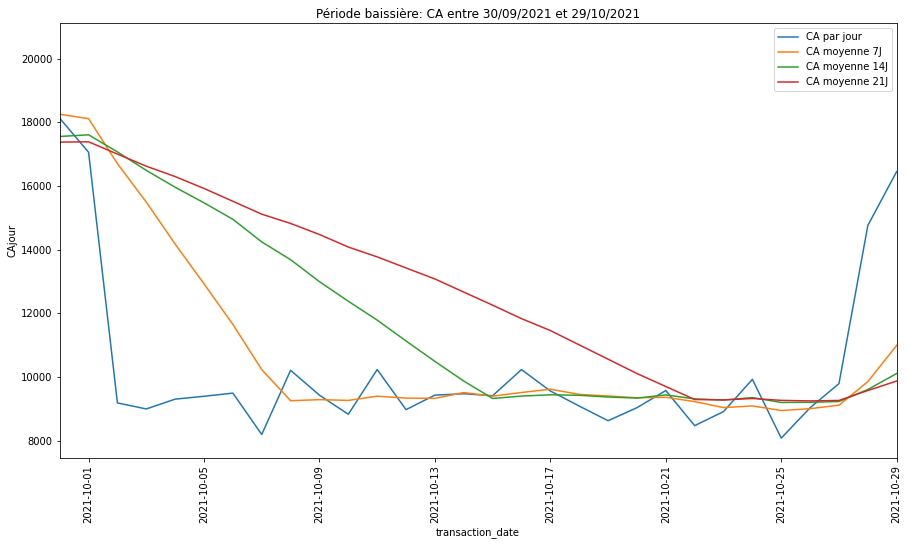

In [32]:
import datetime
plt.figure(figsize=(15,8))
sns.lineplot(x='transaction_date',y='CAjour',data=CA_jour,label='CA par jour')
sns.lineplot('transaction_date','CAm7',ci=None,data=CA_jour,label='CA moyenne 7J')
sns.lineplot('transaction_date','CAm14',ci=None,data=CA_jour,label='CA moyenne 14J')
sns.lineplot('transaction_date','CAm21',ci=None,data=CA_jour,label='CA moyenne 21J')
plt.xlim([datetime.date(2021,9,30),datetime.date(2021,10,29)])
plt.xticks(rotation=90)
plt.title('Période baissière: CA entre 30/09/2021 et 29/10/2021')
plt.legend()

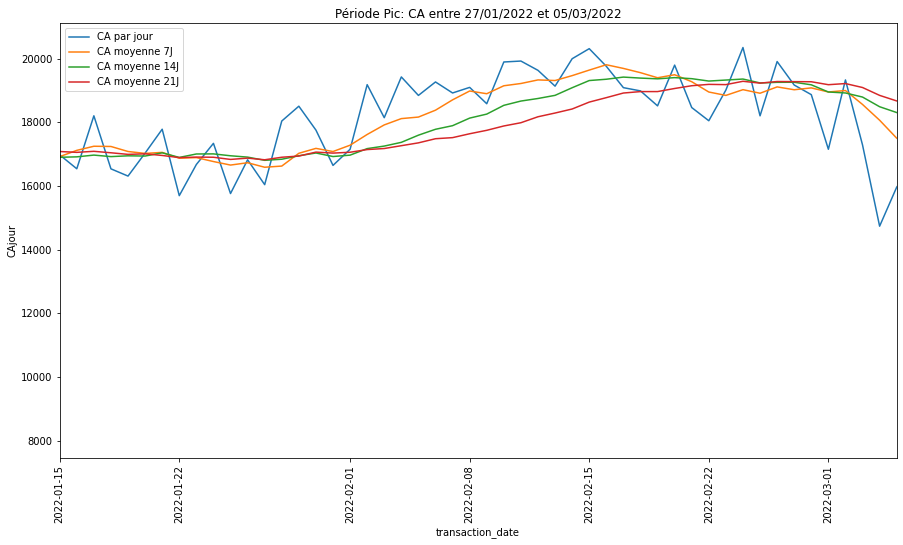

In [33]:
import datetime
plt.figure(figsize=(15,8))
sns.lineplot(x='transaction_date',y='CAjour',data=CA_jour,label='CA par jour')
sns.lineplot('transaction_date','CAm7',ci=None,data=CA_jour,label='CA moyenne 7J')
sns.lineplot('transaction_date','CAm14',ci=None,data=CA_jour,label='CA moyenne 14J')
sns.lineplot('transaction_date','CAm21',ci=None,data=CA_jour,label='CA moyenne 21J')
plt.xlim([datetime.date(2022,1,15),datetime.date(2022,3,5)])
plt.xticks(rotation=90)
plt.title('Période Pic: CA entre 27/01/2022 et 05/03/2022')
plt.legend()

## 3.2 Analyser la cause de la baisse et la hause de CA

### 3.2.1 Analyser CA selon genre des clients
    CA femme et CA homme ont suivi la même tendance de la baisse et de la hause que CA total, donc il n'ont pas impacté le CA pendant octobre 2021 et février 2022

In [34]:
#Créer le tableau  CA_jour_sex basé sur transaction
CA_jour_sex=transactions.groupby(['sex','transaction_date'],as_index=False)['price'].sum().rename({'price':'CAjour'},axis=1)

#Construire le tableau CA_jour_sex_femme et CA_jour_sex_homme en selectionant le sex de tableau CA_jour_sex
CA_jour_sex_femme=CA_jour_sex[CA_jour_sex.sex=='f'].rename({'CAjour':'CAjour_femme'},axis=1)
CA_jour_sex_homme=CA_jour_sex[CA_jour_sex.sex=='m'].rename({'CAjour':'CAjour_homme'},axis=1)

#Relier le tableau CA_jour_sex_femme et CA_jour_sex_homme dans un tableau CA_jour_sex_pivot (éviter les dates manquantes en cas de 2 tableaux séparé)
CA_jour_sex_pivot=pd.merge(CA_jour_sex_femme,CA_jour_sex_homme,how='outer',on='transaction_date')
CA_jour_sex_pivot=CA_jour_sex_pivot.drop(['sex_x','sex_y'],axis=1)
display(CA_jour_sex.head(),CA_jour_sex_pivot.head(),CA_jour_sex_pivot.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  730 non-null    datetime64[ns]
 1   CAjour_femme      730 non-null    float64       
 2   CAjour_homme      730 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 22.8 KB


sex transaction_date   CAjour
0   f       2021-03-01  7897.55
1   f       2021-03-02  8877.50
2   f       2021-03-03  7610.39
3   f       2021-03-04  6844.55
4   f       2021-03-05  8582.10

transaction_date  CAjour_femme  CAjour_homme
0       2021-03-01       7897.55       8678.31
1       2021-03-02       8877.50       6619.59
2       2021-03-03       7610.39       7588.30
3       2021-03-04       6844.55       8351.52
4       2021-03-05       8582.10       8889.27

None

### Affichier le CA par genre de client dans un graphique
    CA de femme et CA de homme ont suivi complétement la même tendance que le CA total pendant la période baissière et pic, donc nous pouvons dire que le genre de client n'a pas de lien avec ces 2 périodes.

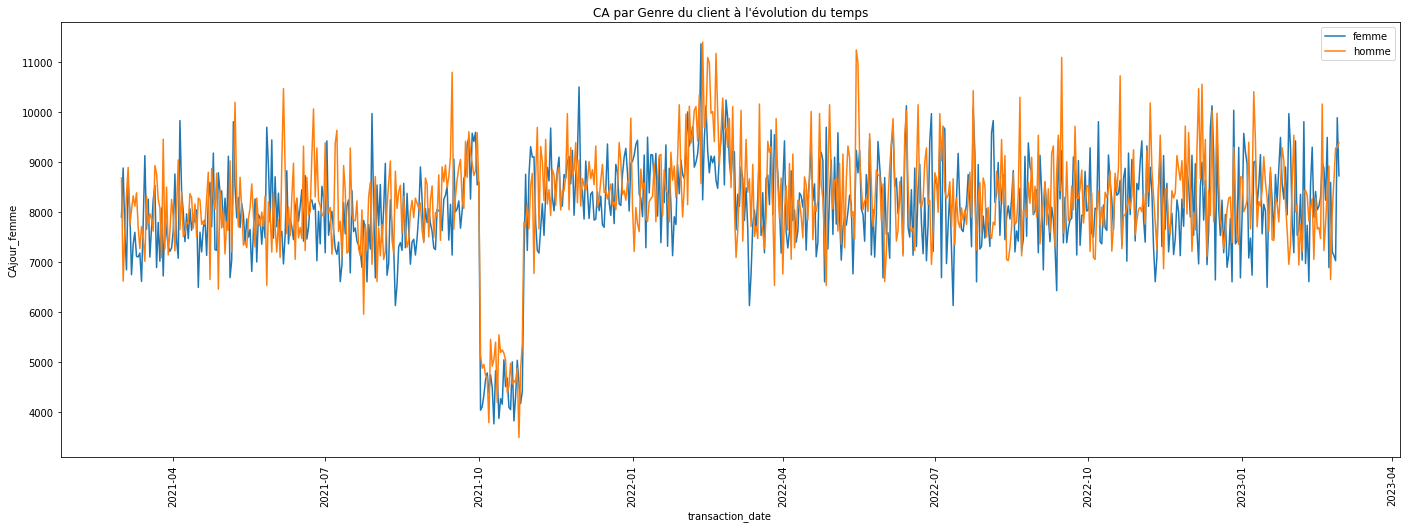

In [35]:
plt.figure(figsize=(24,8))
sns.lineplot(x='transaction_date',y='CAjour_femme',data=CA_jour_sex_pivot,label='femme')
sns.lineplot(x='transaction_date',y='CAjour_homme',data=CA_jour_sex_pivot,label='homme')
plt.title('CA par Genre du client à l\'évolution du temps')

plt.xticks(rotation=90)
plt.legend()
plt.show()

### 3.2.2 Analyser l'évolution de CA par catégorié des produits
    
    On identifie via le graphique l'évolution de CA est bien liés à l'évolution de CA de 3 catégories de produit.
    
    Causes de Période baissière:
        Catégorie 1: Il y a les données CA manquantes entre 02/10/2021 et 28/10/2021
        Catégorie 0 et Catégorie 2: une baisse pendant cette période par rapport à la période Juillet/Août 2021
    
    Causes de Période pic:
        Catégorie 1: Les données CA de catégorié 1 sont reintégrées à partir de 28/10/2021 avec un niveau supérieur à la période précédante.
        Catégorie 2: Retourner au niveau de la période précedante
        Catégorie 0: Evoluer sur la forchette normale de CA d'où sa baisse et hausse n'ont pas impacter le CA total

#### Calculer CA de chaque catégorie par date de transaction

In [36]:
#Créer CA_jour_categ et Calculer CA par catégorie basé sur le transactions avec méthode groupby
CA_jour_categ=transactions.groupby(['categ','transaction_date'],as_index=False)['price'].sum().rename({'price':'CAjour'},axis=1)
#Affichier  CA_jour_categ
CA_jour_categ.head()

categ transaction_date   CAjour
0    0.0       2021-03-01  6273.29
1    0.0       2021-03-02  6728.91
2    0.0       2021-03-03  6121.03
3    0.0       2021-03-04  5891.48
4    0.0       2021-03-05  5975.97

#### Transposer le tableau CA par catégorie

In [37]:
#Créer CA_jour_categ0,CA_jour_categ1, CA_jour_categ2 pour stocker les CA par catégorie
CA_jour_categ0=CA_jour_categ[CA_jour_categ.categ==0.0].rename({'CAjour':'CAjour_Cat0'},axis=1)
CA_jour_categ1=CA_jour_categ[CA_jour_categ.categ==1.0].rename({'CAjour':'CAjour_Cat1'},axis=1)
CA_jour_categ2=CA_jour_categ[CA_jour_categ.categ==2.0].rename({'CAjour':'CAjour_Cat2'},axis=1)

#Remettre les CA de 3 catégories dans la même tableau CA_jour_categ_join selon la date de transaction (éviter les dates manquantes dans les tableaux séparés)
CA_jour_categ_join=pd.merge(CA_jour_categ0,CA_jour_categ1,how='outer',on='transaction_date')
CA_jour_categ_join=CA_jour_categ_join.drop(['categ_y','categ_x'],axis=1)
CA_jour_categ_join=pd.merge(CA_jour_categ_join,CA_jour_categ2,how='outer',on='transaction_date')
CA_jour_categ_join=CA_jour_categ_join.drop(['categ'],axis=1)

#Affichier CA_jour_categ_join
CA_jour_categ_join.head()

transaction_date  CAjour_Cat0  CAjour_Cat1  CAjour_Cat2
0       2021-03-01      6273.29      6811.53      3491.04
1       2021-03-02      6728.91      5627.15      3141.03
2       2021-03-03      6121.03      5691.41      3386.25
3       2021-03-04      5891.48      6098.98      3205.61
4       2021-03-05      5975.97      7071.21      4424.19

#### On trouve que Catégorie 0 et Catégorie 2 ont l'échelle des dates complétes, 
#### mais catégories 1 a seulement 704 dates avec les données CA.
    Pour les 26 dates sans CA de catégorie 1, il faut les compléter avec 0.

In [38]:
#Vérifier s'il y a les données vides, catégorie 1 a 26 jours sans CA
CA_jour_categ_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  730 non-null    datetime64[ns]
 1   CAjour_Cat0       730 non-null    float64       
 2   CAjour_Cat1       704 non-null    float64       
 3   CAjour_Cat2       730 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 28.5 KB


In [39]:
#Remplir CA manquante de catégorie 1 avec 0
CA_jour_categ_join=CA_jour_categ_join.fillna(0)
CA_jour_categ_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  730 non-null    datetime64[ns]
 1   CAjour_Cat0       730 non-null    float64       
 2   CAjour_Cat1       730 non-null    float64       
 3   CAjour_Cat2       730 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 28.5 KB


### Visualiser l'évolution de chiffre d'affaire par jour de transaction par catégorie
    Octobre 2021, Catégorie 1 n'ont pas des données CA, et que une baisse de catégorie 0 et 2 est identifié.
    Février 2022, CA de catégorie 1 est rétabli avec un niveau supérieur à la période précédant, et que le CA de catégorie 2 retourne également au niveau précédant. 

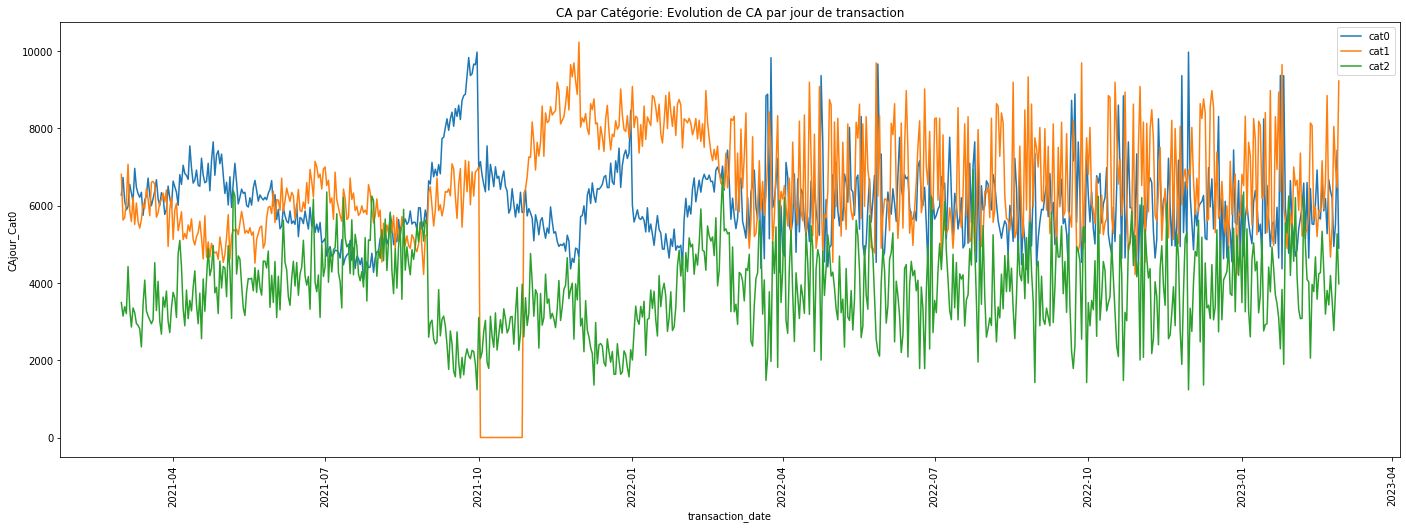

In [40]:
plt.figure(figsize=(24,8))
sns.lineplot(x='transaction_date',y='CAjour_Cat0',data=CA_jour_categ_join,label='cat0')
sns.lineplot(x='transaction_date',y='CAjour_Cat1',data=CA_jour_categ_join,label='cat1')
sns.lineplot(x='transaction_date',y='CAjour_Cat2',data=CA_jour_categ_join,label='cat2')

plt.xticks(rotation=90)
plt.title('CA par Catégorie: Evolution de CA par jour de transaction')
plt.legend()
plt.show()

### Zoomer la période d'où CA de catégorie 1 sont manquante
    La période d'où les données de CA de catégorie 1 manquantes sont entre 02/10/2021 et 27/10/2021

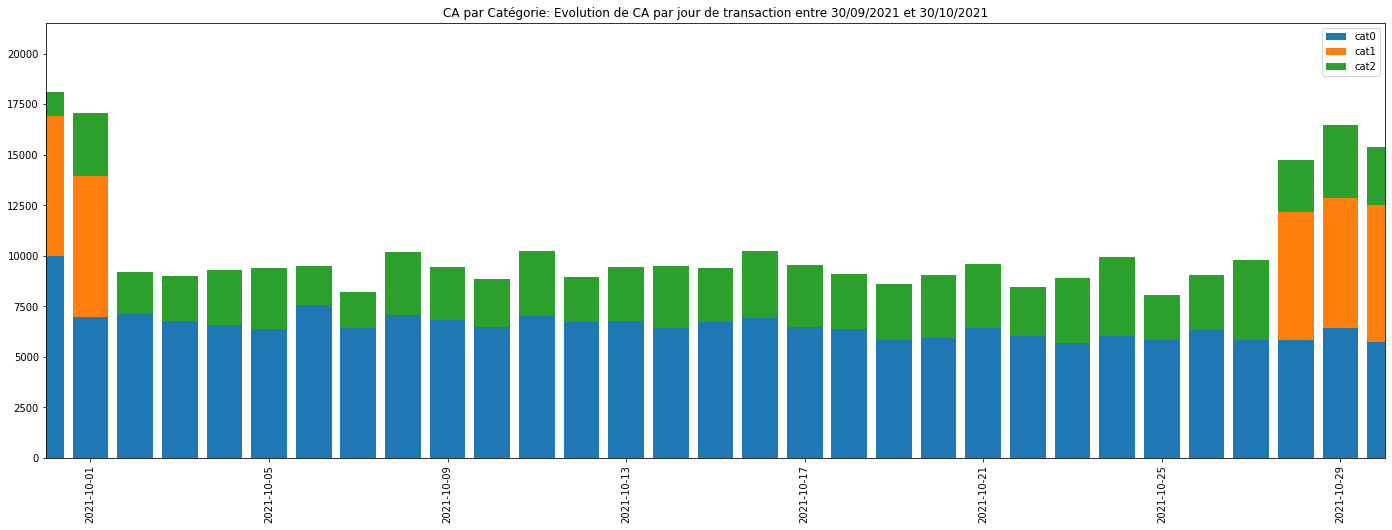

In [41]:
x=CA_jour_categ_join['transaction_date']
y0=CA_jour_categ_join['CAjour_Cat0']
y1=CA_jour_categ_join['CAjour_Cat1']
y2=CA_jour_categ_join['CAjour_Cat2']
y3=y0+y1

fig,ax=plt.subplots(figsize=(24,8))

ax.bar(x,y0,label='cat0')
ax.bar(x,y1,bottom=y0,label='cat1')
ax.bar(x,y2,bottom=y3,label='cat2')

plt.xlim([datetime.date(2021,9,30),datetime.date(2021,10,30)])
plt.legend()
plt.xticks(rotation=90)
plt.title('CA par Catégorie: Evolution de CA par jour de transaction entre 30/09/2021 et 30/10/2021')
plt.show()

### 3.2.3 Décision prise concernant CA manquante en catégorie 1: 
    Enlever les données entre 02/10/2021 et 27/10/2021 de 3 catégories pour équilibrer les données entre les 3 catégories dans les analyses suivantes.

In [42]:
#Enlever les données entre 02/10/2021 et 27/10/2021 dans transactions
transactions=transactions[(transactions['transaction_date']>datetime.datetime(2021,10,27)) | (transactions['transaction_date']<datetime.datetime(2021,10,2))]

#Vérifier transactions après le nettoyage
transactions.head()

id_prod                        date session_id client_id  price  categ sex  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534  15.99    1.0   m   
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714   7.99    0.0   f   
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941  69.99    2.0   m   
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232   4.99    0.0   m   

   birth transaction_date  age  year  month  
0   1986       2022-05-20   37  2022      5  
1   1988       2022-02-02   35  2022      2  
2   1968       2022-06-18   55  2022      6  
3   2000       2021-06-24   23  2021      6  
4   1980       2023-01-11   43  2023      1

# 4.un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc

## 4.1 Connaitre les produits

    Nombre de Produit Catégorie 0 est : 2291
    prix de Produit Catégorie 0 est dans la forchette entre  0.62 et 40.99

    Nombre de Produit Catégorie 1 est : 737
    prix de Produit Catégorie 1 est dans la forchette entre  2.0 et 80.99


    Nombre de Produit Catégorie 2 est : 236
    prix de Produit Catégorie 2 est dans la forchette entre  30.99 et 300.0

Nombre de Produit est : 3264 Nombre de catégorie: 3
Nombre de Produit Catégorie 0 est : 2291
price de Produit Catégorie 0 est dans la forchette entre  0.62 et 40.99
Nombre de Produit Catégorie 1 est : 737
price de Produit Catégorie 1 est dans la forchette entre  2.0 et 80.99
Nombre de Produit Catégorie 2 est : 236
price de Produit Catégorie 2 est dans la forchette entre  30.99 et 300.0


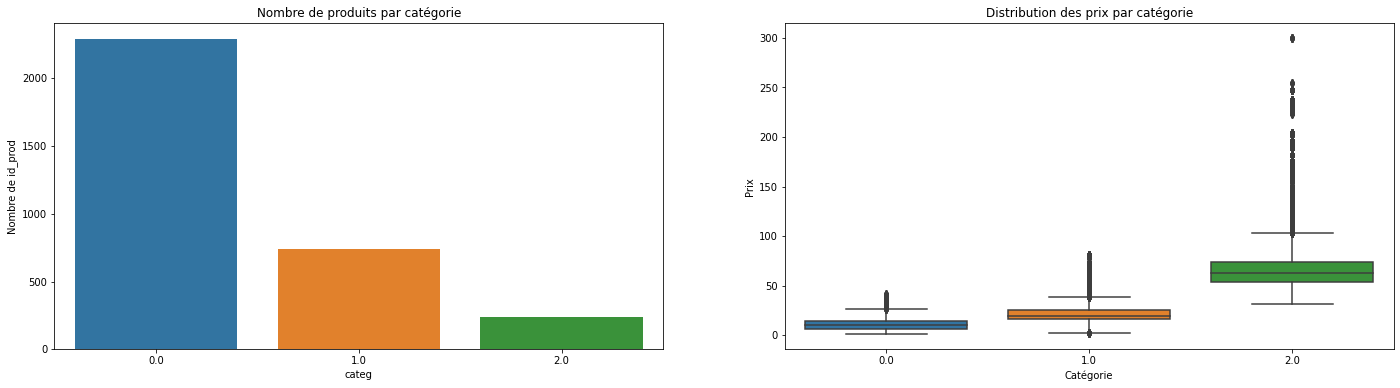

In [43]:
# imprimer le nombre de id_prod unique et le prix maximal et minimal des id_prod de categorie 0, catégorie 1 et catégorie 2

print('Nombre de Produit est :',len(transactions.id_prod.unique()),'Nombre de catégorie:',len(transactions.categ.unique()))

print('Nombre de Produit Catégorie 0 est :',len(transactions[transactions.categ==0.0].id_prod.unique()))
print('price de Produit Catégorie 0 est dans la forchette entre ',min(transactions[transactions.categ==0.0].price), 'et',max(transactions[transactions.categ==0.0].price))

print('Nombre de Produit Catégorie 1 est :',len(transactions[transactions.categ==1.0].id_prod.unique()))
print('price de Produit Catégorie 1 est dans la forchette entre ',min(transactions[transactions.categ==1.0].price), 'et',max(transactions[transactions.categ==1.0].price))


print('Nombre de Produit Catégorie 2 est :',len(transactions[transactions.categ==2.0].id_prod.unique()))
print('price de Produit Catégorie 2 est dans la forchette entre ',min(transactions[transactions.categ==2.0].price), 'et',max(transactions[transactions.categ==2.0].price))




plt.figure(figsize=(24,6))

#Affichier dans un graphique le nombre de produits par catégorie
plt.subplot(121)
sns.barplot(x='categ',y='id_prod',data=transactions.groupby('categ',as_index=False).id_prod.nunique())
plt.ylabel('Nombre de id_prod')
plt.title('Nombre de produits par catégorie')

#Affichier dans un graphique la distribution des prix de produits par catégorie
plt.subplot(122)
sns.boxplot(x='categ',y='price',data=transactions)
plt.title('Distribution des prix par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Prix')

plt.show()

## 4.2 Calculer le chiffre d'affaire par produit

### 4.2.1 Calculer le CA par produit en affichant le top5 et le flop 5
    Le produit le plus vendu est 2_159 avec un CA de 94893.50
    Le produit le moins vendu est 0_1539 avec un CA de 0.99

In [44]:
#Créer CA_product et calculer le CA par id_prod sur le tableau transaction avec groupby
CA_product=transactions.groupby(['id_prod','categ'],as_index=False)['price'].sum().rename({'price':'CAproduct'},axis=1).sort_values('CAproduct',ascending=False)

#Créer Prix_product pour avoir le prix par produit
Prix_product=transactions.groupby(['id_prod','price'],as_index=False)['session_id'].count()
Prix_product=Prix_product.drop('session_id',axis=1)

#Récupérer le prix de chaque produit de transactions
CA_product=pd.merge(CA_product,Prix_product,how='left',on='id_prod')

#affichier le top5 des produits les meilleures vendus
display(CA_product.head())

#affichier le flop5 des produits les moins vendus
display(CA_product.tail())

CA_product.info()

id_prod  categ  CAproduct   price
0   2_159    2.0   92703.65  145.99
1   2_135    2.0   67748.18   68.99
2   2_112    2.0   63177.95   67.57
3   2_102    2.0   59258.28   59.14
4   2_209    2.0   55712.04   69.99

id_prod  categ  CAproduct  price
3259   0_643    0.0       1.98   0.99
3260  0_1653    0.0       1.98   0.99
3261  0_1284    0.0       1.38   1.38
3262   0_898    0.0       1.27   1.27
3263  0_1539    0.0       0.99   0.99

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264 entries, 0 to 3263
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id_prod    3264 non-null   object 
 1   categ      3264 non-null   float64
 2   CAproduct  3264 non-null   float64
 3   price      3264 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.5+ KB


### 4.2.2 Distribution CA en fonction des produits
    Nombre des produits : 3264
    50% des produits avec un CA <781
    75% des produits avec un CA <3308

Statistique description de CA par id_prod est:
 count     3264.000000
mean      3558.599629
std       7261.994965
min          0.990000
25%        223.710000
50%        781.050000
75%       3308.917500
max      92703.650000
Name: CAproduct, dtype: float64


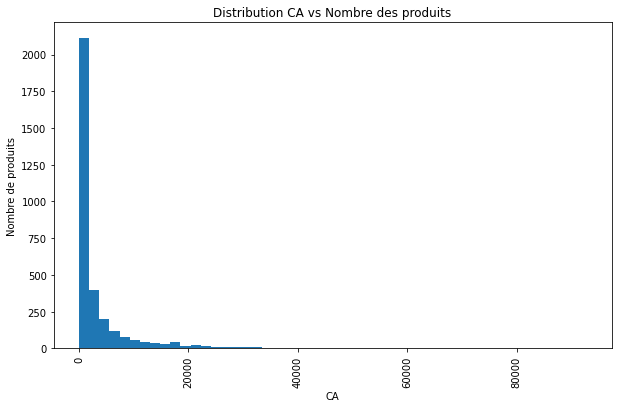

Nombre des produits avec CA <=3308 2446
Nombre des produits avec CA >3308 818


In [45]:

#Vérifier la distribution CA par la description statistique
print('Statistique description de CA par id_prod est:\n',CA_product.CAproduct.describe())


#Visualiser la distribution CA des id_prod en histgramme

plt.figure(figsize=(10,6))
plt.hist('CAproduct',50,data=CA_product)
plt.xticks(rotation=90)
plt.xlabel('CA')
plt.ylabel('Nombre de produits')
plt.title('Distribution CA vs Nombre des produits')
plt.show()

print('Nombre des produits avec CA <=3308',len(CA_product[CA_product.CAproduct<=3308].id_prod.unique()))
print('Nombre des produits avec CA >3308',len(CA_product[CA_product.CAproduct>3308].id_prod.unique()))

### 4.2.3 Affichier le top30 et le flop30 des produits en chiffre d'affaire dans les graphiques
    Les top30: 3 produits avec CA qui dépasse 60000
    Les flop30: tous les produits avec un CA < 5 qui ne sont pas les informations pertinentes pour l'analyse par la suite.

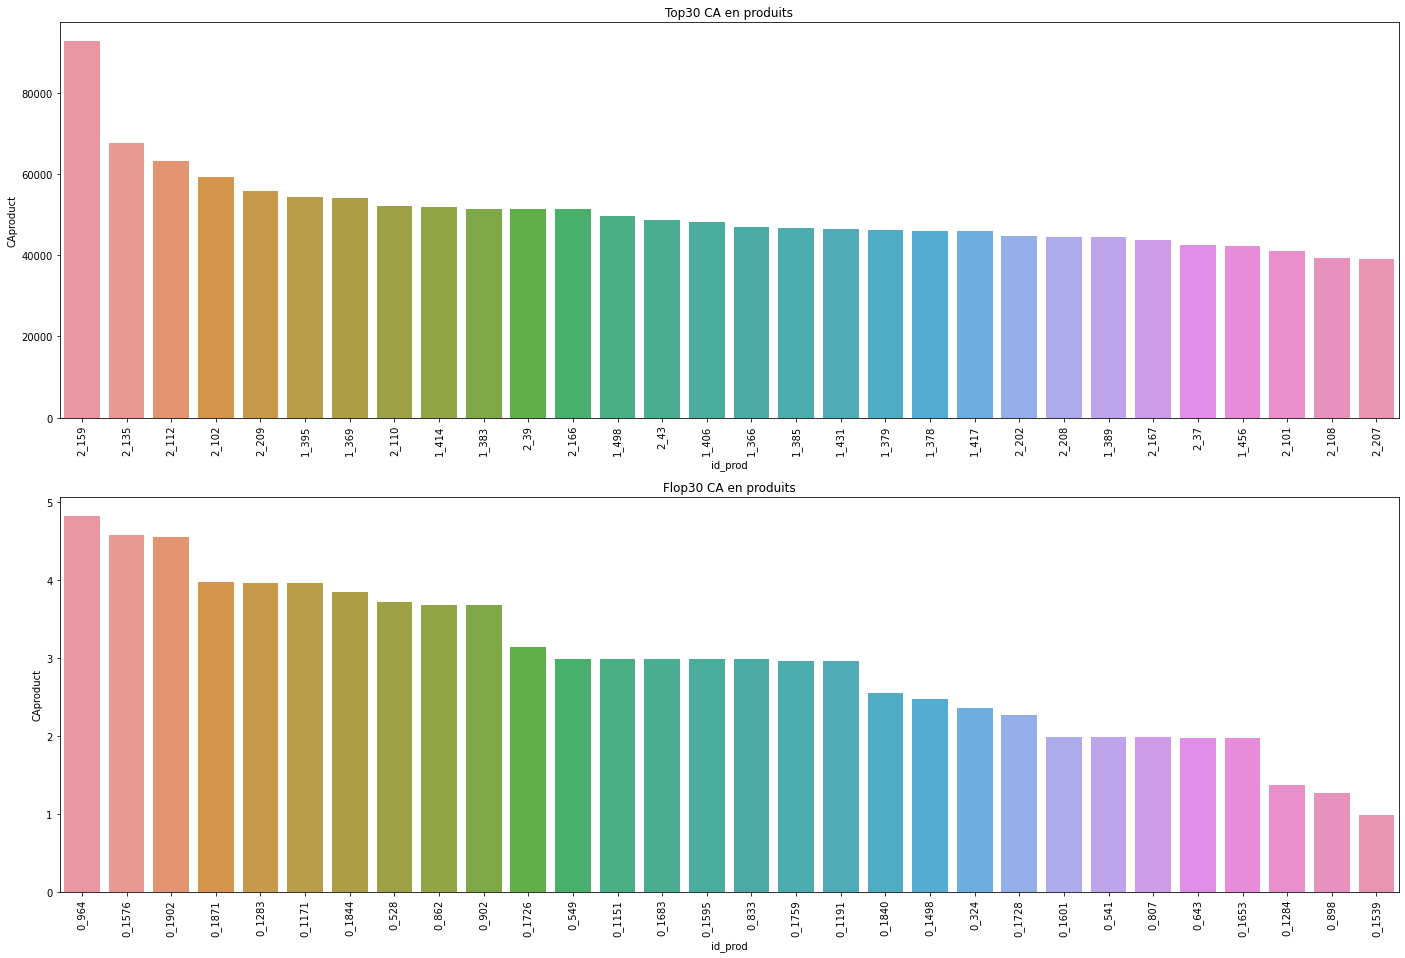

In [46]:

#Créer tableau top30 et flop30 de CA par id_prod pour les graphiques
TOP30_Product=CA_product.head(30)
FLOP30_Product=CA_product.tail(30)

plt.figure(figsize=(24,16))

#Graphique bar pour top30 des produits en CA
plt.subplot(211)
sns.barplot('id_prod','CAproduct',data=TOP30_Product)
plt.xticks(rotation=90)
plt.title('Top30 CA en produits')

#Graphique bar pour flop30 des produits en CA
plt.subplot(212)
sns.barplot('id_prod','CAproduct',data=FLOP30_Product)
plt.xticks(rotation=90)
plt.title('Flop30 CA en produits')
plt.show()



### 4.2.4 CA VS Price par catégorie
    La vente de catégorie 0 est plus dynamique sur les produits avec un prix entre 3 et 20
    La vente de catégorie 1 est plus dynamique sur les produits avec un prix entre 10 et 30
    
    La vente de catégorie 2 est 
        plus dynamique sur les produits avec un prix entre 50 et 75 et avec un prix > 150, 
        relativement faible sur les produits avec un prix entre 75 et 150

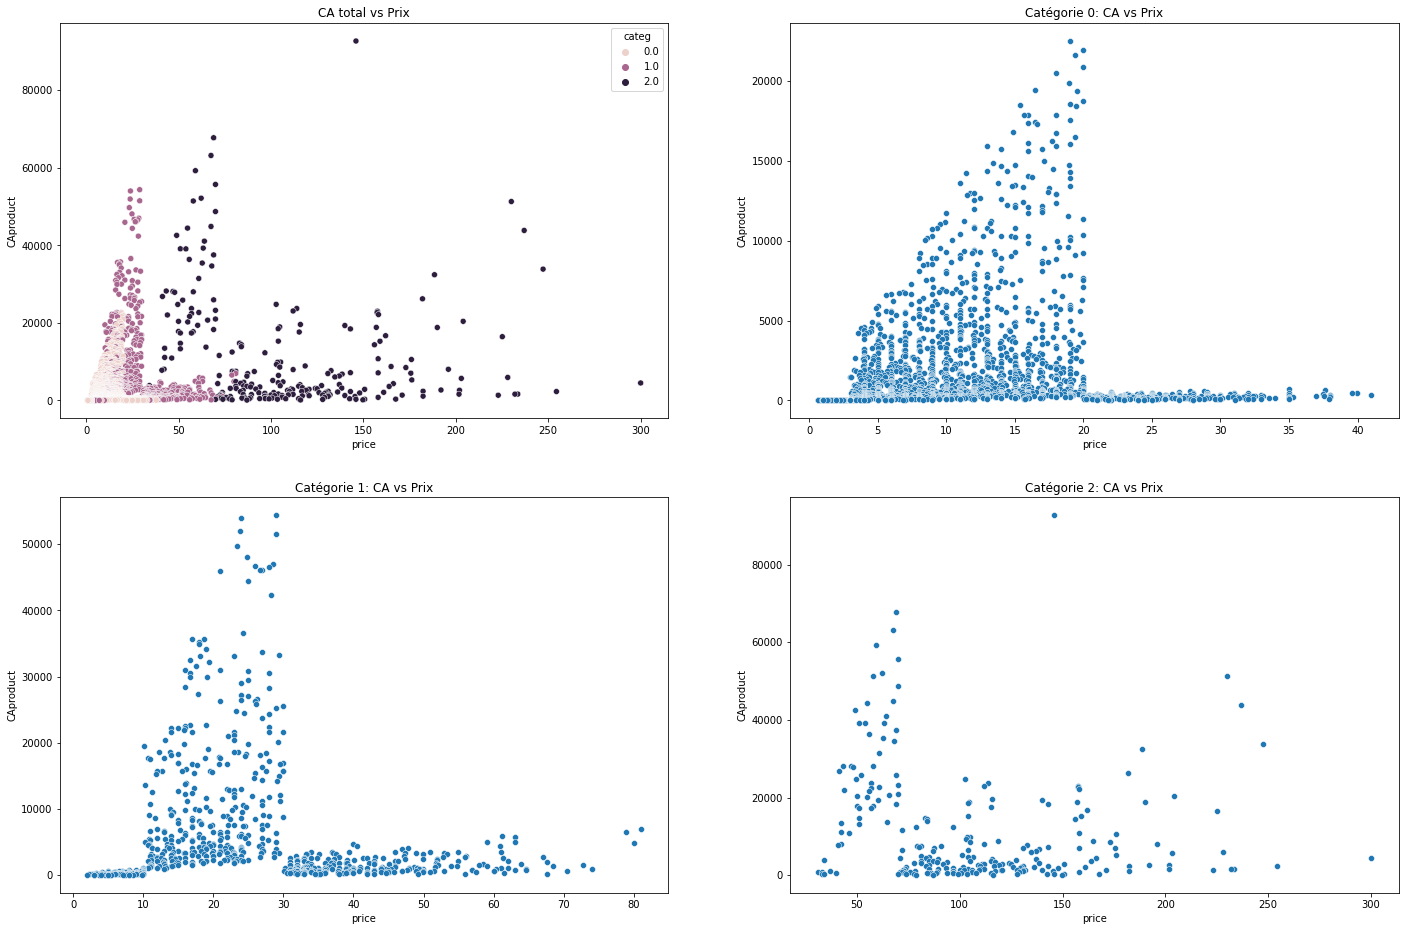

In [47]:


plt.figure(figsize=(24,16))

plt.subplot(221)
sns.scatterplot(x='price',y='CAproduct',data=CA_product,hue='categ')
plt.title('CA total vs Prix')
plt.subplot(222)
sns.scatterplot(x='price',y='CAproduct',data=CA_product[CA_product.categ==0.0])
plt.title('Catégorie 0: CA vs Prix')
plt.subplot(223)
sns.scatterplot(x='price',y='CAproduct',data=CA_product[CA_product.categ==1.0])
plt.title('Catégorie 1: CA vs Prix')
plt.subplot(224)
sns.scatterplot(x='price',y='CAproduct',data=CA_product[CA_product.categ==2.0])
plt.title('Catégorie 2: CA vs Prix')
plt.show()

### 4.2.5 Concentration des produits par rapport CA réalisé
    Coefficient GINI de lorenz produit vs CA est 0.74, donc 20% des produits réalise environ 80% de chiffre d'affaire

#### Graphique lorenz et coéfficient GINI pour la concentration des produits vs CA total

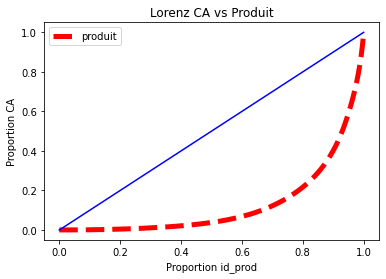

La coéfficient GINI pour la concentration de vente en fonction de id_prod est: 0.74


In [48]:
Lorenz_prod=transactions.groupby(['id_prod','categ'],as_index=False).price.sum().rename({'price':'CAproduit'},axis=1)

#Calculer CA cumulative et porportion de id_prod avec toutes les catégories confondues
Lorenz_prod=Lorenz_prod.sort_values('CAproduit',ascending=False)
CAproduit=Lorenz_prod['CAproduit'].values
n=len(CAproduit)
lorenz=np.cumsum(np.sort(CAproduit))/CAproduit.sum()
lorenz=np.append([0],lorenz)

#Graphique lorenz

x=np.linspace(0-1/n,1+1/n,n+1)
plt.plot(x,lorenz,'r--',lw=5,label='produit')
plt.plot(x,x,c='b')
plt.legend()
plt.title('Lorenz CA vs Produit')
plt.xlabel('Proportion id_prod')
plt.ylabel('Proportion CA')
plt.show()



#Calculer GINI 
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC
gini_produit = round(2*S,2)
print('La coéfficient GINI pour la concentration de vente en fonction de id_prod est:',gini_produit)

## 4.3 Calculer la répartition de chiffre d'affaire par catégorie des produits

### 4.3.1 Calculer la répartition de CA gobal par catégorie et la répartition de CA annuel par catégorie
    CA Global:
    39% de CA global est contribué par le catégorié 1, 37% par catégorie 0, et 23% par catégorie 2
    CA annuel:
    En 2021, Catégorie 0 a contribué le plus de chiffre d'affaire avec une répartition de 39%
    En 2022 et 2023 Catégorie 1 dépasse Catégorie 0 avec une répartition de 40% contre 37% en 2021
    Le catégorie 2 reste relativement stable avec une répartition de 23% en 2021 et 2022, 24% en 2023

In [49]:
#Créer CA_categorie et calculer CA de chaque catégorie basé sur transactions avec méthode groupby
CA_categorie=transactions.groupby('categ',as_index=False)['price'].sum().rename({'price':'CAcategorie'},axis=1)

#Ajouter colonne Porportion De CA dans CA_catégorie pour calculer la proportion de CA de chaque catégorie
CA_categorie['Porportion De CA']=CA_categorie.CAcategorie/CA_categorie.CAcategorie.sum()

#Créer CA_categorie_year et calculer CA de chaque catégorie de chaque année basé sur transactions avec méthode groupby
CA_categorie_year=transactions.groupby(['year','categ'],as_index=False)['price'].sum().rename({'price':'CAcategorie'},axis=1)

#Ajouter colonne Porportion De CA Annuel dans CA_categorie_year et calculer la proportion de CA de chaque catégorie sur CA de l'année concernée
CA_categorie_year.loc[(CA_categorie_year.year==2021),'Porportion De CA Annuel']=CA_categorie_year.CAcategorie/(CA_categorie_year[CA_categorie_year.year==2021]['CAcategorie'].sum())

CA_categorie_year.loc[(CA_categorie_year.year==2022),'Porportion De CA Annuel']=CA_categorie_year.CAcategorie/(CA_categorie_year[CA_categorie_year.year==2022]['CAcategorie'].sum())

CA_categorie_year.loc[(CA_categorie_year.year==2023),'Porportion De CA Annuel']=CA_categorie_year.CAcategorie/(CA_categorie_year[CA_categorie_year.year==2023]['CAcategorie'].sum())

# Affichier 2 tableaux CA_categorie et CA_categorie_year
display(CA_categorie)
display(CA_categorie_year)


categ   CAcategorie  Porportion De CA
0    0.0  4.253614e+06          0.366209
1    1.0  4.653723e+06          0.400656
2    2.0  2.707932e+06          0.233136

year  categ   CAcategorie  Porportion De CA Annuel
0  2021    0.0  1.715478e+06                 0.378614
1  2021    1.0  1.777996e+06                 0.392412
2  2021    2.0  1.037467e+06                 0.228974
3  2022    0.0  2.194247e+06                 0.359126
4  2022    1.0  2.485275e+06                 0.406758
5  2022    2.0  1.430436e+06                 0.234116
6  2023    0.0  3.438890e+05                 0.352935
7  2023    1.0  3.904516e+05                 0.400722
8  2023    2.0  2.400286e+05                 0.246343

### 4.3.2 Affichier la répartition de CA global par catégorie et la répartition de CA annuel par catégorie dans les graphiques

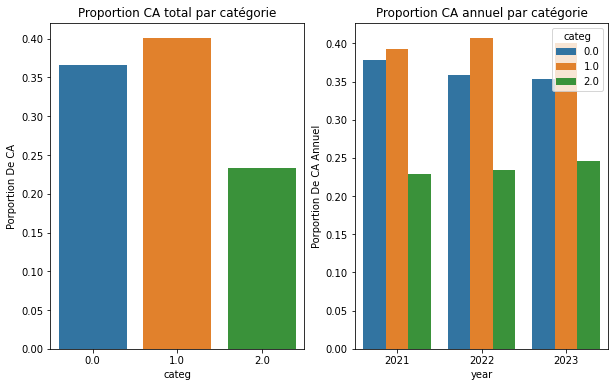

In [50]:
plt.figure(figsize=(10,6))

plt.subplot(121)
sns.barplot('categ','Porportion De CA',data=CA_categorie)
plt.title('Proportion CA total par catégorie')

plt.subplot(122)
sns.barplot('year','Porportion De CA Annuel',hue='categ',data=CA_categorie_year)
plt.title('Proportion CA annuel par catégorie')
plt.show()

### 4.3.3 Graphique lorenz et coéfficient GINI pour la concentration des produits vs CA par catégorie

    La concentration des produits par rapport à CA total réalisé est plus important en catégorie 0 en comparant les 2 autres catégories.
    
    La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 0 est: 0.71
        
    La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 1 est: 0.68
    
    La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 2 est: 0.61

La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 0 est: 0.71
La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 1 est: 0.68
La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 2 est: 0.61


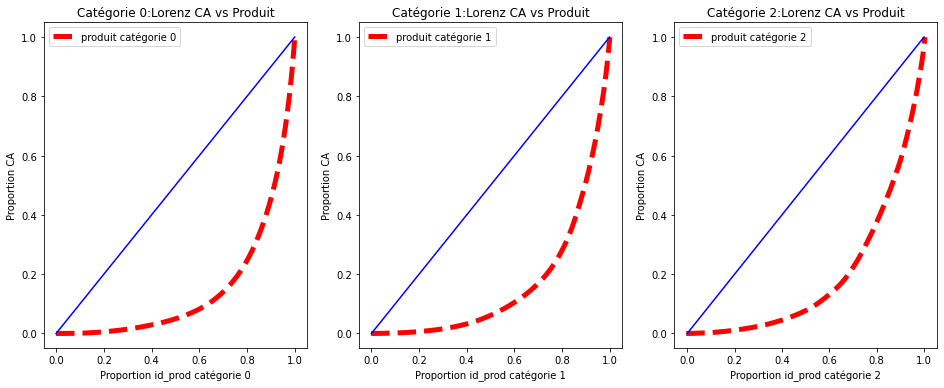

In [51]:

Lorenz_prod_categ0=Lorenz_prod[Lorenz_prod.categ==0.0]
Lorenz_prod_categ1=Lorenz_prod[Lorenz_prod.categ==1.0]
Lorenz_prod_categ2=Lorenz_prod[Lorenz_prod.categ==2.0]


#Calculer CA cumulative et porportion de id_prod avec toutes les catégories confondues

##Catégorie 0
Lorenz_prod_categ0=Lorenz_prod_categ0.sort_values('CAproduit',ascending=False)
CAproduit_categ0=Lorenz_prod_categ0['CAproduit'].values
n_categ0=len(CAproduit_categ0)
lorenz_categ0=np.cumsum(np.sort(CAproduit_categ0))/CAproduit_categ0.sum()
lorenz_categ0=np.append([0],lorenz_categ0)


##Catégorie 1

Lorenz_prod_categ1=Lorenz_prod_categ1.sort_values('CAproduit',ascending=False)
CAproduit_categ1=Lorenz_prod_categ1['CAproduit'].values
n_categ1=len(CAproduit_categ1)
lorenz_categ1=np.cumsum(np.sort(CAproduit_categ1))/CAproduit_categ1.sum()
lorenz_categ1=np.append([0],lorenz_categ1)


##Catégorie 2

Lorenz_prod_categ2=Lorenz_prod_categ2.sort_values('CAproduit',ascending=False)
CAproduit_categ2=Lorenz_prod_categ2['CAproduit'].values
n_categ2=len(CAproduit_categ2)
lorenz_categ2=np.cumsum(np.sort(CAproduit_categ2))/CAproduit_categ2.sum()
lorenz_categ2=np.append([0],lorenz_categ2)


#Calculer GINI 

##Catégorie 0
AUC_categ0 = (lorenz_categ0.sum() -lorenz_categ0[-1]/2 -lorenz_categ0[0]/2)/n_categ0
S_categ0 = 0.5 - AUC_categ0
gini_produit_categ0 = round(2*S_categ0,2)
print('La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 0 est:',gini_produit_categ0)

##Catégorie 1
AUC_categ1 = (lorenz_categ1.sum() -lorenz_categ1[-1]/2 -lorenz_categ1[0]/2)/n_categ1
S_categ1 = 0.5 - AUC_categ1
gini_produit_categ1 = round(2*S_categ1,2)
print('La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 1 est:',gini_produit_categ1)


##Catégorie 2
AUC_categ2 = (lorenz_categ2.sum() -lorenz_categ2[-1]/2 -lorenz_categ2[0]/2)/n_categ2
S_categ2 = 0.5 - AUC_categ2
gini_produit_categ2 = round(2*S_categ2,2)
print('La coéfficient GINI pour la concentration de vente en fonction de id_prod dans catégorie 2 est:',gini_produit_categ2)

#Graphique lorenz

plt.figure(figsize=(16,6))

##Catégorie 0 lorenz

plt.subplot(131)
x_categ0=np.linspace(0-1/n_categ0,1+1/n_categ0,n_categ0+1)
plt.plot(x_categ0,lorenz_categ0,'r--',lw=5,label='produit catégorie 0')
plt.plot(x,x,c='b')
plt.legend()
plt.title('Catégorie 0:Lorenz CA vs Produit')
plt.xlabel('Proportion id_prod catégorie 0')
plt.ylabel('Proportion CA')

##Catégorie 1 lorenz

plt.subplot(132)
x_categ1=np.linspace(0-1/n_categ1,1+1/n_categ1,n_categ1+1)
plt.plot(x_categ1,lorenz_categ1,'r--',lw=5,label='produit catégorie 1')
plt.plot(x,x,c='b')
plt.legend()
plt.title('Catégorie 1:Lorenz CA vs Produit')
plt.xlabel('Proportion id_prod catégorie 1')
plt.ylabel('Proportion CA')


##Catégorie 2 lorenz

plt.subplot(133)
x_categ2=np.linspace(0-1/n_categ2,1+1/n_categ2,n_categ2+1)
plt.plot(x_categ2,lorenz_categ2,'r--',lw=5,label='produit catégorie 2')
plt.plot(x,x,c='b')
plt.legend()
plt.title('Catégorie 2:Lorenz CA vs Produit')
plt.xlabel('Proportion id_prod catégorie 2')
plt.ylabel('Proportion CA')


plt.show()


# 5. les profils de nos clients et la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz


## 5.1 Connaitre les clients

### 5.1.1 Nombre des clients et la fourchette de l'âge des clients per genre
    Nombre de client femme est  4478 et Fourchette age de client femme est entre 19 et 94
    Nombre de client homme est  4121 et Fourchette age de client homme est entre 19 et 94

In [52]:

#Calculer le nombre  et l'âge maximum et minimum de clients totaux
print('Nombre de client est ',len(transactions.client_id.unique()))
print('la Fourchette de l\'âge des clients totaux est entre',min(transactions.age),'et',max(transactions.age))

#Calculer le nombre  et l'âge maximum et minimum de clients femmes
print('Nombre de client femme est ',len(transactions[transactions.sex=='f'].client_id.unique()))
print('la Fourchette de l\'âge des clients femme est entre',min(transactions[transactions.sex=='f'].age),'et',max(transactions[transactions.sex=='f'].age))

#Calculer le nombre  et l'âge maximum et minimum de clients hommes
print('Nombre de client homme est ',len(transactions[transactions.sex=='m'].client_id.unique()))
print('la Fourchette de l\'âge des clients homme est entre',min(transactions[transactions.sex=='m'].age),'et',max(transactions[transactions.sex=='m'].age))

Nombre de client est  8599
la Fourchette de l'âge des clients totaux est entre 19 et 94
Nombre de client femme est  4478
la Fourchette de l'âge des clients femme est entre 19 et 94
Nombre de client homme est  4121
la Fourchette de l'âge des clients homme est entre 19 et 94


### 5.1.2 La description statistique des clients totaux, des clients femmes, des clients hommes sont similaires.
    

    
    50% des clients sont entre 31 ans et 57 ans
    
    25% des clients < 31 ans
    
    25% des clients > 57 ans
    
    
    L'âge moyenne des clients femmes est 45 ans contre 44 ans pour clients hommes et clients totaux
    
    L'âge quantile de 50% des clients hommes est 43 ans contre 44 ans pour clients femmes et clients totaux
    Tous les autres descriptions sont identiques entre les 3 situations. 
    

    

In [53]:
#Description statistique de l'âge des clients total, des clients femmes et des clients hommes
print('Description statistique de l\'âge des clients:\n',transactions.groupby(['client_id','sex','age'],as_index=False).client_id.count()['age'].describe())
print('Description statistique de l\'âge des clients femmes:\n',transactions[transactions.sex=='f'].groupby(['client_id','sex','age'],as_index=False).client_id.count()['age'].describe())
print('Description statistique de l\'âge des clients hommes:\n',transactions[transactions.sex=='m'].groupby(['client_id','sex','age'],as_index=False).client_id.count()['age'].describe())

Description statistique de l'âge des clients:
 count    8599.000000
mean       44.738109
std        16.909376
min        19.000000
25%        31.000000
50%        44.000000
75%        57.000000
max        94.000000
Name: age, dtype: float64
Description statistique de l'âge des clients femmes:
 count    4478.000000
mean       45.025011
std        17.092603
min        19.000000
25%        31.000000
50%        44.000000
75%        57.000000
max        94.000000
Name: age, dtype: float64
Description statistique de l'âge des clients hommes:
 count    4121.000000
mean       44.426353
std        16.704484
min        19.000000
25%        31.000000
50%        43.000000
75%        57.000000
max        94.000000
Name: age, dtype: float64


### 5.1.3 Visualiser les données descriptives des clients

 
    On trouve également une légère croissance en nombre des clients qui suit la croissance de l'âge entre 19 ans à 45 ans, 
    puis une décroissance de nombre des client suite à la croissance de l'âge des clients entre 46 ans et 94 ans.

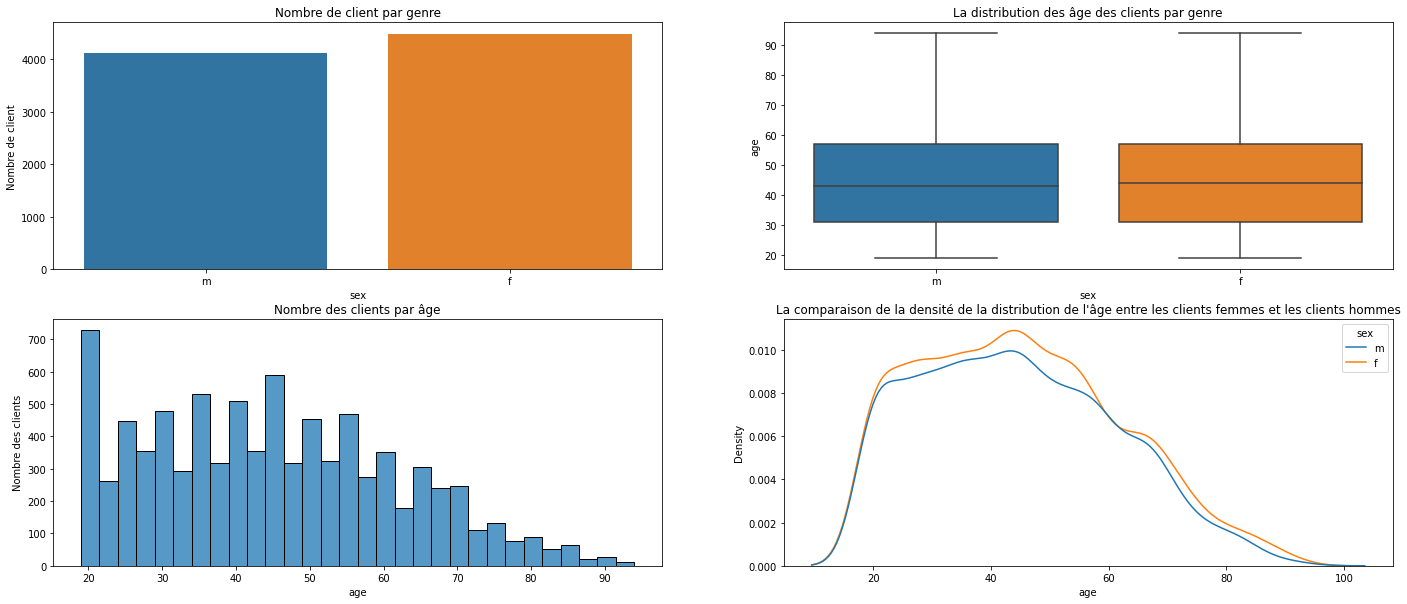

In [54]:


plt.figure(figsize=(24,10))

#Visualiser le nombre de client femme et homme
plt.subplot(221)
sns.countplot(x='sex',data=transactions.groupby(['client_id','sex'],as_index=False).client_id.count())
plt.title('Nombre de client par genre')
plt.ylabel('Nombre de client')

#Visualiser la distribution d'âge des clients femmes et hommes
plt.subplot(222)
sns.boxplot(x='sex',y='age',data=transactions.groupby(['client_id','sex','age'],as_index=False).client_id.count())
plt.title('La distribution des âge des clients par genre')


plt.subplot(223)
sns.histplot(x='age',data=transactions.groupby(['client_id','sex','age'],as_index=False).client_id.count())
plt.title('Nombre des clients par âge')
plt.ylabel('Nombre des clients')


plt.subplot(224)
sns.kdeplot(x='age', hue='sex',data=transactions.groupby(['client_id','sex','age'],as_index=False).client_id.count())
plt.title('La comparaison de la densité de la distribution de l\'âge entre les clients femmes et les clients hommes')

plt.show()



## 5.2 Calculer le chiffre d'affaire par Client

     

### 5.2.1 Visualiser la distribution de CA par rapport au client
    Les tops clients ont une différence de CA largement importante que le plus part des clients
    le plus part des clients réalisent un CA entre 0 et 2000

In [55]:
#Créer CA_client_count et calculer le CA par client
CA_client_count=transactions.groupby(['client_id','sex','age'],as_index=False).price.sum().rename({'price':'CA'},axis=1).sort_values('CA',ascending=False)
CA_client_count.head()

client_id sex  age         CA
677     c_1609   m   43  314915.65
4388    c_4958   m   24  284285.38
6337    c_6714   f   55  150921.42
2724    c_3454   m   54  112502.53
2108    c_2899   f   29    5214.05

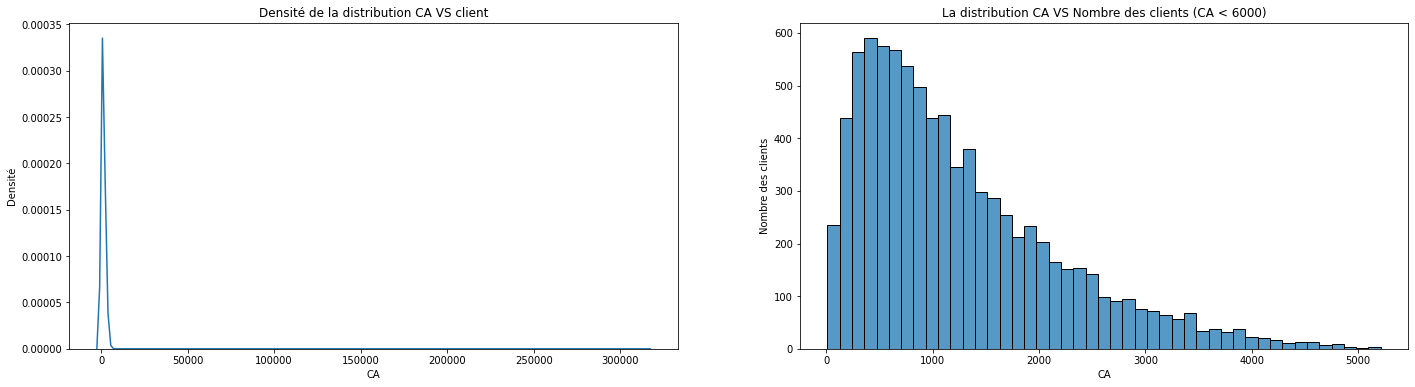

Nombre des clients avec CA <6000 8595
Nombre des clients avec CA >=6000 4


In [56]:

plt.figure(figsize=(24,6))

plt.subplot(121)
sns.kdeplot(x='CA',data = CA_client_count)
plt.xlabel('CA')
plt.ylabel('Densité')
plt.title('Densité de la distribution CA VS client')

plt.subplot(122)
sns.histplot(x='CA',data = CA_client_count[CA_client_count.CA<6000])
plt.xlabel('CA')
plt.ylabel('Nombre des clients')
plt.title('La distribution CA VS Nombre des clients (CA < 6000)')


plt.show()

print('Nombre des clients avec CA <6000', len(CA_client_count[CA_client_count.CA<6000]['client_id'].unique()))
print('Nombre des clients avec CA >=6000',len(CA_client_count[CA_client_count.CA>=6000]['client_id'].unique()))

### 5.2.2 Affichier les Top5 client et les flops5 client en Chiffre d'affaire
    Les 4 premiers Clients (c_1609,c_4958,c_6714 et c_3454) de top5 ont un chiffre d'affaire très important entre 113K et 324K 
    par rapport à la 5ième (c_2899) dans le top5 qui a seulement 5K.
    
    Les flops 5 des clients (c_2793,c_4648,c_240,c_8114 et c_8140 ) en CA ont un CA inférieur de 12.

In [57]:
CA_client=transactions.groupby('client_id',as_index=False)['price'].sum().rename({'price':'CAclient'},axis=1).sort_values('CAclient',ascending=False)
display(CA_client.head())
display(CA_client.tail())

client_id   CAclient
677     c_1609  314915.65
4388    c_4958  284285.38
6337    c_6714  150921.42
2724    c_3454  112502.53
2108    c_2899    5214.05

client_id  CAclient
1991    c_2793     12.99
4044    c_4648     11.20
1556     c_240     11.06
7889    c_8114      9.98
7918    c_8140      8.30

### 5.2.3 Affichier les Top30 et les Flops30 de client en CA dans les graphiques.
    c_1609,c_4958,c_6174,c_3454 sont les top4 clients importants qui ont un CA supérieur à 50000
    A partir de 5ième client, le CA retombe sur le tranche de 5000
    
    Les flops 30 des client ont un CA inférieur à 35 qui ne sont pas significant pour l'analyse par la suite.
    

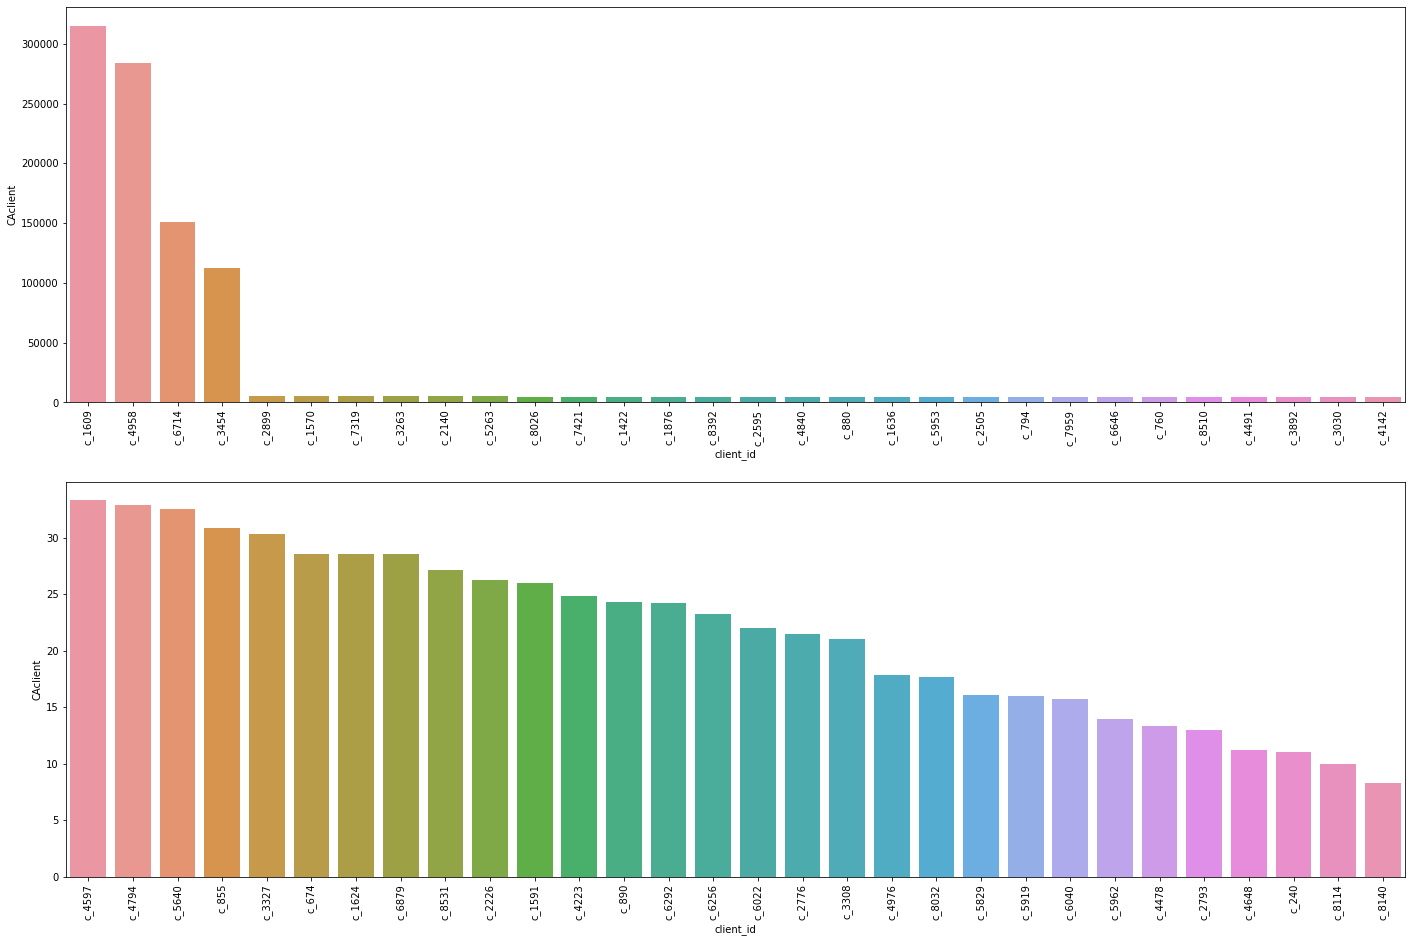

In [58]:
TOP30_client=CA_client.head(30)
FLOP30_client=CA_client.tail(30)

plt.figure(figsize=(24,16))

plt.subplot(211)
sns.barplot('client_id','CAclient',data=TOP30_client)
plt.xticks(rotation=90)
plt.subplot(212)
sns.barplot('client_id','CAclient',data=FLOP30_client)
plt.xticks(rotation=90)
plt.show()

## 5.3 CA par genre du client

### 5.3.1 Calculer le CA global par genre et le CA annuel par genre
    CA Global:
        Client homme depense 5.86M qui est légèrement plus que le CA de femme 5.74M
    CA Annuel:
        Une hausse de CA pour homme et femme en 2022 que 2021
        CA annuel est répartie entre client homme et femme avec la même tendance que CA global.
        En 2021, Homme depense 2.29M contre femme 2.23M
        En 2022, Homme depense 3.08M contre femme 3.02M
        En 2023, Homme depense 0.486M contre femme  0.487M (année partiel)

In [59]:
CA_genre=transactions.groupby('sex',as_index=False)['price'].sum().rename({'price':'CAgenre'},axis=1)
CA_genre_year=transactions.groupby(['year','sex'],as_index=False)['price'].sum().rename({'price':'CAgenre'},axis=1)
display(CA_genre)
display(CA_genre_year)

sex       CAgenre
0   f  5.745872e+06
1   m  5.869397e+06

year sex       CAgenre
0  2021   f  2.236455e+06
1  2021   m  2.294486e+06
2  2022   f  3.021703e+06
3  2022   m  3.088256e+06
4  2023   f  4.877147e+05
5  2023   m  4.866546e+05

### 5.3.2 Visualiser la répartition des CA par genre dans les graphiques
    Les clients hommes dépensent plus que les clients femmes.
    En 2022, il y a une croissance de CA pour les 2 genres des clients.
    2023 est une année partiel, il n'est pas compatible avec CA annuel de 2021 et 2022 temporairement.

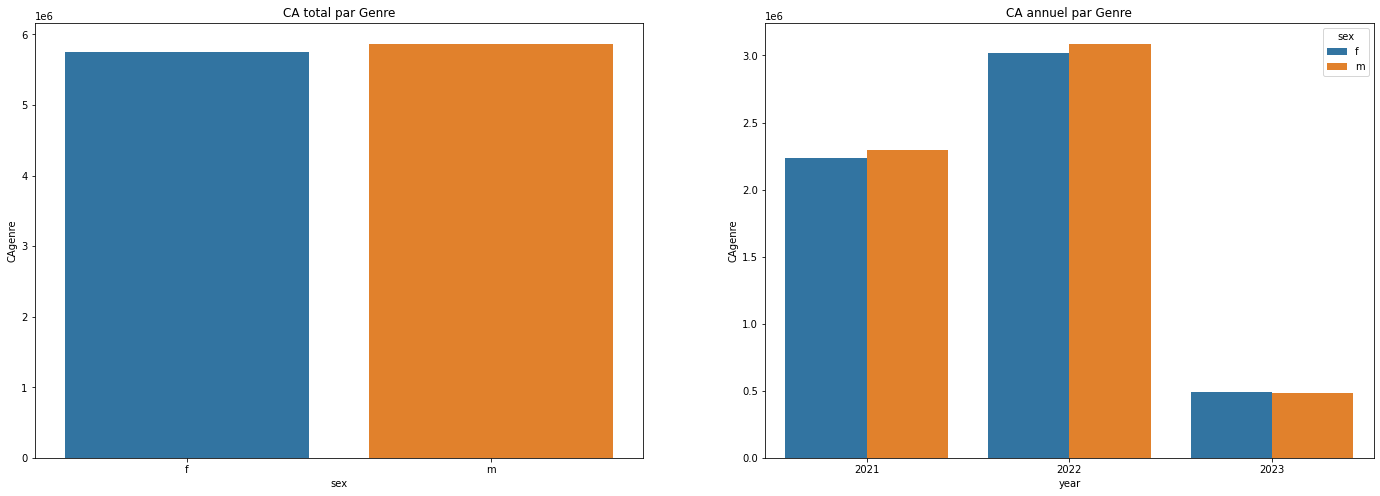

In [60]:
plt.figure(figsize=(24,8))
plt.subplot(121)
sns.barplot(x='sex',y='CAgenre',data=CA_genre)
plt.title('CA total par Genre')
plt.subplot(122)
sns.barplot(x='year',y='CAgenre',hue='sex',data=CA_genre_year)
plt.title('CA annuel par Genre')
plt.show()

### 5.3.3 Détailler la répartition de chiffre d'affaire par genre selon catégorie des produits
    Les clients hommes depensent 2.14M contre femmes 2.10M pour les produits de catégorie 0
    Les clients hommes depense 2.29M contre femmes 2.35M pour les produits de catégorie 1
    Les clients hommes depense 1.43M contre femmes 1.27M pour les produits de catégorie 2
    Clients Hommes genèrent plus de CA en catégorie 0 et 2 que femmes, et que le client femmes genère plus de CA en catégorie 1 que hommes.
    

In [61]:
CA_genre_categorie=transactions.groupby(['categ','sex'],as_index=False)['price'].sum().rename({'price':'CA_genre_categ'},axis=1)
CA_genre_categorie

categ sex  CA_genre_categ
0    0.0   f    2.109603e+06
1    0.0   m    2.144011e+06
2    1.0   f    2.358417e+06
3    1.0   m    2.295306e+06
4    2.0   f    1.277852e+06
5    2.0   m    1.430080e+06

### 5.3.4 Visualiser la répartition de CA par genre et par catégorie dans les graphiques.

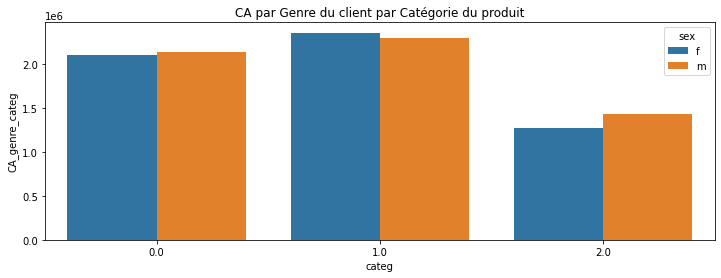

In [62]:
plt.figure(figsize=(12,4))
sns.barplot(x='categ',y='CA_genre_categ', hue='sex',data=CA_genre_categorie)
plt.title('CA par Genre du client par Catégorie du produit')
plt.show()

## 5.4 CA en fonction de l'âge des clients

### 5.4.1 CA Moyen, Nombre de clients VS l'âge des clients

    En Nombre de clients: 19 ans est l'âge d'où il y a plus de clients, il ont 437 clients
    
    En chiffre d'affaire: 43 ans et 19 ans réalise plus gros chiffre d'affaire, leur CA sont 597478 et 595100
    
    En chiffre d'affaire moyen: le client de 24 ans et 43 ans ont les CA moyen le plus importants qui sont 3022 et 3128
    
    Le nombre des clients et le CA moyen par âge suivent une tendance décroissante suite à l'âge.

In [63]:
#Créer CA_age_client et calculer CA par age
CA_age_client=CA_client_count.groupby('age',as_index=False).CA.sum()
#Créer Count_age_client et calculer Nombre de client par age
Count_age_client=CA_client_count.groupby('age',as_index=False).client_id.count()

#Dans CA_age_client récupérer le nombre de client de Count_age_client avec le clés age
CA_age_client=pd.merge(CA_age_client,Count_age_client,how='left',on='age')
CA_age_client=CA_age_client.rename({'client_id':'Nombre de clients'},axis=1)

#Créer colonne CA moyenne par age en divisant CA par nombre de client de chaque tranche age
CA_age_client['CA moyen par age']=round(CA_age_client.CA/CA_age_client['Nombre de clients'],2)
CA_age_client.sort_values('CA',ascending=False).head()

age         CA  Nombre de clients  CA moyen par age
24   43  597478.97                191           3128.16
0    19  595100.06                437           1361.79
5    24  480535.42                159           3022.24
25   44  326088.02                215           1516.69
16   35  323583.29                207           1563.20

age         CA  Nombre de clients  CA moyen par age
5    24  480535.42                159           3022.24
24   43  597478.97                191           3128.16

age         CA  Nombre de clients  CA moyen par age
0    19  595100.06                437           1361.79
25   44  326088.02                215           1516.69
16   35  323583.29                207           1563.20
18   37  301471.87                203           1485.08
26   45  317721.11                199           1596.59

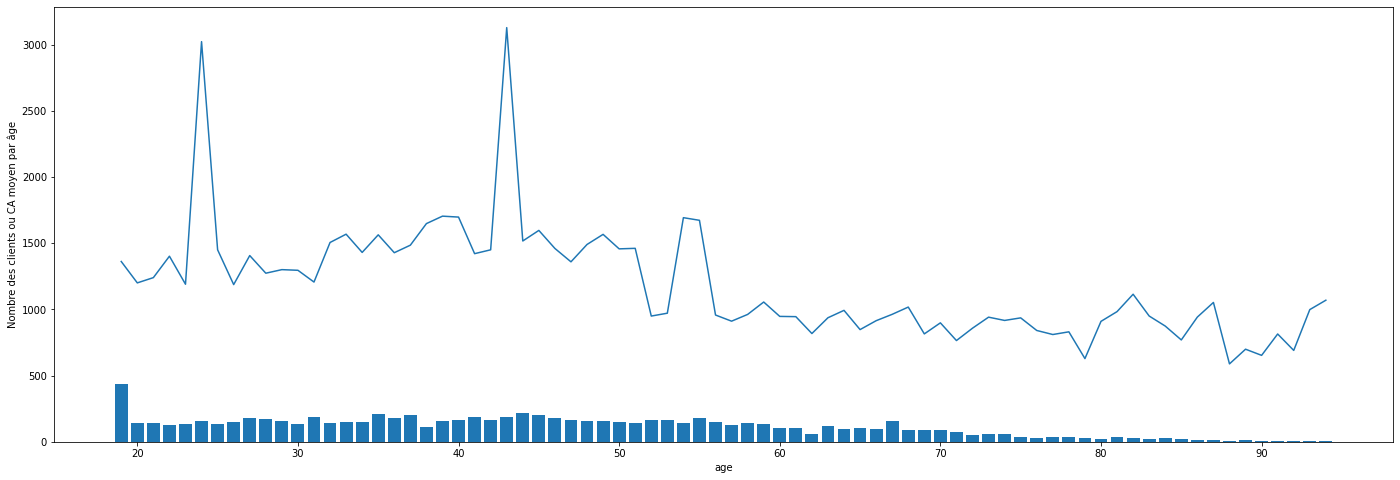

In [64]:
plt.figure(figsize=(24,8))
x=CA_age_client.age
y1=CA_age_client['Nombre de clients']
y2=CA_age_client['CA moyen par age']
plt.bar(x,y1,label='Nombre de clients')
plt.plot(x,y2,label='CA moyen par âge')
plt.xlabel('age')
plt.ylabel('Nombre des clients ou CA moyen par âge')

top5_Nombre_de_client=CA_age_client.sort_values('Nombre de clients',ascending=False).head(5)
display(CA_age_client[CA_age_client['CA moyen par age']>2500],top5_Nombre_de_client)


### 5.4.2 Classer les âges du client selon CA
    Les clients de 43 ans, 19 ans, 24 ans, 44 ans, et 35 ans sont le top5 âges qui dépensent le plus sur le site.
    Les clients de 88 ans, 91 ans, 92 ans, 93 ans, et 94 ans dépensent le moins sur le site.

In [65]:
CA_age=transactions.groupby('age',as_index=False)['price'].sum().rename({'price':'CAage'},axis=1)
CA_age_classement=CA_age.sort_values('CAage',ascending=False)
display(CA_age_classement.head(),CA_age_classement.tail())

age      CAage
24   43  597478.97
0    19  595100.06
5    24  480535.42
25   44  326088.02
16   35  323583.29

age    CAage
72   91  4885.59
69   88  4707.86
74   93  3993.88
75   94  3208.07
73   92  2760.83

### 5.4.3 la répartition de CA global en fonction de l'âge du client
    Avant 45 ans, la dépense du client ont une tendance de l'augmentation progressivement en fonction de l'âge
    A partir de 46 ans, la dépense du client décroîte suit à l'évolution d'âge.
    A partir de 88 ans, la dépense devient très faible.

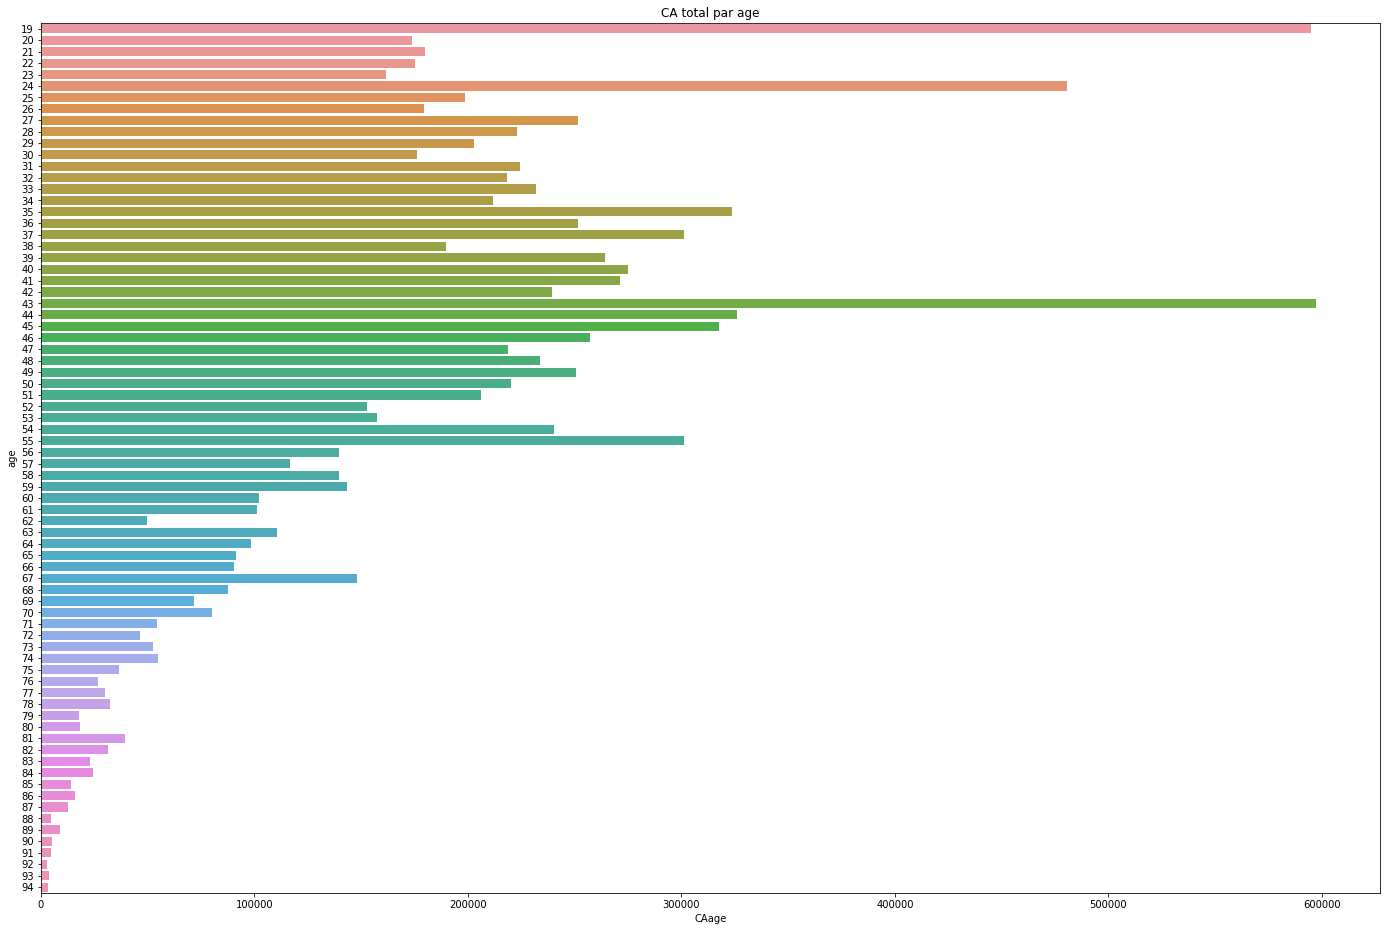

In [66]:
plt.figure(figsize=(24,16))
sns.barplot(x='CAage',y='age',orient='h',data=CA_age)
plt.title('CA total par age')
plt.show()

### 5.4.4 Vérifier la répartition de CA par âge en année de transaction
    La répartition de CA annuel par âge en 2021,2022 et 2023 sont similaires 
    et en plus il a la même tendance que la répartition de CA global par âge.
        -Une croissance avant 45 ans et une décroissance à partir de 46 ans
        -Les clients 19 ans, 43 ans, 24 ans contribuent plus de chiffre d'affaire par rapport aux clients de l'autre tranche âge.
    
    

In [67]:
CA_age_year=transactions.groupby(['year','age'],as_index=False)['price'].sum().rename({'price':'CAage'},axis=1)
CA_age_year.head()

year  age      CAage
0  2021   19  227352.20
1  2021   20   68820.45
2  2021   21   70396.70
3  2021   22   65554.74
4  2021   23   60455.87

#### Graphique CA annuel par âge des clients

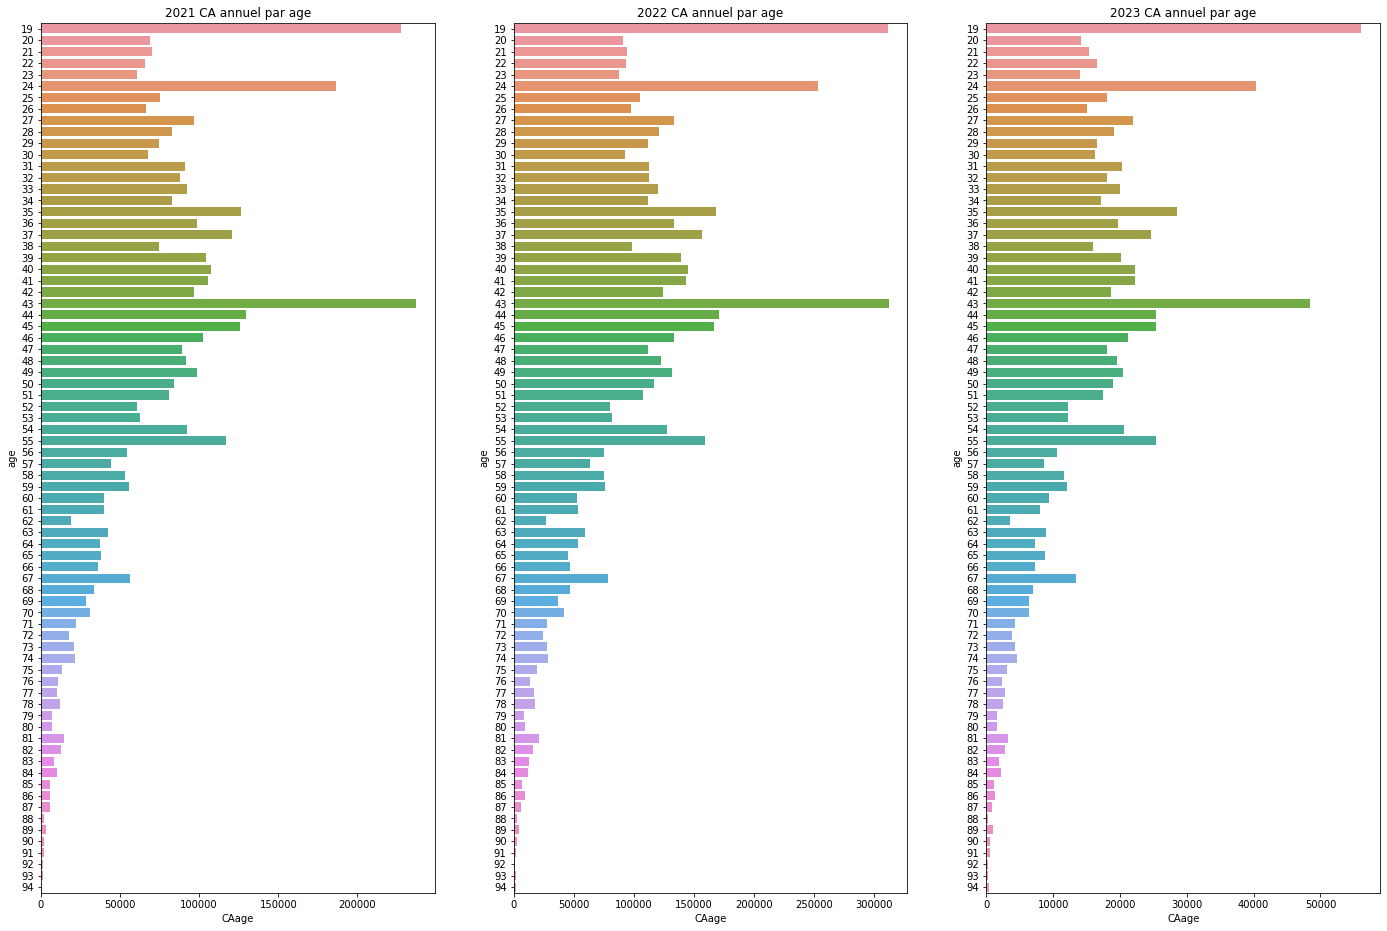

In [68]:
plt.figure(figsize=(24,16))
plt.subplot(131)
sns.barplot(x='CAage',y='age',orient='h',data=CA_age_year[CA_age_year['year']==2021])
plt.title('2021 CA annuel par age')
plt.subplot(132)
sns.barplot(x='CAage',y='age',orient='h',data=CA_age_year[CA_age_year['year']==2022])
plt.title('2022 CA annuel par age')
plt.subplot(133)
sns.barplot(x='CAage',y='age',orient='h',data=CA_age_year[CA_age_year['year']==2023])
plt.title('2023 CA annuel par age')
plt.show()

### 5.4.6 Vérifier CA par l'âge des client par catégorie des produits

In [69]:
#Créer CA_age_categ et calculer le CA par age par catégorie des produits
CA_age_categ=transactions.groupby(['categ','age'],as_index=False)['price'].sum().rename({'price':'CA_age_categ'},axis=1)
CA_age_categ.head()

categ  age  CA_age_categ
0    0.0   19      34650.26
1    0.0   20       8922.74
2    0.0   21      10766.17
3    0.0   22      10235.70
4    0.0   23      11372.96

### Visualiser la répartition de CA par âge par catégorie de produits.
    Les produits de catégorie 0 CA est réalisé principalement par les clients de tranche âge de 32 ans à 51 ans
    Les produits de catégorie 2 CA est réalisé principalement par les clients de tranche âge de 19 ans à 31 ans 
    
    Les produits de catégorie 1: 
                    CA des clients entre 19 et 31 ans sont relativement faible que catégorié 2
                    CA est réalisé principalement par les clients entre 32 et 60 ans.
                    Sa tendance de CA par âge est proche de la situation global, qui est plus équilibre par rapport aux 2 autres catégories.
                    Donc catégorie 1 est plus populaire et a un champs de clientèle plus large.

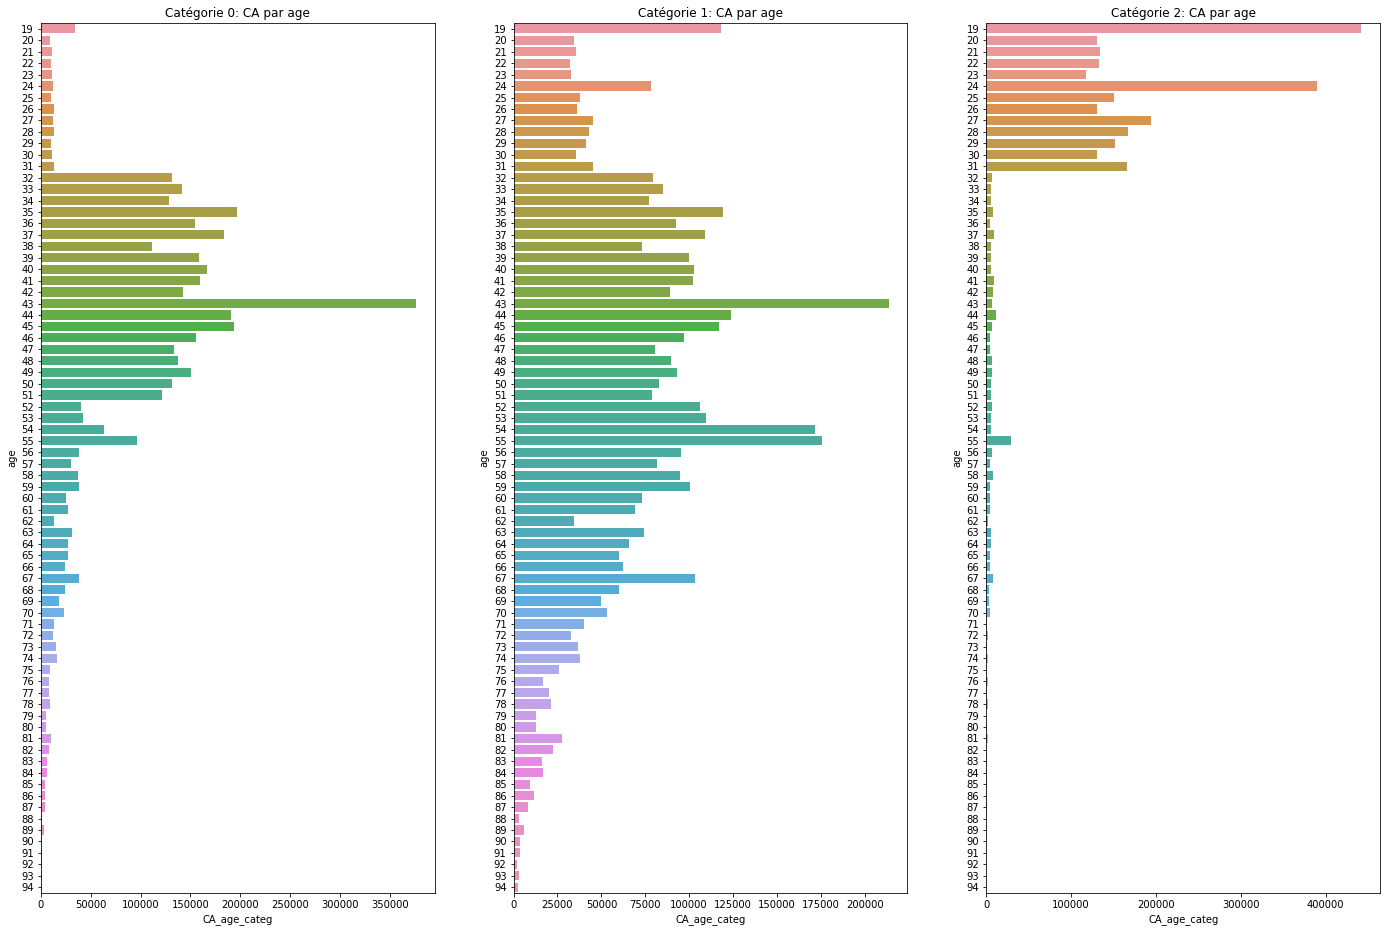

In [70]:
plt.figure(figsize=(24,16))

#Catégorie 0
plt.subplot(131)
sns.barplot(x='CA_age_categ',y='age',orient='h',data=CA_age_categ[CA_age_categ['categ']==0.0])
plt.title('Catégorie 0: CA par age')

#Catégorie 1
plt.subplot(132)
sns.barplot(x='CA_age_categ',y='age',orient='h',data=CA_age_categ[CA_age_categ['categ']==1.0])
plt.title('Catégorie 1: CA par age')

#Catégorie 2
plt.subplot(133)
sns.barplot(x='CA_age_categ',y='age',orient='h',data=CA_age_categ[CA_age_categ['categ']==2.0])
plt.title('Catégorie 2: CA par age')
plt.show()

### 5.4.7 Analyser la relation entre genre, âge, et CA
       CA réalisé par âge entre les clients hommes et femmes sont équilibre excepte quelque âges particulier comme 19 ans  43 ans  24 ans.
       
       En situation global, CA est réalisé principalement avec les clients de moins de 60 ans
       
       En catégorie 0, CA concentre dans les clients de l'âge de 32 ans à 51 ans avec CA entre 50k à 100k par genre.
       
       En catégorie 2, les clients concentre dans les clients de l'âge de 19 ans à 31 ans avec CA entre 50k à 100k par genre.
       
       En catégproe 1, les produits sont plus populaire aux clients de tous les âges comme le cas de la situation global, 
       mais entre 19 ans et 31 ans,CA a une tendance legèrement faible par rapport au cas de situation global.

    

In [71]:
#Créer CA_age_genre avec méthode groupby basé sur transactions pour trouver le CA par age par genre du client
CA_age_genre=transactions.groupby(['sex','age'],as_index=False)['price'].sum().rename({'price':'CAage'},axis=1)

#Créer CA_age_genre_female et CA_age_genre_male pour séparer le CA par age selon le genre du client
CA_age_genre_female=CA_age_genre[CA_age_genre.sex=='f'].rename({'CAage':'CAage_female'},axis=1)
CA_age_genre_male=CA_age_genre[CA_age_genre.sex=='m'].rename({'CAage':'CAage_male'},axis=1)

#Créer CA_age_genre_pivot pour lister CA par age de client femme et CA par age de client homme dans 2 colonnes différentes
CA_age_genre_pivot=pd.merge(CA_age_genre_female,CA_age_genre_male,how='outer',on='age')
CA_age_genre_pivot=CA_age_genre_pivot.drop(['sex_x','sex_y'],axis=1)
CA_age_genre_pivot.head()

age  CAage_female  CAage_male
0   19     306603.99   288496.07
1   20      76863.77    97173.56
2   21      76637.34   103162.22
3   22     102051.25    73172.69
4   23      96118.79    65741.07

In [72]:
#Il n'y a pas des données vides dans le tableau CA_age_genre_pivot

CA_age_genre_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           76 non-null     int64  
 1   CAage_female  76 non-null     float64
 2   CAage_male    76 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


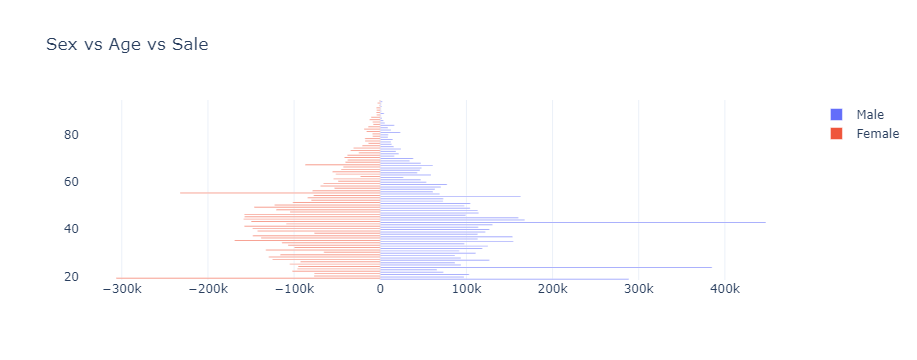

<Figure size 1728x1152 with 0 Axes>

In [73]:
#Utiliser plotly pour affichier la CA par âge de client homme et de client femme dans un seul graphique

y=CA_age_genre_pivot['age']
x1=CA_age_genre_pivot['CAage_male']
x2=CA_age_genre_pivot['CAage_female']*-1

import plotly.graph_objects as go

plt.figure(figsize=(24,16))
fig = go.Figure()
fig.add_trace(go.Bar(y= y, x = x1, 
                     name = 'Male', 
                     orientation = 'h'))

fig.add_trace(go.Bar(y= y, x = x2, 
                     name = 'Female', 
                     orientation = 'h'))
fig.update_layout(template='plotly_white',title='Sex vs Age vs Sale')

fig.show()

### Interpretation de graphique catégorie confondu:
    La répartition de CA entre Homme et Femme par tranche âge sont globalement équivalente.
    La CA sont principalement généré par les clients entre 19 ans et 55 ans.
    Entre 19 et 44 ans, CA est en croissance en fonction d'âge
    A partir de 45 ans, CA est en décroissance.
    
    Il existe quelques âges particulier qui montrent l'inéquilibre:
    A 19ans,24 ans,43 ans, 54 ans, Client Homme a un CA largement important que les CA des autres tranches âges
    A 19ans, 55 ans et 67 ans , Client femme a un CA largement important que les CA des autres tranches âges

### 4.4.9 Analyser la relation entre genre, âge, et CA selon le catégorie des produits

In [74]:

#Créer CA_age_genre_categ pour calculer le CA par age, par genre du client et par catégorie des produits
CA_age_genre_categ=transactions.groupby(['categ','sex','age'],as_index=False)['price'].sum().rename({'price':'CAage'},axis=1)
#Séparer les CA de client femme et CA de client homme dans 2 tableaux 
CA_age_genre_categ_female=CA_age_genre_categ[CA_age_genre_categ.sex=='f'].rename({'CAage':'CAage_female'},axis=1)
CA_age_genre_categ_male=CA_age_genre_categ[CA_age_genre_categ.sex=='m'].rename({'CAage':'CAage_male'},axis=1)



# Créer CA_age_genre_categ0_female et CA_age_genre_categ0_male pour CA par age par genre du client de catégorie 0
CA_age_genre_categ0_female=CA_age_genre_categ_female[CA_age_genre_categ_female.categ==0]
CA_age_genre_categ0_male=CA_age_genre_categ_male[CA_age_genre_categ_male.categ==0]

# Créer CA_age_genre_categ1_female et CA_age_genre_categ1_male pour CA par age par genre du client de catégorie 1
CA_age_genre_categ1_female=CA_age_genre_categ_female[CA_age_genre_categ_female.categ==1]
CA_age_genre_categ1_male=CA_age_genre_categ_male[CA_age_genre_categ_male.categ==1]

# Créer CA_age_genre_categ2_female et CA_age_genre_categ2_male pour CA par age par genre du client de catégorie 2
CA_age_genre_categ2_female=CA_age_genre_categ_female[CA_age_genre_categ_female.categ==2]
CA_age_genre_categ2_male=CA_age_genre_categ_male[CA_age_genre_categ_male.categ==2]





#Créer CA_age_genre_categ0_pivot en mettant CA de femme et homme de catégorie 0 dans 2 colonnes séparées
CA_age_genre_categ0_pivot=pd.merge(CA_age_genre_categ0_female,CA_age_genre_categ0_male,how='outer',on='age')
CA_age_genre_categ0_pivot=CA_age_genre_categ0_pivot.drop(['categ_y','sex_x','sex_y'],axis=1)

#Créer CA_age_genre_categ1_pivot en mettant CA de femme et homme de catégorie 1 dans 2 colonnes séparées
CA_age_genre_categ1_pivot=pd.merge(CA_age_genre_categ1_female,CA_age_genre_categ1_male,how='outer',on='age')
CA_age_genre_categ1_pivot=CA_age_genre_categ1_pivot.drop(['categ_y','sex_x','sex_y'],axis=1)

#Créer CA_age_genre_categ2_pivot en mettant CA de femme et homme de catégorie 2 dans 2 colonnes séparées
CA_age_genre_categ2_pivot=pd.merge(CA_age_genre_categ2_female,CA_age_genre_categ2_male,how='outer',on='age')

#Affichier les premières lignes de 3 tableaux et vérifier les donnes vides de 3 tableaux
display(CA_age_genre_categ0_pivot.head(),CA_age_genre_categ1_pivot.head(),CA_age_genre_categ2_pivot.head())
display(CA_age_genre_categ0_pivot.info(),CA_age_genre_categ1_pivot.info(),CA_age_genre_categ2_pivot.info())

categ_x  age  CAage_female  CAage_male
0      0.0   19      19320.66    15329.60
1      0.0   20       4155.49     4767.25
2      0.0   21       4200.39     6565.78
3      0.0   22       6044.89     4190.81
4      0.0   23       7066.68     4306.28

categ_x  age  CAage_female  CAage_male
0      1.0   19      60964.03    57398.44
1      1.0   20      15940.93    18494.73
2      1.0   21      14955.59    20570.29
3      1.0   22      19202.03    13034.72
4      1.0   23      19067.24    13581.76

categ_x sex_x  age  CAage_female  categ_y sex_y  CAage_male
0      2.0     f   19     226319.30      2.0     m   215768.03
1      2.0     f   20      56767.35      2.0     m    73911.58
2      2.0     f   21      57481.36      2.0     m    76026.15
3      2.0     f   22      76804.33      2.0     m    55947.16
4      2.0     f   23      69984.87      2.0     m    47853.03

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   categ_x       76 non-null     float64
 1   age           76 non-null     int64  
 2   CAage_female  76 non-null     float64
 3   CAage_male    76 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 3.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   categ_x       76 non-null     float64
 1   age           76 non-null     int64  
 2   CAage_female  76 non-null     float64
 3   CAage_male    76 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 3.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  

None

None

None

#### Traitement des données vides de CA_age_genre_categ2_pivot
    Le tableau de catégorie 0 et catégorie 1 n'ont pas des données vides.
    En revanche, le tableau de catégorie 2 avec 76 âges, il y a seulement 75 données pour le client femme et 69 données pour le client homme

In [75]:
#Donnée manquante de client femme dans le tableau catégorie 2
CA_age_genre_categ2_pivot[CA_age_genre_categ2_pivot['CAage_female'].isna()==True]

categ_x sex_x  age  CAage_female  categ_y sex_y  CAage_male
75      NaN   NaN   94           NaN      2.0     m      145.99

In [76]:
#Donnée manquante de client homme dans le tableau catégorie 2
CA_age_genre_categ2_pivot[CA_age_genre_categ2_pivot['CAage_male'].isna()==True]

categ_x sex_x  age  CAage_female  categ_y sex_y  CAage_male
60      2.0     f   79        149.97      NaN   NaN         NaN
64      2.0     f   83        738.18      NaN   NaN         NaN
69      2.0     f   88        135.14      NaN   NaN         NaN
71      2.0     f   90         49.61      NaN   NaN         NaN
72      2.0     f   91        121.92      NaN   NaN         NaN
73      2.0     f   92         86.70      NaN   NaN         NaN
74      2.0     f   93        111.98      NaN   NaN         NaN

In [77]:
#Remplir les données des clients femmes manquantes
CA_age_genre_categ2_pivot['categ_x'].fillna(2.0,inplace=True)
CA_age_genre_categ2_pivot['CAage_female'].fillna(0,inplace=True)

#Remplir les données des clients hommes manquantes
CA_age_genre_categ2_pivot['CAage_male'].fillna(0,inplace=True)

#Reformuler le tableau CA_age_genre_categ2_pivot (garder categ_x comme categ, en supprimant les 3 autres colonnes non utiles) 
CA_age_genre_categ2_pivot=CA_age_genre_categ2_pivot.drop(['sex_x','sex_y','categ_y'],axis=1)
CA_age_genre_categ2_pivot=CA_age_genre_categ2_pivot.rename({'categ_x':'categ'},axis=1)

#Affucguer les premières lignes et les infos de CA_age_genre_categ2_pivot
display(CA_age_genre_categ2_pivot.info(),CA_age_genre_categ2_pivot.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   categ         76 non-null     float64
 1   age           76 non-null     int64  
 2   CAage_female  76 non-null     float64
 3   CAage_male    76 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 3.0 KB


None

categ  age  CAage_female  CAage_male
0    2.0   19     226319.30   215768.03
1    2.0   20      56767.35    73911.58
2    2.0   21      57481.36    76026.15
3    2.0   22      76804.33    55947.16
4    2.0   23      69984.87    47853.03

### Graphique de catégorie 0

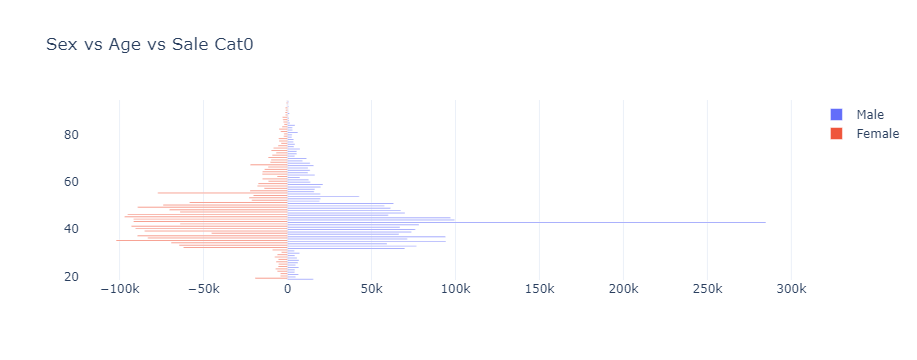

<Figure size 1728x1152 with 0 Axes>

In [78]:
y=CA_age_genre_categ0_pivot['age']
x1=CA_age_genre_categ0_pivot['CAage_male']
x2=CA_age_genre_categ0_pivot['CAage_female']*-1

import plotly.graph_objects as go

plt.figure(figsize=(24,16))
fig = go.Figure()
fig.add_trace(go.Bar(y= y, x = x1, 
                     name = 'Male', 
                     orientation = 'h'))

fig.add_trace(go.Bar(y= y, x = x2, 
                     name = 'Female', 
                     orientation = 'h'))
fig.update_layout(template='plotly_white',title='Sex vs Age vs Sale Cat0')

fig.show()


### Interpretation de graphique catégorie 0:

    Catégorie 0 réalise le chiffre d'affaire principalement avec les clients de tranche âge 32 ans et 51 ans.
    Homme de 43 ans a réalisé un CA important par rapport aux autres tranches âge
    Femme de 55 ans a réalisé un CA important également par rapport au homme de même âge et aux âges voisines de client femme
    

### Graphique de catégorie 1

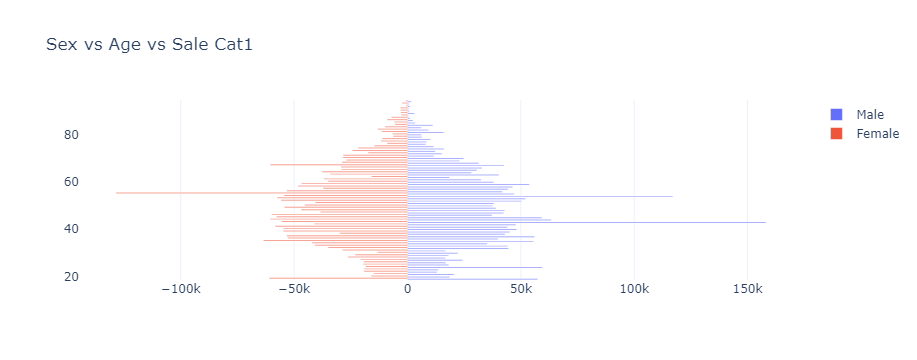

<Figure size 1728x1152 with 0 Axes>

In [79]:
y=CA_age_genre_categ1_pivot['age']
x1=CA_age_genre_categ1_pivot['CAage_male']
x2=CA_age_genre_categ1_pivot['CAage_female']*-1

import plotly.graph_objects as go

plt.figure(figsize=(24,16))
fig = go.Figure()
fig.add_trace(go.Bar(y= y, x = x1, 
                     name = 'Male', 
                     orientation = 'h'))

fig.add_trace(go.Bar(y= y, x = x2, 
                     name = 'Female', 
                     orientation = 'h'))
fig.update_layout(template='plotly_white',title='Sex vs Age vs Sale Cat1')

fig.show()


### Interpretation de graphique catégorie 1:

    La tendance de la distribution de CA en catégorie 1 est similaire de la graphique de la situation globale.
    
    Ses produits sont populaires pour tous les tranches âges.
    CA est legèrement faible pour les clients entre 19 ans et 31 ans en comparant la graphique de la situation global.
    
    Les clients entre 31 ans et 68 ans contribue plus de CA dans le catégorie 1.


### Graphique de catégorie 2

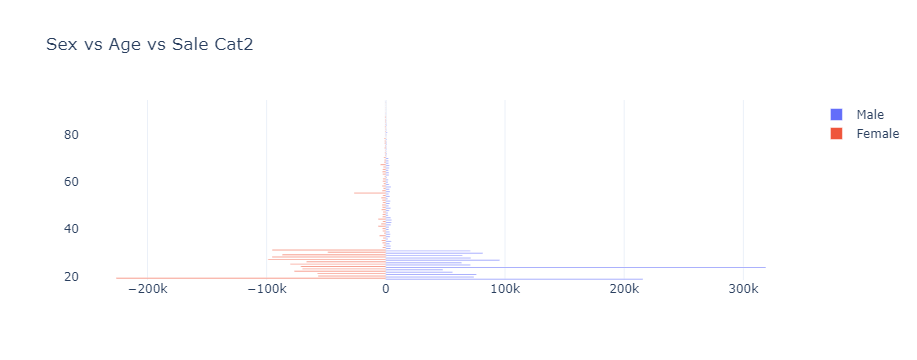

<Figure size 1728x1152 with 0 Axes>

In [80]:
y=CA_age_genre_categ2_pivot['age']
x1=CA_age_genre_categ2_pivot['CAage_male']
x2=CA_age_genre_categ2_pivot['CAage_female']*-1

import plotly.graph_objects as go

plt.figure(figsize=(24,16))
fig = go.Figure()
fig.add_trace(go.Bar(y= y, x = x1, 
                     name = 'Male', 
                     orientation = 'h'))

fig.add_trace(go.Bar(y= y, x = x2, 
                     name = 'Female', 
                     orientation = 'h'))
fig.update_layout(template='plotly_white',title='Sex vs Age vs Sale Cat2')

fig.show()

### Interpretation de graphique catégorie 2:    
      
    Le client de tranche âge entre 19 ans et 31 ans contribue plus de CA que les autres âges.
    Les CA par âge par genre est principalement entre cette tranche est entre 50k et 100k.
    
    Les clients de 19 ans dans les hommes et les femmes ont réalisé un CA important (+200k par genre).
    
    Homme de 24 ans réalise un CA le plus important par rapport aux autres tranches âges(+300k).
    
    Femme de 55 ans réalise un CA de 26k largement important que les âges voisines (2 ou 3 k).

## 5.5 Analyser de la concentration client par rapport à CA réalisé avec le graphique Lorenz

    La concentration de CA par rapport au client, âge, année de transaction, genre sont tous avec une inégalité relativement faible avec les coéfficients GINI entre 0.40 et 0.50.
    
    En revanche, les coéfficients GINI de lorenz pour la concentration de CA par rapport à l'âge dans la catégorie 0 et 1 sont importants entre 0.61 et 0.8. il est cohérent avec l'inégalité de la  distribution de CA par âge qu'on a vue dans les graphiques précédants.
    
    En 2023, la concentration de CA par rapport aux client est avec une coéfficient GINI de 0.58, il est relativement important que les 2 années précédentes.
    
    Comme c'est une année imcomplete, il est mieux de revoir l'indice à la fin de la période.
    


### 5.5.1 Analyser la concentration de CA en fonction des clients
    
    Le niveau de l'inégalité dans la concentration CA par rapport aux clients est  avec une coéfficient GINI de 0.45

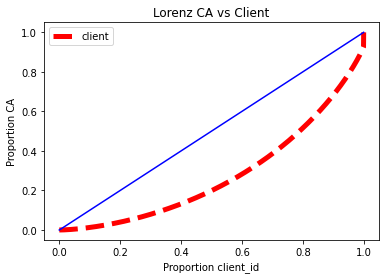

La coéfficient GINI pour la concentration de vente en fonction de client id est: 0.45


In [81]:
Lorenz_prod=transactions.groupby('client_id',as_index=False).price.sum().rename({'price':'CAclient'},axis=1)

#Calculer CA cumulative et porportion de id_prod avec toutes les catégories confondues
Lorenz_client=Lorenz_prod.sort_values('CAclient',ascending=False)
CAclient=Lorenz_prod['CAclient'].values
n=len(CAclient)
lorenz=np.cumsum(np.sort(CAclient))/CAclient.sum()
lorenz=np.append([0],lorenz)

#Graphique lorenz

x=np.linspace(0-1/n,1+1/n,n+1)

plt.plot(x,lorenz,'r--',lw=5,label='client')

plt.plot(x,x,c='b')

plt.legend()

plt.title('Lorenz CA vs Client')
plt.xlabel('Proportion client_id')
plt.ylabel('Proportion CA')
plt.show()



#Calculer GINI 
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC
gini_client = round(2*S,2)
print('La coéfficient GINI pour la concentration de vente en fonction de client id est:',gini_client)

### 5.5.2 Concentration des clients par rapport à CA  par année
    L'inégalité de la concentration de CA en fonction des client en 2021 est avec une coéfficient GINI de 0.45
    L'inégalité de la concentration de CA en fonction des client en 2022 est avec une coéfficient GINI de 0.46
    L'inégalité de la concentration de CA en fonction des client en 2023 est avec une coéfficient GINI de 0.58

In [82]:
CA_Client_Year=transactions.groupby(['year','client_id'],as_index=False).price.sum().rename({'price':'CA'},axis=1)
CA_Client_Year=pd.crosstab(CA_Client_Year['client_id'],
            CA_Client_Year['year'],
            CA_Client_Year['CA'],aggfunc='sum'
           ).reset_index().rename({2021:'CA 2021',2022:'CA 2022',2023:'CA 2023'},axis=1).fillna(0)
CA_Client_Year.head()

year client_id  CA 2021  CA 2022  CA 2023
0          c_1   286.67   219.23    44.29
1         c_10   586.18   602.93   164.49
2        c_100   222.87    31.98     0.00
3       c_1000   691.86  1467.14    92.90
4       c_1001   953.98   669.70   143.59

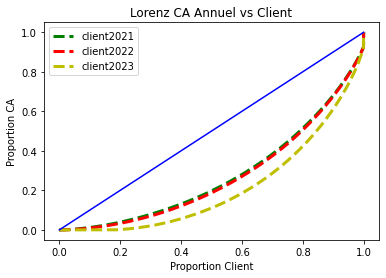

La coéfficient GINI pour la concentration de dépense en fonction des client en 2021 est: 0.45
La coéfficient GINI pour la concentration de dépense en fonction des client en 2022 est: 0.46
La coéfficient GINI pour la concentration de dépense en fonction des client en 2023 est: 0.58


In [83]:


# Calculer CA cumultative de CA annuel par client
CAClientYear2021=CA_Client_Year.sort_values('CA 2021',ascending=False)
CAclient2021=CAClientYear2021['CA 2021'].values
n_client=len(CAclient2021)
lorenz_client2021=np.cumsum(np.sort(CAclient2021))/CAclient2021.sum()
lorenz_client2021=np.append([0],lorenz_client2021)


CAClientYear2022=CA_Client_Year.sort_values('CA 2022',ascending=False)
CAclient2022=CAClientYear2022['CA 2022'].values
n_client=len(CAclient2022)
lorenz_client2022=np.cumsum(np.sort(CAclient2022))/CAclient2022.sum()
lorenz_client2022=np.append([0],lorenz_client2022)



CAClientYear2023=CA_Client_Year.sort_values('CA 2023',ascending=False)
CAclient2023=CAClientYear2023['CA 2023'].values
n_client=len(CAclient2023)
lorenz_client2023=np.cumsum(np.sort(CAclient2023))/CAclient2023.sum()
lorenz_client2023=np.append([0],lorenz_client2023)


#Définir x de graphique
x=np.linspace(0-1/n_client,1+1/n_client,n_client+1)

#Affichier les courbes lorenz dans un graphique
plt.plot(x,lorenz_client2021,'g--',lw=3,label='client2021')

plt.plot(x,lorenz_client2022,'r--',lw=3,label='client2022')
plt.plot(x,lorenz_client2023,'y--',lw=3,label='client2023')

plt.plot(x,x,c='b')
plt.legend()
plt.title('Lorenz CA Annuel vs Client')
plt.xlabel('Proportion Client')
plt.ylabel('Proportion CA')
plt.show()





#Calculer GINI de CA annuel par client
AUC_client2021 = (lorenz_client2021.sum() -lorenz_client2021[-1]/2 -lorenz_client2021[0]/2)/n_client
S_client2021 = 0.5 - AUC_client2021
gini_client2021 = round(2*S_client2021,2)
print('La coéfficient GINI pour la concentration de dépense en fonction des client en 2021 est:',gini_client2021)

AUC_client2022 = (lorenz_client2022.sum() -lorenz_client2022[-1]/2 -lorenz_client2022[0]/2)/n_client
S_client2022 = 0.5 - AUC_client2022
gini_client2022 = round(2*S_client2022,2)
print('La coéfficient GINI pour la concentration de dépense en fonction des client en 2022 est:',gini_client2022)

AUC_client2023 = (lorenz_client2023.sum() -lorenz_client2023[-1]/2 -lorenz_client2023[0]/2)/n_client
S_client2023 = 0.5 - AUC_client2023
gini_client2023= round(2*S_client2023,2)
print('La coéfficient GINI pour la concentration de dépense en fonction des client en 2023 est:',gini_client2023)

### 5.5.3 Analyser la concentration de âge des client par rapport à CA  et en fonction de catégorie des produits
    
    Dans Catégorie 0 et Catégorie 2,l'inégalité de la distribution CA par rapport à l'âge des client sont important avec une coéfficient de GINI 0.6 et 0.8.
    
    Dans Catégorie 1, l'inégalité est plus faible que les 2 autres catégories avec une coéfficient GINI de 0.45, 
    qui est proche de l'inégalité dans la distribution CA par rapport à l'âge de tous catégorie confondu (Gini 0.4)

In [84]:
#créer CA_age_categ_lorenze pour calculer le CA par age des clients et par catégorie des produits
CA_age_categ_lorenze=transactions.groupby(['categ','age'],as_index=False)['price'].sum().rename({'price':'CAage'},axis=1)
display(CA_age_categ_lorenze.head())

#Créer CA_age_categ0_lorenze,CA_age_categ1_lorenze,CA_age_categ2_lorenze pour calculer  le CA par age des clients et par catégorie des produits de chaque catégorie
CA_age_categ0_lorenze=CA_age_categ_lorenze[CA_age_categ_lorenze.categ==0.0].rename({'CAage':'CAage_cat0'},axis=1)
CA_age_categ1_lorenze=CA_age_categ_lorenze[CA_age_categ_lorenze.categ==1.0].rename({'CAage':'CAage_cat1'},axis=1)
CA_age_categ2_lorenze=CA_age_categ_lorenze[CA_age_categ_lorenze.categ==2.0].rename({'CAage':'CAage_cat2'},axis=1)

#Créer CA_age_categ_lorenze_joint, affichier CA par age des clients et par catégorie des produits de chaque catégorie dans 3 colonnes différentes
CA_age_categ_lorenze_joint=pd.merge(CA_age_categ0_lorenze,CA_age_categ1_lorenze,how='outer',on='age')
CA_age_categ_lorenze_joint=pd.merge(CA_age_categ_lorenze_joint,CA_age_categ2_lorenze,how='outer',on='age')
display(CA_age_categ_lorenze_joint.head(),CA_age_categ_lorenze_joint.info())

categ  age     CAage
0    0.0   19  34650.26
1    0.0   20   8922.74
2    0.0   21  10766.17
3    0.0   22  10235.70
4    0.0   23  11372.96

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categ_x     76 non-null     float64
 1   age         76 non-null     int64  
 2   CAage_cat0  76 non-null     float64
 3   categ_y     76 non-null     float64
 4   CAage_cat1  76 non-null     float64
 5   categ       76 non-null     float64
 6   CAage_cat2  76 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 4.8 KB


categ_x  age  CAage_cat0  categ_y  CAage_cat1  categ  CAage_cat2
0      0.0   19    34650.26      1.0   118362.47    2.0   442087.33
1      0.0   20     8922.74      1.0    34435.66    2.0   130678.93
2      0.0   21    10766.17      1.0    35525.88    2.0   133507.51
3      0.0   22    10235.70      1.0    32236.75    2.0   132751.49
4      0.0   23    11372.96      1.0    32649.00    2.0   117837.90

None

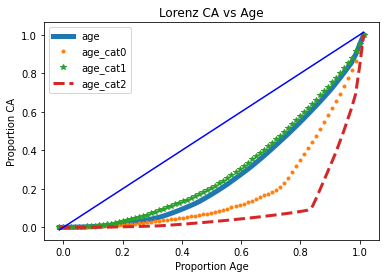

La coéfficient GINI pour la concentration de dépense en fonction d'âge de client est: 0.45
La coéfficient GINI pour la concentration de dépense en fonction d'âge de client en catégorie 0 est: 0.61
La coéfficient GINI pour la concentration de dépense en fonction d'âge de client en catégorie 1 est: 0.4
La coéfficient GINI pour la concentration de dépense en fonction d'âge de client en catégorie 2 est: 0.8


In [85]:

#Calculer CA cumulative et porportion d'âge avec toutes les catégories confondues
CA_age=CA_age.sort_values('CAage',ascending=False)
CAage=CA_age['CAage'].values
n=len(CAage)
lorenz=np.cumsum(np.sort(CAage))/CAage.sum()
lorenz=np.append([0],lorenz)


#Calculer CA cumulative et porportion d'âge de catégorie 0
CAageCat0=CA_age_categ_lorenze_joint.sort_values('CAage_cat0',ascending=False)
CAage_cat0=CAageCat0['CAage_cat0'].values
n=len(CAage_cat0)
lorenz_cat0=np.cumsum(np.sort(CAage_cat0))/CAage_cat0.sum()
lorenz_cat0=np.append([0],lorenz_cat0)


#Calculer CA cumulative et porportion d'âge de catégorie 1
CAageCat1=CA_age_categ_lorenze_joint.sort_values('CAage_cat1',ascending=False)
CAage_cat1=CAageCat1['CAage_cat1'].values
n=len(CAage_cat1)
lorenz_cat1=np.cumsum(np.sort(CAage_cat1))/CAage_cat1.sum()
lorenz_cat1=np.append([0],lorenz_cat1)


#Calculer CA cumulative et porportion d'age de catégorie 2
CAageCat2=CA_age_categ_lorenze_joint.sort_values('CAage_cat2',ascending=False)
CAage_cat2=CAageCat2['CAage_cat2'].values
n=len(CAage_cat2)
lorenz_cat2=np.cumsum(np.sort(CAage_cat2))/CAage_cat2.sum()
lorenz_cat2=np.append([0],lorenz_cat2)

#Définir x de graphique, et affichier les lignes de lorenz de catégorie confondue et chaque catégorie individue dans un graphique
x=np.linspace(0-1/n,1+1/n,n+1)

plt.plot(x,lorenz,'-',lw=5,label='age')
plt.plot(x,lorenz_cat0,'.',lw=3,label='age_cat0')
plt.plot(x,lorenz_cat1,'*',lw=3,label='age_cat1')
plt.plot(x,lorenz_cat2,'--',lw=3,label='age_cat2')
plt.plot(x,x,c='b')
plt.legend()
plt.title('Lorenz CA vs Age')
plt.xlabel('Proportion Age')
plt.ylabel('Proportion CA')
plt.show()



#Calculer GINI de catégorie confondue
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC
gini_age = round(2*S,2)
print('La coéfficient GINI pour la concentration de dépense en fonction d\'âge de client est:',gini_age)

#Calculer GINI de catégorie 0
AUC = (lorenz_cat0.sum() -lorenz_cat0[-1]/2 -lorenz_cat0[0]/2)/n
S = 0.5 - AUC
gini_age_cat0 = round(2*S,2)
print('La coéfficient GINI pour la concentration de dépense en fonction d\'âge de client en catégorie 0 est:',gini_age_cat0)

#Calculer GINI de catégorie 1
AUC = (lorenz_cat1.sum() -lorenz_cat1[-1]/2 -lorenz_cat1[0]/2)/n
S = 0.5 - AUC
gini_age_cat1 = round(2*S,2)
print('La coéfficient GINI pour la concentration de dépense en fonction d\'âge de client en catégorie 1 est:',gini_age_cat1)

#Calculer GINI de catégorie 2
AUC = (lorenz_cat2.sum() -lorenz_cat2[-1]/2 -lorenz_cat2[0]/2)/n
S = 0.5 - AUC
gini_age_cat2 = round(2*S,2)
print('La coéfficient GINI pour la concentration de dépense en fonction d\'âge de client en catégorie 2 est:',gini_age_cat2)

### 5.5.4 La concentration de client par rapport à CA selon genre
    l'inégalité de la distribution CA pour clients homme sont avec une coéfficient Gini de 0.48 
    qui est legèrement important que la coéfficient Gini pour les clients femmes 0.42.

In [86]:
CA_Client_Genre=transactions.groupby(['sex','client_id'],as_index=False).price.sum().rename({'price':'CA'},axis=1)
display(CA_Client_Genre.head())

CA_client_homme=CA_Client_Genre[CA_Client_Genre['sex']=='m'].sort_values('CA',ascending=False)
CA_client_femme=CA_Client_Genre[CA_Client_Genre['sex']=='f'].sort_values('CA',ascending=False)



sex client_id       CA
0   f    c_1000  2251.90
1   f    c_1002   326.19
2   f    c_1005   827.98
3   f    c_1007   424.97
4   f    c_1009   513.82

La coéfficient GINI pour la concentration de dépense femme est: 0.42
La coéfficient GINI pour la concentration de dépense homme est: 0.48


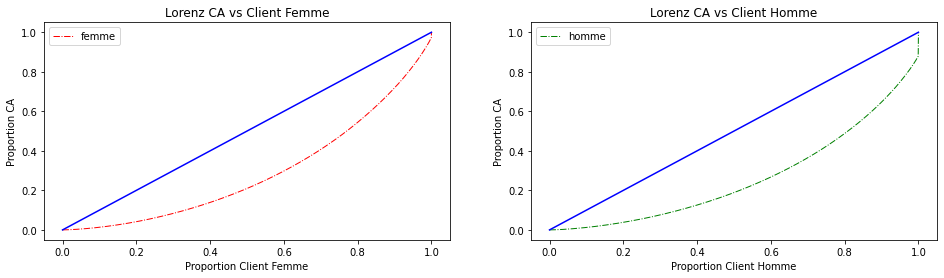

In [87]:


CAclientfemme=CA_client_femme['CA'].values
n_clientfemme=len(CAclientfemme)
lorenz_clientfemme=np.cumsum(np.sort(CAclientfemme))/CAclientfemme.sum()
lorenz_clientfemme=np.append([0],lorenz_clientfemme)
x_femme=np.linspace(0-1/n_clientfemme,1+1/n_clientfemme,n_clientfemme+1)


CAclienthomme=CA_client_homme['CA'].values
n_clienthomme=len(CAclienthomme)
lorenz_clienthomme=np.cumsum(np.sort(CAclienthomme))/CAclienthomme.sum()
lorenz_clienthomme=np.append([0],lorenz_clienthomme)
x_homme=np.linspace(0-1/n_clienthomme,1+1/n_clienthomme,n_clienthomme+1)


#Lorenz Client femme


#Gini Femme

AUC_clientfemme = (lorenz_clientfemme.sum() -lorenz_clientfemme[-1]/2 -lorenz_clientfemme[0]/2)/n_clientfemme
S_clientfemme = 0.5 - AUC_clientfemme
gini_clientfemme= round(2*S_clientfemme,2)
print('La coéfficient GINI pour la concentration de dépense femme est:',gini_clientfemme)

#Gini Homme
AUC_clienthomme = (lorenz_clienthomme.sum() -lorenz_clienthomme[-1]/2 -lorenz_clienthomme[0]/2)/n_clienthomme
S_clienthomme = 0.5 - AUC_clienthomme
gini_clienthomme= round(2*S_clienthomme,2)
print('La coéfficient GINI pour la concentration de dépense homme est:',gini_clienthomme)



plt.figure(figsize=(16,4))

plt.subplot(121)

plt.plot(x_femme,lorenz_clientfemme,'r-.',lw=1,label='femme')
plt.plot(x_femme,x_femme,c='b')
plt.legend()
plt.title('Lorenz CA vs Client Femme')
plt.xlabel('Proportion Client Femme')
plt.ylabel('Proportion CA')


#Lorenz Client homme

plt.subplot(122)
plt.plot(x_homme,lorenz_clienthomme,'g-.',lw=1,label='homme')
plt.plot(x_homme,x_homme,c='b')
plt.legend()

plt.title('Lorenz CA vs Client Homme')
plt.xlabel('Proportion Client Homme')
plt.ylabel('Proportion CA')
plt.show()




# PARTIE 3 Une analyse plus ciblée sur les clients et comprendre le comportement de nos clients en ligne via certaines corrélations

# 1. le lien entre le genre d’un client et les catégories des livres achetés
    
    Le genre de client et les catégories des livres achetés sont tous  les deux les variables qualitatives, 
    donc, nous devons appliquer le test CHI2 pour confirmer la relation entre ces 2 variables.
    
    Résultat de test CHI2:
        P_value < 0.05, 
        CHI2 139 >Valeur critique 5.99
        donc on rejette la hypothèse 0, il y a bien une corrélation entre ces 2 variables.

## 1.1 Construire les tableaux de contingence CHI2 basé sur le tableau transactions

In [88]:
#Selectionner seulement 2 colonnes des 2 variables dans transactions
transactions_prepaCHI2=transactions[['sex','categ']]
display(transactions_prepaCHI2.head())

#Utiliser cross tab pour créer le tableau de contingence CHI2
tableau_CHI2=pd.crosstab(transactions_prepaCHI2.sex,transactions_prepaCHI2.categ,values=transactions_prepaCHI2.categ,aggfunc='count')

#Reformuler le tableau de contingence CHI2
tableau_CHI2=tableau_CHI2.reset_index()
tableau_CHI2=tableau_CHI2.rename({0.0:'Catégorie0',1.0:'Catégorie1',2.0:'Catégorie2'},axis=1)
tableau_CHI2.head()

sex  categ
0   f    0.0
1   m    1.0
2   f    0.0
3   m    2.0
4   m    0.0

categ sex  Catégorie0  Catégorie1  Catégorie2
0       f      198537      114899       16830
1       m      201277      112270       18681

## 1.2 Visualisation de tableau contingence CHI2

### Visualiser la répartition de la fréquence des catégories des produits par les genres du client

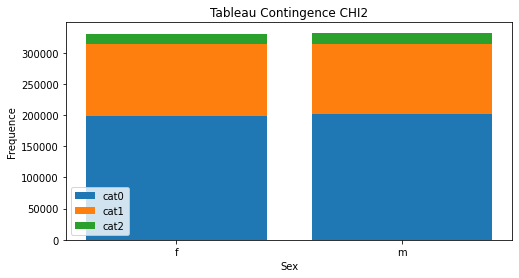

In [89]:
y0=tableau_CHI2['Catégorie0']
y1=tableau_CHI2['Catégorie1']
y2=tableau_CHI2['Catégorie2']
x0=tableau_CHI2['sex']


fig,ax=plt.subplots(figsize=(8,4))

ax.bar(x0,y0,label='cat0')
ax.bar(x0,y1,bottom=y0,label='cat1')
ax.bar(x0,y2,bottom=y0+y1,label='cat2')

plt.legend()
plt.ylabel('Frequence')
plt.xlabel('Sex')
plt.title('Tableau Contingence CHI2')
plt.show()

### visualiser la répartition de la fréquence de genre de client par catégorie des produits

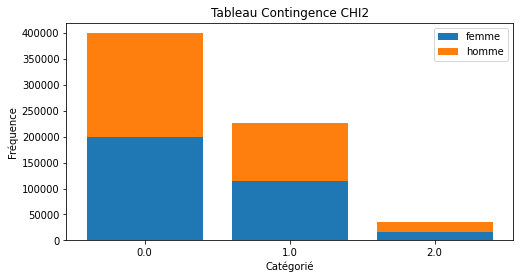

In [90]:
tableau_CHI2b=pd.crosstab(transactions_prepaCHI2.categ,transactions_prepaCHI2.sex,values=transactions_prepaCHI2.categ,aggfunc='count').reset_index()
tableau_CHI2b

fig,ax=plt.subplots(figsize=(8,4))
x0=tableau_CHI2b['categ'].astype(str)
y0=tableau_CHI2b['f']
y1=tableau_CHI2b['m']

ax.bar(x0,y0,label='femme')
ax.bar(x0,y1,bottom=y0,label='homme')

plt.legend()
plt.ylabel('Fréquence')
plt.xlabel('Catégorié')
plt.title('Tableau Contingence CHI2')
plt.show()

## 1.3 Test CHI2

### Hypothèse de Test CHI2:
    H0: le genre d’un client et les catégories des livres achetés sont indépendants, il n'y a pas de la corrélation entre ces 2 variables
    H1: le genre d’un client et les catégories des livres achetés ne sont pas indépendants, il y a la corrélation entre ces 2 variables


### Test CHI2 et Calculer P_value, CHI2 valeur, Dégré de liberté et valeur critique de CHI2

In [91]:
from scipy import stats
chi2, p, dof, ex = stats.chi2_contingency(tableau_CHI2.iloc[:,1:4], correction=False)

print('CHI2 est',chi2)

print('dégré de liberté est:',dof)

print('p-value est:',p)

print('Avec la dégré de liberté de 2 et p_valeur de 0.05,valeur critique CHI2 est :', stats.chi2.ppf(0.95, 2))


CHI2 est 139.87633888758538
dégré de liberté est: 2
p-value est: 4.229012181788962e-31
Avec la dégré de liberté de 2 et p_valeur de 0.05,valeur critique CHI2 est : 5.991464547107979


### Conclusion de test CHI2: le genre du client et la catégorie des livrés achetés sont corrélé.
    p_value 4.2290-31 < 0.05
    139.87 > Valeur Critique 5.99 de CHI2
    Donc, les 2 variable sont indépendants, on rejette la hypothèse H0, il existe une corrélation entre le genre du client et la catégorie des livrés achetés.

# 2.le lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés

## 2.1 Première vision des Corrélation  entre les variables via heatmap. 

### 2.1.1 Construire un tableau qui contient tous les variables

    l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen sont les variables quantitatives
    les catégories des livres achetés est une variable qualitative, ici on va le transformer en nombre de livre d'acheté par catégorie.
    Tous les variables cités ci dessus sont liés au client, donc on va voir la situation de heatmap à niveau du client puis au niveau d'âge du client.

#### Calculer le montant total d'achat, la fréquence d'achat par client

In [92]:
#Créer Client_Montant_Achat pour calculer CA par client
Client_Montant_Achat=transactions.groupby(['client_id','age'],as_index=False).price.sum().rename({'price':'Montant total des achats'},axis=1)
#Créer Client_Frequencce pour calculer la fréquence d'achat par client
Client_Frequence_Achat=transactions.groupby(['client_id'],as_index=False).session_id.count().rename({'session_id':'Fréquence Achat'},axis=1)
#Affichier les informations de 2 tableaux créés (il n'y a pas des données vides)
display(Client_Montant_Achat.info(),Client_Frequence_Achat.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8599 entries, 0 to 8598
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 8599 non-null   object 
 1   age                       8599 non-null   int64  
 2   Montant total des achats  8599 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 268.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   client_id        8599 non-null   object
 1   Fréquence Achat  8599 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 201.5+ KB


None

None

#### Calculer Montant panier moyen par client

In [93]:

#Créer Client_Data pour joindre Client_Montant_Achat et Client_Frequence_Achat avec le clés client_id
Client_Data=pd.merge(Client_Montant_Achat,Client_Frequence_Achat,how='left',on='client_id')
#Créer colonne 'Montant Panier Moyen' en divisant 'Montant total des achats' par 'Fréquence Achat'
Client_Data['Montant Panier Moyen']=round(Client_Data['Montant total des achats']/Client_Data['Fréquence Achat'],2)
Client_Data.head()

client_id  age  Montant total des achats  Fréquence Achat  \
0       c_1   68                    550.19               38   
1      c_10   67                   1353.60               58   
2     c_100   31                    254.85                8   
3    c_1000   57                   2251.90              124   
4    c_1001   41                   1767.27               99   

   Montant Panier Moyen  
0                 14.48  
1                 23.34  
2                 31.86  
3                 18.16  
4                 17.85

#### Calculer Nombre des livres acheté par catégorie par client

In [94]:
#calculer le nombre de livres de catégorie 0 acheté par client 
Client_Nombre_Achat_Cat0=transactions[transactions.categ==0.0].groupby(['client_id'],as_index=False).categ.count().rename({'categ':'Nombre_Achat_Cat0'},axis=1)
#calculer le nombre de livres de catégorie 1 acheté par client 
Client_Nombre_Achat_Cat1=transactions[transactions.categ==1.0].groupby(['client_id'],as_index=False).categ.count().rename({'categ':'Nombre_Achat_Cat1'},axis=1)
#calculer le nombre de livres de catégorie 2 acheté par client 
Client_Nombre_Achat_Cat2=transactions[transactions.categ==2.0].groupby(['client_id'],as_index=False).categ.count().rename({'categ':'Nombre_Achat_Cat2'},axis=1)
display(Client_Nombre_Achat_Cat0.head(),Client_Nombre_Achat_Cat1.head(),Client_Nombre_Achat_Cat2.head())

client_id  Nombre_Achat_Cat0
0       c_1                 29
1      c_10                 20
2     c_100                  2
3    c_1000                 42
4    c_1001                 67

client_id  Nombre_Achat_Cat1
0       c_1                  8
1      c_10                 34
2     c_100                  5
3    c_1000                 82
4    c_1001                 31

client_id  Nombre_Achat_Cat2
0       c_1                  1
1      c_10                  4
2     c_100                  1
3    c_1001                  1
4    c_1009                  5

#### Mettre tous les variables dans un seul tableau selon client_id
#### Affichier le tableau final

In [95]:
#Dans Client_Data, récupérer le nombre de livres achetées par catégories
Client_Data=pd.merge(Client_Data,Client_Nombre_Achat_Cat0,how='left',on='client_id').fillna(0)
Client_Data=pd.merge(Client_Data,Client_Nombre_Achat_Cat1,how='left',on='client_id').fillna(0)
Client_Data=pd.merge(Client_Data,Client_Nombre_Achat_Cat2,how='left',on='client_id').fillna(0)
display(Client_Data.info(),Client_Data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8599 entries, 0 to 8598
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 8599 non-null   object 
 1   age                       8599 non-null   int64  
 2   Montant total des achats  8599 non-null   float64
 3   Fréquence Achat           8599 non-null   int64  
 4   Montant Panier Moyen      8599 non-null   float64
 5   Nombre_Achat_Cat0         8599 non-null   float64
 6   Nombre_Achat_Cat1         8599 non-null   float64
 7   Nombre_Achat_Cat2         8599 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 604.6+ KB


None

client_id  age  Montant total des achats  Fréquence Achat  \
0       c_1   68                    550.19               38   
1      c_10   67                   1353.60               58   
2     c_100   31                    254.85                8   
3    c_1000   57                   2251.90              124   
4    c_1001   41                   1767.27               99   

   Montant Panier Moyen  Nombre_Achat_Cat0  Nombre_Achat_Cat1  \
0                 14.48               29.0                8.0   
1                 23.34               20.0               34.0   
2                 31.86                2.0                5.0   
3                 18.16               42.0               82.0   
4                 17.85               67.0               31.0   

   Nombre_Achat_Cat2  
0                1.0  
1                4.0  
2                1.0  
3                0.0  
4                1.0

### 2.1.2 Visualiser la corrélation entre les variables par heatmap (niveau client_id)

#### Calculer les corrélations entre les variables

In [96]:
#Créer Client_Data_Correlation pour selectionner les données de Client_Data sauf client_id
Client_Data_Correlation=Client_Data.iloc[:,1:]
#Calculer corrélation des variables en les mettant dans un nouveau tableau Correlation
Correlation=Client_Data_Correlation.corr()
#Affichier le tableau d'origine et le tableau de corrélation
display(Client_Data_Correlation.head(),Correlation.head())

age  Montant total des achats  Fréquence Achat  Montant Panier Moyen  \
0   68                    550.19               38                 14.48   
1   67                   1353.60               58                 23.34   
2   31                    254.85                8                 31.86   
3   57                   2251.90              124                 18.16   
4   41                   1767.27               99                 17.85   

   Nombre_Achat_Cat0  Nombre_Achat_Cat1  Nombre_Achat_Cat2  
0               29.0                8.0                1.0  
1               20.0               34.0                4.0  
2                2.0                5.0                1.0  
3               42.0               82.0                0.0  
4               67.0               31.0                1.0

age  Montant total des achats  Fréquence Achat  \
age                       1.000000                 -0.039094         0.007337   
Montant total des achats -0.039094                  1.000000         0.882090   
Fréquence Achat           0.007337                  0.882090         1.000000   
Montant Panier Moyen     -0.509494                  0.024800        -0.076832   
Nombre_Achat_Cat0         0.002048                  0.759070         0.970915   

                          Montant Panier Moyen  Nombre_Achat_Cat0  \
age                                  -0.509494           0.002048   
Montant total des achats              0.024800           0.759070   
Fréquence Achat                      -0.076832           0.970915   
Montant Panier Moyen                  1.000000          -0.103560   
Nombre_Achat_Cat0                    -0.103560           1.000000   

                          Nombre_Achat_Cat1  Nombre_Achat_Cat2  
age                                0.070971          -0.121546  
Montant total des achats           0.874212           0.630584  
Fréquence Achat                    0.919871           0.197538  
Montant Panier Moyen              -0.073916           0.173364  
Nombre_Achat_Cat0                  0.821133           0.007424

#### Heatmap et Corrélation (niveau client_id)

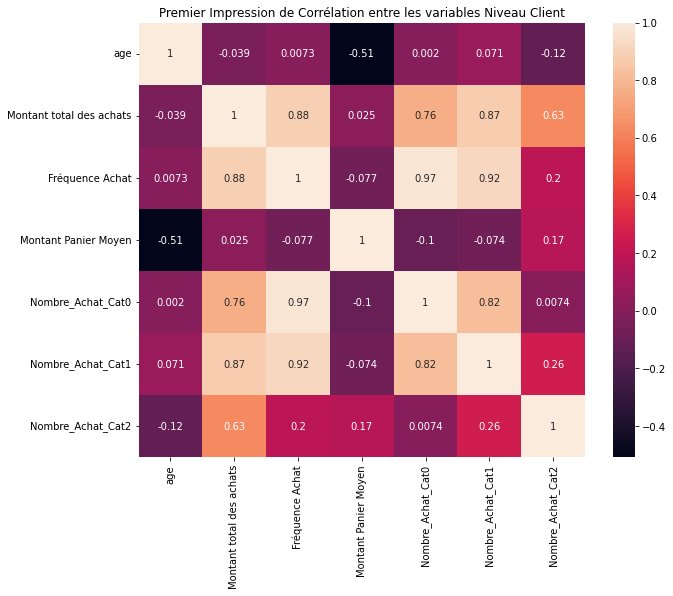

In [97]:
#Utiliser heatmap de seaborn pour visualiser les corrélations entre les variables
plt.figure(figsize=(10,8))
sns.heatmap(data=Correlation,annot=True)
plt.title('Premier Impression de Corrélation entre les variables Niveau Client')
plt.show()

### Première vision de corrélation via heatmap niveau client_id:

    l'âge de client est corrélé très faiblement avec les autres variable.
    
    Nombre d'achat des livres de catégorié 0 et 1 ont une forte corrélation positive (client achete les livres d'un catégorie a forte chance d'achater les livres de l'autre).
    
    Nombre d'achat des livres de catégorié 0 et 1 ont une corrélation forte avec le montant total des achats et la fréquence d'achat
    
    Il y a une forte corrélation entre le montant total d'achat et la fréquence d'achat.
    
   

### 2.1.3 Corrélation via Heatmap (Niveau les âge  des client)

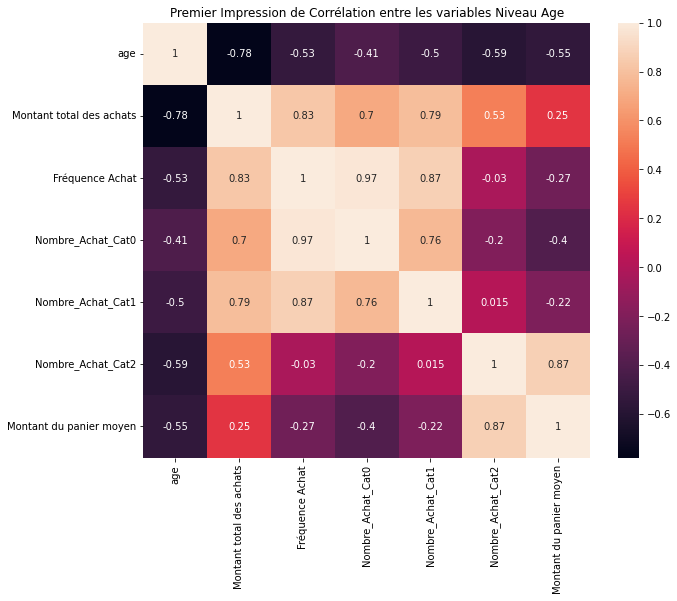

In [98]:

#Regrouper les variables au niveau de l'âge des clients pour voir s'il y a les changements par rapport la vision au niveau de client

Age_Data_heatmap=Client_Data.groupby('age',as_index=False).agg({'Montant total des achats':'sum', 'Fréquence Achat':'sum', 'Nombre_Achat_Cat0':'sum', 'Nombre_Achat_Cat1':'sum',
       'Nombre_Achat_Cat2':'sum'})

#Recalculer le montant du panier moyen de chaque groupe âge
Age_Data_heatmap['Montant du panier moyen']=Age_Data_heatmap['Montant total des achats']/Age_Data_heatmap['Fréquence Achat']

#Calculer les corrélations entre les variables
Age_Data_heatmap_correlation=Age_Data_heatmap.corr()


# Heatmap et Corrélation (niveau âge des clients)

plt.figure(figsize=(10,8))
sns.heatmap(data=Age_Data_heatmap_correlation,annot=True)
plt.title('Premier Impression de Corrélation entre les variables Niveau Age')
plt.show()

### Première vision corrélation via heatmap niveau l'âge des clients:

    Contrairement heatmap niveau client_id, 
    on trouve la corrélation négative forte entre l'âge des client et le montant total des achat avec une coéfficient -0.78
    
    En plus l'âge des clients a les impacts négatives sur tous les variables.
    
    Il y a également une corrélation entre nombre d'achat des produits de catégorié 2 et le montant du panier moyen (prix de catégorié 2 est le plus elevé)
    
    Par la suite, on va analyser la corrélation entre l'âge et les autres variables par groupe de 2 par la suite en appliquer les tests statistiques pour vérifier ces informations identifiées via heatmap de niveau client_id et de niveau de l'âge des clients.

## 2.2 Vérifier corrélation par groupe de 2 variables

### 2.2.1 Construre un tableau Age_Data qui resume le montant total des achats, la fréquence d'achat par âge basé sur Client_Data pour le test des corrélations des variables quantitatives

In [99]:
#Créer Age_Data et calculer le montant total des achats, la fréquence d'achat par âge basé sur Client_Data
Age_Data=Client_Data.groupby('age',as_index=False).agg({'Montant total des achats':'sum','Fréquence Achat':'sum'})

#Ajouter colonne Montant du panier moyen par âge
Age_Data['Montant du panier moyen']=round(Age_Data['Montant total des achats']/Age_Data['Fréquence Achat'],2)
display(Age_Data.head())


age  Montant total des achats  Fréquence Achat  Montant du panier moyen
0   19                 595100.06            14864                    40.04
1   20                 174037.33             4268                    40.78
2   21                 179799.56             4490                    40.04
3   22                 175223.94             4177                    41.95
4   23                 161859.86             4330                    37.38

### 2.2.2 Corrélation l'âge des client et le montant total des achats


    Dans la première vision via heatmap, 
    l'âge et montant total des achats ont une corrélation très faible -0.039 (niveau client_id) et une corrélations forte -0.78 (niveau âge des clients)
    
    
    Comme l'âge des client et et le montant total des achats sont 2 variables quantitatives,
    on va appliquer la  nuage des points et le test pearson pour vérifier la corrélation.
    
    
    Résultat via nuage des points et test pearson:
    
    Test Pearsons: 
    
          Il y a une correlation forte et négative entre âge et le montant total des achats avec une coéfficient de -0.779, qui est cohérent avec l'information de heatmap niveau l'âge des clients.
          
          Quand on supprime les 3 outliers (montant total des achats > 400000), on trouve la corrélation plus forte -0.842.
    
    La nuage des points:
           Il existe 2 sous_groupe selon l'âge, et que chaque sous groupe a une rélation de corrélation différent de l'autre. 
           
           Egalement, avec la suppression de 3 outliers (montant total des achats > 400000) :
           Pearsons correlation positive pour Groupe 1 (Entre 19 et 45 ans) avec une coéfficient de 0.781
           Pearsons correlation  négative pour Groupe 2 (Entre 46 ET 94 ans)avec une coéfficient de -0.907

#### Visualiser la relation des 2 variables via les nuages des points
    Le graphique montre:
       Il y a les outliers (3 points avec Montant total des achats > 400000) vont impacter le résultat
       Il y a une tendance entre  19 et 45 ans et une autre tendance entre entre 46 et 94 ans

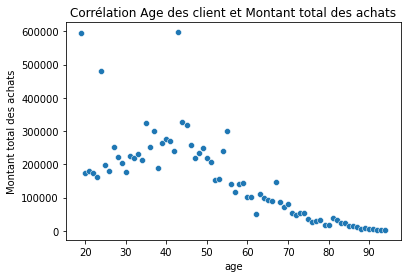

In [100]:
sns.scatterplot(x='age',y='Montant total des achats',data=Age_Data)
plt.title('Corrélation Age des client et Montant total des achats')
plt.show()

### Test Pearson: la corrélation entre l'âge des clients et le montant toal des achats
   
       Les 2 variables (âge et montant total des achats) sont corrélé négativement avec une coéfficiente de -0.779.
   
       Avec la suppression des outliers, la corrélation de 2 variables devient plus importante -0.842.

In [101]:
from scipy.stats import pearsonr

list1 = Age_Data['age']
list2 = Age_Data['Montant total des achats']
 
# Apply the pearsonr()
corr, _ = pearsonr(list1, list2)
print('Pearsons correlation entre âge des client et montant total des achat: %.3f' % corr)

list1b = Age_Data[Age_Data['Montant total des achats']<400000]['age']
list2b = Age_Data[Age_Data['Montant total des achats']<400000]['Montant total des achats']
 
# Apply the pearsonr() avec la suppression de 3 outliers
corr, _ = pearsonr(list1b, list2b)
print('Pearsons correlation entre âge des client et montant total des achat sans 3 outliers: %.3f' % corr)


Pearsons correlation entre âge des client et montant total des achat: -0.779
Pearsons correlation entre âge des client et montant total des achat sans 3 outliers: -0.842


#### Vérifier la corrélation de 2 sous groupes: 
        
    Corrélation de 2 variables dans Groupe 1 (Entre 19 et 45 ans): 
         Les 2 variables sont corrélé positivement avec une coéfficient de 0.781
    
    Corrélation de 2 variables dans Groupe 2 (Entre 46 et 94 ans):
         Les 2 variables sont corrélé négativement avec une coéfficient de -0.907

In [102]:
#Supprimer 3 outliers
Age_Data_horsOutliers=Age_Data[Age_Data['Montant total des achats']<400000]

#Séparer en 2 groupes selon age
Age_Data1=Age_Data_horsOutliers[Age_Data.age<46]
Age_Data2=Age_Data_horsOutliers[Age_Data.age>=46]


list1_G1=Age_Data1['age']
list2_G1=Age_Data1['Montant total des achats']

# Apply the pearsonr() pour groupe 1
corr, _ = pearsonr(list1_G1, list2_G1)
print('Pearsons correlation pour Groupe 1 (Entre 19 et 45 ans) : %.3f' % corr)

list1_G2=Age_Data2['age']
list2_G2=Age_Data2['Montant total des achats']

# Apply the pearsonr() pour groupe 2
corr, _ = pearsonr(list1_G2, list2_G2)
print('Pearsons correlation  Groupe 2 (Entre 46 et 94 ans): %.3f' % corr)


Pearsons correlation pour Groupe 1 (Entre 19 et 45 ans) : 0.781
Pearsons correlation  Groupe 2 (Entre 46 et 94 ans): -0.907


### 2.2.3 Corrélation entre l'âge des client et et la fréquence d’achat

    -Dans Heatmap précédant:
        Niveau client_id: La corrélation entre l'âge des client et la fréquence d'achat avec une coéfficient 0.0073
        Niveau l'âge des clients: La corrélation entre l'âge des client et la fréquence d'achat avec une coéfficient -0.53
        
    -l'âge des clients et et la fréquence d’achat sont 2 variables quantitatives,
     donc, les éthodes utilisés pour vérifier la corrélation sera la nuage des points et le test pearson
    
    
    

    Via Nuage des points, nous trouvons que:
    
    il existe 2 sous groupes concernant la relation entre l'âge des clients et la fréquence d'achat
    
        entre 19 et 45 ans, il y a une corrélation positive 
        entre 46 et 94 ans, il y a une corrélation négative
    
    
    Test Pearson:
    
    En global, le pearson test trouve la coéfficient de la corrélation négative entre l'âge et la fréquence d'achat est -0.535 
    Il y a une légère amélioration mais reste faible pour une coéfficient de -0.582 en cas de la suppression de outlier (fréquence d'achat > 40000) 
    
    Quand nous regardons par sous groups:
    
    Après la suppression de outlier d'où la fréquence d'achat est supérieur à 40000
    
    Pour le groupe 1 âge entre 19 et 45, le pearson test trouve la coéfficient de la corrélation entre l'âge et la fréquence d'achat est 0.773, c'est une corrélation forte est positive.
    
    Pour le groupe 2 âge entre 46 et 94, le pearson test trouve la coéfficient de la corrélation entre l'âge et la fréquence d'achat est -0.89,c'est une corrélation forte est négative.
    
    

### Vérifier la corrélation entre âge et la fréquence d'achat via les nuages de points
    Nuage des points montre que:
    
        Il y a une valeur outlier avec une fréquence d'achat > 40000
        
        Il y a également une distribution similaire comme la relation entre âge et le montant total des achats, 
        c'est à dire que nous pouvons couper les données en 2 groupes selon âge

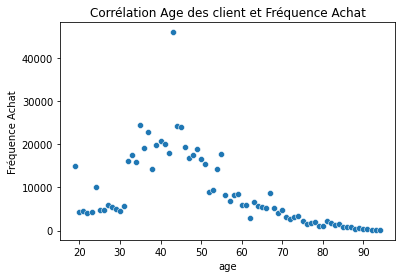

In [103]:
sns.scatterplot(x='age',y='Fréquence Achat',data=Age_Data)
plt.title('Corrélation Age des client et Fréquence Achat')
plt.show()

### Test Pearson Corrélation l'âge des client et la fréquence d'achat

    le test Pearson indique la coéfficient de la corrélation de 2 variables est -0.535,
    si nous supprimons l'outlier, on a obtenu une coéfficient de -0.582 qui est autant faible que le résultat avec outlier.

In [104]:
list1=Age_Data['age']
list2=Age_Data['Fréquence Achat']

# Apply the pearsonr() 
corr, _ = pearsonr(list1, list2)
print('Pearsons coéfficient de la correlation entre l\'âge des client et Montant du panier moyen: %.3f' % corr)


#Supprimer l'outlier Fréquence d'achat >40000
list1b=Age_Data[Age_Data['Fréquence Achat']<40000]['age']
list2b=Age_Data[Age_Data['Fréquence Achat']<40000]['Fréquence Achat']

# Apply the pearsonr() après la suppression de outliers 
corr, _ = pearsonr(list1b, list2b)
print('Pearsons coéfficient de la correlation entre l\'âge des client et Montant du panier moyen sans outlier: %.3f' % corr)



Pearsons coéfficient de la correlation entre l'âge des client et Montant du panier moyen: -0.535
Pearsons coéfficient de la correlation entre l'âge des client et Montant du panier moyen sans outlier: -0.582


### Vérifier la corrélation de 2 sous_groupe

    Pour le groupe 1 âge entre 19 et 45, le pearson test trouve la coéfficient de la corrélation entre l'âge et la fréquence d'achat est 0.773
    Pour le groupe 2 âge entre 46 et 94, le pearson test trouve la coéfficient de la corrélation entre l'âge et la fréquence d'achat est -0.89

In [105]:

#Supprimer l'outlier

Age_DataFréquence=Age_Data[Age_Data['Fréquence Achat']<400000]

#Séparer tableau en 2 sous groupes
Age_DataFréquenceG1=Age_DataFréquence[Age_DataFréquence['age']<46]
Age_DataFréquenceG2=Age_DataFréquence[Age_DataFréquence['age']>=46]

# Donnée entrées pour test pearson de Goupe 1
list1_FréquenceG1=Age_DataFréquenceG1['age']
list2_FréquenceG1=Age_DataFréquenceG1['Fréquence Achat']

# Apply the pearsonr() pour groupe 1
corr, _ = pearsonr(list1_FréquenceG1, list2_FréquenceG1)
print('Pearsons coéfficient de la correlation entre l\'âge des client et la fréquence d\'achat pour âge entre 19 et 45: %.3f' % corr)

# Donnée entrées pour test pearson de Goupe 2

list1_FréquenceG2=Age_DataFréquenceG2['age']
list2_FréquenceG2=Age_DataFréquenceG2['Fréquence Achat']

# Apply the pearsonr() pour groupe 2
corr, _ = pearsonr(list1_FréquenceG2, list2_FréquenceG2)
print('Pearsons coéfficient de la correlation entre l\'âge des client et la fréquence d\'achat pour âge entre 46 et 94: %.3f' % corr)


Pearsons coéfficient de la correlation entre l'âge des client et la fréquence d'achat pour âge entre 19 et 45: 0.773
Pearsons coéfficient de la correlation entre l'âge des client et la fréquence d'achat pour âge entre 46 et 94: -0.890


### 2.2.3 Corrélation entre l'âge des client et et la taille du panier moyen
    
    Heatmap précédant nous montre que la coéfficient de la corrélation entre ces 2 variables 
    est -0.12 au niveau client_id  et -0.55 au niveau l'âge des clients.
    
    l'âge des clients et et la taille du panier moyen sont 2 variables quantitatives
    Via la nuage des points et le test pearson, on revérifie le résultat précédant.
    
    
    1.Pearsons retourne la coéfficient de la correlation entre l'âge des clients et Montant du panier moyen est -0.547 
    qui est cohérent avec le résultat de heatmap niveau d'âge.
    
    
    2. Par ailleurs,

    Le nuage des points nous montre que les points sont concentré en 3 groupes
    
    -Groupe1 (âge entre 19 ans et 31 ans):   une taille de panier moyen  entre 35 et 50 
    -Groupe2 (âge entre 32 ans et 52 ans):   une taille de panier moyen  < 15
    -Groupe2 (âge entre 53 ans et 94 ans):   une taille de panier moyen  entre 15 et 20
    
    
    Mais le test pearson n'a pas trouvé non plus la forte corrélation des 2 variables dans ces 3 sous groupes:
    
    Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 19 et 31:
    -0.126
    
    Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 53 et 94:
    -0.029
    
    Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 32 et 52: 
    0.351


#### Nuage des points: Corrélation entre l'âge des clients et Montant du panier

    Il n'existe pas de signe de la corrélation forte, mais nous pouvons séparer les données en 3 sous groupe pour un test pearson pour confirmer la corrélation.

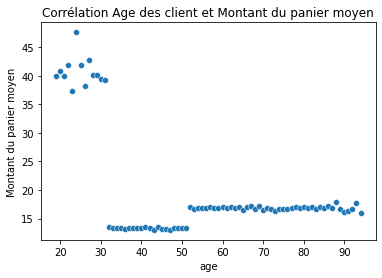

In [106]:
sns.scatterplot(x='age',y='Montant du panier moyen',data=Age_Data)
plt.title('Corrélation Age des client et Montant du panier moyen')
plt.show()

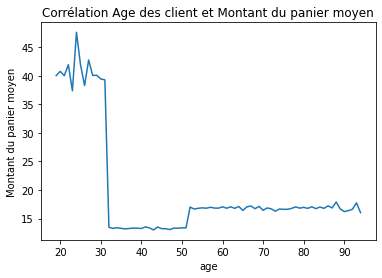

In [107]:

sns.lineplot(x='age',y='Montant du panier moyen',data=Age_Data)
plt.title('Corrélation Age des client et Montant du panier moyen')
plt.show()

#### Test Pearson Corrélation entre l'âge des clients et Montant du panier Moyen
    Pearsons coéfficient de la correlation entre l'âge des client et Montant du panier moyen: -0.547
    Donc, entre 2 variables ,il y a  la corrélation faible entre 2 variables.

In [108]:
list1=Age_Data['age']
list2=Age_Data['Montant du panier moyen']

# Apply the pearsonr() pour groupe 1
corr, _ = pearsonr(list1, list2)
print('Pearsons coéfficient de la correlation entre l\'âge des client et Montant du panier moyen: %.3f' % corr)

Pearsons coéfficient de la correlation entre l'âge des client et Montant du panier moyen: -0.547


#### Test Pearson pour les 3 sous groupes : Corrélation entre l'âge des clients et Montant du panier Moyen

Test Pearson confirme que: 
    
    la corrélation entre l'âge des client et le montant du panier moyen est très faible, même pour ses 3 sous groupes 

    Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 19 et 31: -0.126
    Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 53 et 94: -0.029
    Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 32 et 52: 0.351

In [109]:

#Séparer tableau en 3 sous groupes
Age_DataPanierG1=Age_DataFréquence[Age_DataFréquence['age']<=31]
Age_DataPanierG2=Age_DataFréquence[Age_DataFréquence['age']>=53]
Age_DataPanierG3=Age_DataFréquence[(Age_DataFréquence['age']>31)&(Age_DataFréquence['age']<53)]


# Donnée entrées pour test pearson de Goupe 1
list1_PanierG1=Age_DataPanierG1['age']
list2_PanierG1=Age_DataPanierG1['Montant du panier moyen']

# Apply the pearsonr() pour groupe 1
corr, _ = pearsonr(list1_PanierG1, list2_PanierG1)
print('Pearsons coéfficient de la correlation entre l\'âge des client et le montant du panier moyen pour âge entre 19 et 31: %.3f' % corr)

# Donnée entrées pour test pearson de Goupe 2

list1_PanierG2=Age_DataPanierG2['age']
list2_PanierG2=Age_DataPanierG2['Montant du panier moyen']

# Apply the pearsonr() pour groupe 2
corr, _ = pearsonr(list1_PanierG2, list2_PanierG2)
print('Pearsons coéfficient de la correlation entre l\'âge des client et le montant du panier moyen pour âge entre 53 et 94: %.3f' % corr)

# Donnée entrées pour test pearson de Goupe 2

list1_PanierG3=Age_DataPanierG3['age']
list2_PanierG3=Age_DataPanierG3['Montant du panier moyen']

# Apply the pearsonr() pour groupe 2
corr, _ = pearsonr(list1_PanierG3, list2_PanierG3)
print('Pearsons coéfficient de la correlation entre l\'âge des client et le montant du panier moyen pour âge entre 32 et 52: %.3f' % corr)





Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 19 et 31: -0.126
Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 53 et 94: -0.029
Pearsons coéfficient de la correlation entre l'âge des client et le montant du panier moyen pour âge entre 32 et 52: 0.351


### 2.2.4 Corrélation entre l'âge des client et et les catégories des livres achetés
    
    L'âge des client est variable quantitative. 
    Les catégories des livres achetés est variable qualitative.
    Le méthode à utiliser pour vérifier la corrélation est méthode Anova.
    
    
    Anova test confirme la corrélation de 2 variables avec un p_value 1.121e-10 < 0.05

#### Visualiser la distribution d'âge et la densité selon catégorie via boxplot et kdeplot

    boxplot montre que la moyenne des 3 groupes sont variée
    La densité montre une sous performance de catégorie 2 à partir des âges 30, 
    et une haut performance de catégorie 0 entre 30 et 50.
    
    Les 3 groupes sont varié et non égal selon les graphique , 
    on va appliquer shapiro, levene pour tester la normalité et l'égalité des 3 groupes,
    puis appliquer Anova pour confirmer la corrélation.

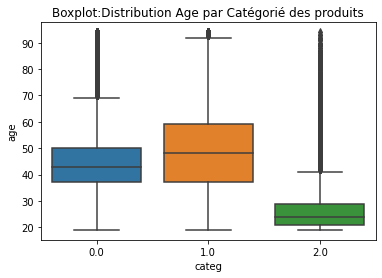

In [110]:

#Boxplot pour la variance et la moyenne des 3 groupes

sns.boxplot(x='categ', y='age',data=transactions)
plt.title('Boxplot:Distribution Age par Catégorié des produits')
plt.show()

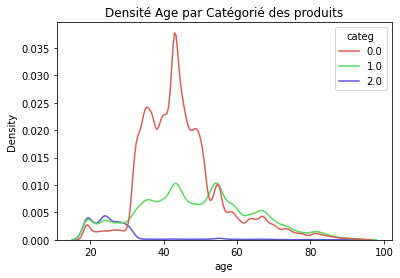

In [111]:
#Kde plot pour la distribution des 3 groupes
sns.kdeplot(x='age', data=transactions,hue='categ',palette=sns.color_palette('hls',3))
plt.title('Densité Age par Catégorié des produits')
plt.show()

#### Créer tableau Anova avec 3 groupes de catégorie par rapport la fréquence d'âge.

In [112]:

#Groupby par âge et catégorie sur le tableau transactions en calculer la fréquence d'âge sur chaque catégorie
tableauAgeCateg=pd.DataFrame(transactions[['age','categ']].value_counts()).reset_index()

#Reformer le tableau avc crosstab 
tableauAnnova=pd.crosstab(tableauAgeCateg.age,tableauAgeCateg.categ,values=tableauAgeCateg.iloc[:,2],aggfunc='sum').reset_index().rename({0.0:'Catégorie0',1.0:'Catégorie1',2.0:'Catégorie2'},axis=1)
display(tableauAgeCateg.head(),tableauAnnova.info(),tableauAnnova.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   age         76 non-null     int64
 1   Catégorie0  76 non-null     int64
 2   Catégorie1  76 non-null     int64
 3   Catégorie2  76 non-null     int64
dtypes: int64(4)
memory usage: 2.5 KB


age  categ      0
0   43    0.0  35401
1   35    0.0  18447
2   45    0.0  18216
3   44    0.0  18003
4   37    0.0  17243

None

categ  age  Catégorie0  Catégorie1  Catégorie2
0       19        3298        5719        5847
1       20         854        1678        1736
2       21         972        1723        1795
3       22         942        1550        1685
4       23        1062        1628        1640

#### Définition des hypothèses de test Anova:
    H0: 3 groupes sont équivalent, il n'y a pas de corrélation entre âge des client et les catégories des produits achetés
    H1: 3 groupes ne sont pas équivalent, il y a une corrélation entre âge des client et les catégories des produits achetés
    

#### Shapiro Test: Normalité de la distribution de 3 groupes
    Il y a 75 échantillons pour le test annova.
    Les P_value de 3 groupes sont tous < 0.05, donc on pourra rejetter le hypothèse nulle, et dire que ces 3 groupes sont en distribution normal.

In [113]:

#Nombre d'échantillons
print('Nombre de N pour le test Annova est :',tableauAnnova['age'].count())

from scipy.stats import shapiro

#Tester la distribution de chaque groupe
print('shapiro Catégorie0:\n',shapiro(tableauAnnova['Catégorie0']))
print('shapiro Catégorie1:\n',shapiro(tableauAnnova['Catégorie1']))
print('shapiro Catégorie2:\n',shapiro(tableauAnnova['Catégorie2']))



Nombre de N pour le test Annova est : 76
shapiro Catégorie0:
 ShapiroResult(statistic=0.7287614941596985, pvalue=1.519482734080313e-10)
shapiro Catégorie1:
 ShapiroResult(statistic=0.931704044342041, pvalue=0.0005123762530274689)
shapiro Catégorie2:
 ShapiroResult(statistic=0.47592490911483765, pvalue=5.139601953394173e-15)


#### Levene: Test de l'égalité des variances
    P_value de levene est 1.728e-26 < 0.05 donc il y a suffisant de variance dans les 3 groupes

In [114]:
stats.levene(tableauAnnova['Catégorie0'],
             tableauAnnova['Catégorie1'],
            tableauAnnova['Catégorie2'],
             center='mean'
            )

LeveneResult(statistic=78.112089024076, pvalue=1.7287578157998808e-26)

#### Test Anova: 
    p_value de annova 1.121e-10 < 0.05 donc nous pouvons rejetter l'hypothèse 0, donc il y la corrélation entre l'âge des clients et le catégorie des livres achetés

In [115]:


stats.f_oneway(tableauAnnova['Catégorie0'],
             tableauAnnova['Catégorie1'],
            tableauAnnova['Catégorie2'])

F_onewayResult(statistic=25.410928162947158, pvalue=1.1215202594547036e-10)

# Partie 4 Analyser le comportement du client

# 1. Relation Nombre de produits achetés et le dépense totale

    Le plus part des clients avec un CA inférieur à 5000 et un nombre de produits achetées inférieur à 400

client_id       CA  Quantité des produits achetés
0       c_1   550.19                             38
1      c_10  1353.60                             58
2     c_100   254.85                              8
3    c_1000  2251.90                            124
4    c_1001  1767.27                             99

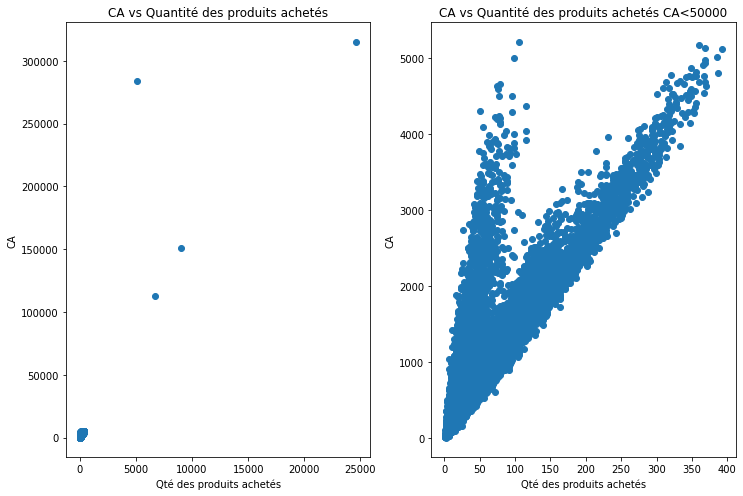

In [116]:
#Créer Client_CA et calculer CA par client
Client_CA=transactions.groupby(['client_id'],as_index=False).price.sum().rename({'price':'CA'},axis=1)

#Créer Client_Produits_Quantite et calculer quantité des produits achetés par client
Client_Produits_Quantite=transactions.groupby(['client_id'],as_index=False).id_prod.count().rename({'id_prod':'Quantité des produits achetés'},axis=1)

#Joindre la quantité des produits achetés et CA par client dans le tableau Client_Produits_Quantite_CA
Client_Produits_Quantite_CA=pd.merge(Client_CA,Client_Produits_Quantite,how='left',on='client_id')
display(Client_Produits_Quantite_CA.head())

# Affichier la nuage des points selon la relation CA et quantité acheté

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.scatter('Quantité des produits achetés','CA',data=Client_Produits_Quantite_CA)
plt.xlabel('Qté des produits achetés')
plt.ylabel('CA')
plt.title('CA vs Quantité des produits achetés')

plt.subplot(122)
plt.scatter('Quantité des produits achetés','CA',data=Client_Produits_Quantite_CA[Client_Produits_Quantite_CA.CA<50000])
plt.xlabel('Qté des produits achetés')
plt.ylabel('CA')
plt.title('CA vs Quantité des produits achetés CA<50000')

plt.show()

# 2.Première date d'achat de client

### 2.1 Analyser la situation de l'intégration des nouveaux clients par le site
    Depuis Septembre 2021, il y a une baisse sur le nombre des clients qui effectuent le premier d'achat sur le site, 
    il signifie que l'intégration des nouveau client est en difficulté.

mois  Nombre de nouveau client
0   2021-03                      5676
1   2021-04                      1468
2   2021-05                       658
3   2021-06                       323
4   2021-07                       175
5   2021-08                       122
6   2021-09                        76
7   2021-10                         4
8   2021-11                        41
9   2021-12                        27
10  2022-01                        19
11  2022-02                        10

La période d'où il y a l'intégration des nouveaux clients est entre 2021-03-01 00:00:00 et 2022-02-28 00:00:00


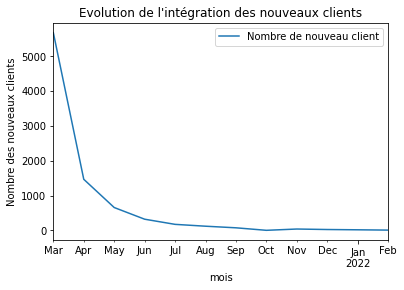

In [117]:
#Créer FirstAchat en trouvant le premier date d'achat de chaque client
FirstAchat=transactions.groupby(['client_id'],as_index=False).transaction_date.min().rename({'transaction_date':'1er Date Achat'},axis=1)
#Transformer la date de premier achat en mois de premier d'achat
FirstAchat['mois']=FirstAchat['1er Date Achat'].dt.to_period('M')

#Créer First_Month_Achat et counter le nombre de premier d'achat par mois
First_Month_Achat=FirstAchat.groupby(['mois'],as_index=False)['client_id'].count().rename({'client_id':'Nombre de nouveau client'},axis=1)
display(First_Month_Achat)

#Imprimer la période concerné par le statistique des premiers achats
print('La période d\'où il y a l\'intégration des nouveaux clients est entre', FirstAchat['1er Date Achat'].min(),'et',FirstAchat['1er Date Achat'].max())

#affichier l'évolution de l'intégration des nouveaux clients dans graphique
First_Month_Achat.plot(x='mois')
plt.ylabel('Nombre des nouveaux clients')
plt.title('Evolution de l\'intégration des nouveaux clients')
plt.show()

### 2.2 Analyser la risque de la perte des clients
    Si on consière que le client qui n'effectue plus l'achat depuis 6 mois comme un client perdu,
    on voit une augmentation des clients perdus entre 05/2022 et 08/2022 par rapport aux périodes précédentes.
    
    La programme de fédélisation pourra prioriser ces clients comme cibles pour que ces clients retournent.

mois  Nombre de client
0   2021-03                 4
1   2021-04                 5
2   2021-05                 4
3   2021-06                 5
4   2021-07                 6
5   2021-08                 2
6   2021-09                 7
7   2021-10                 6
8   2021-11                 8
9   2021-12                11
10  2022-01                 7
11  2022-02                10
12  2022-03                 9
13  2022-04                18
14  2022-05                34
15  2022-06                25
16  2022-07                66
17  2022-08                78
18  2022-09               133
19  2022-10               166
20  2022-11               367
21  2022-12               543
22  2023-01              1497
23  2023-02              5588

La période d'où il y a les clients perdus est entre 2021-03-09 00:00:00 et 2023-02-28 00:00:00


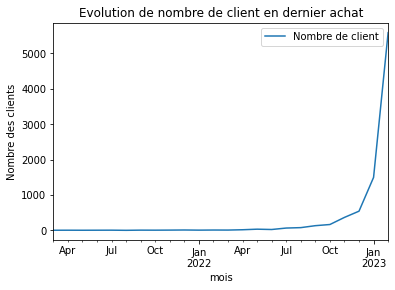

In [118]:
#Créer LastAchat pour trouver la date de dernier achat de chaque client
LastAchat=transactions.groupby(['client_id'],as_index=False).transaction_date.max().rename({'transaction_date':'Dernière Date Achat'},axis=1)
#Transformer la date de dernier achat en mois de dernier achat
LastAchat['mois']=LastAchat['Dernière Date Achat'].dt.to_period('M')

#Counter le nombre de client avec le dernier achat par mois
Last_Month_Achat=LastAchat.groupby(['mois'],as_index=False)['client_id'].count().rename({'client_id':'Nombre de client'},axis=1)
display(Last_Month_Achat)

#Affichier la période de statistique concernée
print('La période d\'où il y a les clients perdus est entre', LastAchat['Dernière Date Achat'].min(),'et',LastAchat['Dernière Date Achat'].max())

#Graphique nombre de client avec le dernier achat par mois
Last_Month_Achat.plot(x='mois')
plt.ylabel('Nombre des clients')
plt.title('Evolution de nombre de client en dernier achat')
plt.show()

### 2.3 Répartition entre le client de multiple d'achat et le client de l'achat simple
    
    Via comparaison entre la date de dernier d'achat et la date de première d'achat d'un client, nous pouvons savoir si c'est un client qui a effectué un achat simple ou multiples d'achat pour voir la capacité de maintien des clients de l'entreprise.
    
    8565 clients sont les clients avec multiple d'achat, seulement 34 clients sont avec simple d'achat.
    Donc, l'entreprise est capable de maintenir un taux de retour des clients  99,6%.
    

In [119]:
#Créer Client_Type et trouver la date de dernier d'achat et la date de premier d'achat de chaque client
Client_Type=transactions.groupby(['client_id'],as_index=False)['transaction_date'].agg(['min','max']).rename({'min':'Prem_Date_Achat','max':'Dern_Date_Achat'},axis=1)
Client_Type.head()

Prem_Date_Achat Dern_Date_Achat
client_id                                
c_1            2021-06-11      2023-01-15
c_10           2021-03-21      2023-01-27
c_100          2021-04-20      2022-09-20
c_1000         2021-03-13      2023-01-24
c_1001         2021-03-07      2023-02-23

In [120]:

Client_Type=Client_Type.reset_index()

#Créer une nouvelle colonne client_type
Client_Type['client_type']=''

#Pour chaque ligne de client_id
for i,j in Client_Type['client_id'].items():

#si la date de premier d'achat est égale à la date de dernier d'achat, on labelise le client comme simple d'achat

    if Client_Type['Prem_Date_Achat'][i]==Client_Type['Dern_Date_Achat'][i]:
        Client_Type['client_type'][i]='Simple d\'achat'

#sinon, on labelisse le client comme multiple d'achat
    else:
        Client_Type['client_type'][i]='multiple d\'achat'

Client_Type.head()

client_id Prem_Date_Achat Dern_Date_Achat       client_type
0       c_1      2021-06-11      2023-01-15  multiple d'achat
1      c_10      2021-03-21      2023-01-27  multiple d'achat
2     c_100      2021-04-20      2022-09-20  multiple d'achat
3    c_1000      2021-03-13      2023-01-24  multiple d'achat
4    c_1001      2021-03-07      2023-02-23  multiple d'achat

multiple d'achat    8565
Simple d'achat        34
Name: client_type, dtype: int64


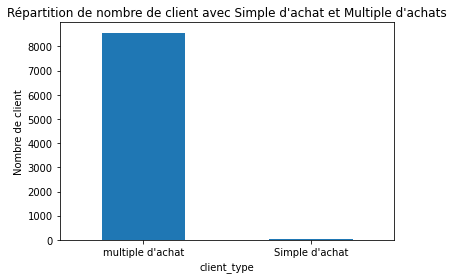

In [121]:

#Affichier le nombre des clients par type (simple d'achat ou multiple d'achat)
print(Client_Type['client_type'].value_counts())

#visualiser la répartition de type des clients

Client_Type['client_type'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title('Répartition de nombre de client avec Simple d\'achat et Multiple d\'achats')
plt.xlabel('client_type')
plt.ylabel('Nombre de client')
plt.show()

## 2.4 Analyser la taux de retention du client

#### Calculer la période de premier d'achat et la différence entre le premier et le dernier d'achat pour chaque client

In [122]:
#Calculer la différence entre la date dernière d'achat et la date de premier d'achat des client
Client_Type['Duration du client en Mois']=Client_Type['Dern_Date_Achat']-Client_Type['Prem_Date_Achat']
#Supprimer 'days' dans le résultat de calcul

Client_Type['Duration du client en Mois']=Client_Type['Duration du client en Mois']/np.timedelta64(1,'M')

#Arrondir supérieur des duration du client en mois
Client_Type['Duration du client en Mois']=Client_Type['Duration du client en Mois'].apply(np.ceil)

#Ajouter la périod 'Mois' selon la date de dernier d'achat
Client_Type['Mois de premier d\'achat']=Client_Type['Prem_Date_Achat'].dt.to_period('M').astype(str)

display(Client_Type.info(),Client_Type.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   8599 non-null   object        
 1   Prem_Date_Achat             8599 non-null   datetime64[ns]
 2   Dern_Date_Achat             8599 non-null   datetime64[ns]
 3   client_type                 8599 non-null   object        
 4   Duration du client en Mois  8599 non-null   float64       
 5   Mois de premier d'achat     8599 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 403.2+ KB


None

client_id Prem_Date_Achat Dern_Date_Achat       client_type  \
0       c_1      2021-06-11      2023-01-15  multiple d'achat   
1      c_10      2021-03-21      2023-01-27  multiple d'achat   
2     c_100      2021-04-20      2022-09-20  multiple d'achat   
3    c_1000      2021-03-13      2023-01-24  multiple d'achat   
4    c_1001      2021-03-07      2023-02-23  multiple d'achat   

   Duration du client en Mois Mois de premier d'achat  
0                        20.0                 2021-06  
1                        23.0                 2021-03  
2                        18.0                 2021-04  
3                        23.0                 2021-03  
4                        24.0                 2021-03

#### Visualiser la distribution de nombre des clients par duration

    La moyen de la duration de la rétention d'un client est 22 mois.
    Seulement 25% des client est avec une duration < 22 mois.

Statistique descriptive de Duration du client est:
 count    8599.000000
mean       22.082103
std         3.122975
min         0.000000
25%        22.000000
50%        23.000000
75%        24.000000
max        24.000000
Name: Duration du client en Mois, dtype: float64


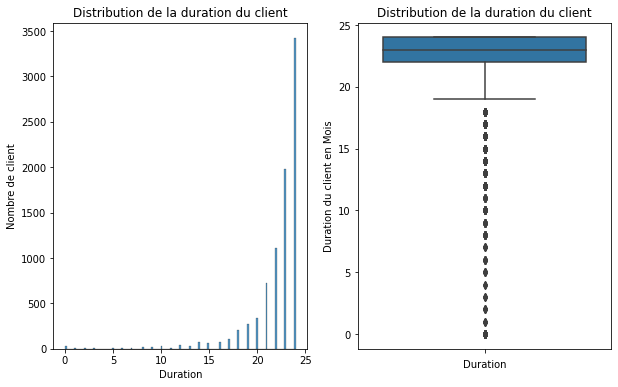

In [123]:
#Distribution de duration du client avec histogramme
print('Statistique descriptive de Duration du client est:\n',Client_Type['Duration du client en Mois'].describe())

plt.figure(figsize=(10,6))
plt.subplot(121)
sns.histplot(data=Client_Type,x='Duration du client en Mois')
plt.title('Distribution de la duration du client')
plt.ylabel('Nombre de client')
plt.xlabel('Duration')

#Distribution de duration du client avec boxplot
plt.subplot(122)
sns.boxplot(y='Duration du client en Mois',data=Client_Type)
plt.title('Distribution de la duration du client')
plt.xlabel('Duration')
plt.show()

#### Calculer le nombre des clients par duration et par période et les stocker dans Crosstab_nombreClient_DurationMoi

In [124]:
#créer nombreClient_DurationMoi pour calculer nombre de client par duration par mois
nombreClient_DurationMoi=Client_Type.groupby(['Mois de premier d\'achat','Duration du client en Mois'],as_index=False)['client_id'].count().rename({'client_id':'Nombre de client'},axis=1)

#Créer matrice de tableau nombreClient_DurationMoi
Crosstab_nombreClient_DurationMoi=pd.crosstab(nombreClient_DurationMoi['Mois de premier d\'achat'],
            nombreClient_DurationMoi['Duration du client en Mois'],
            values=nombreClient_DurationMoi['Nombre de client'],aggfunc='sum',
            margins=True,margins_name='Total').fillna(0)

display(nombreClient_DurationMoi.head(),Crosstab_nombreClient_DurationMoi)

Mois de premier d'achat  Duration du client en Mois  Nombre de client
0                 2021-03                         0.0                 4
1                 2021-03                         1.0                 1
2                 2021-03                         2.0                 1
3                 2021-03                         4.0                 2
4                 2021-03                         6.0                 2

Duration du client en Mois   0.0  1.0  2.0  3.0  4.0  5.0   6.0  7.0   8.0  \
Mois de premier d'achat                                                      
2021-03                      4.0  1.0  1.0  0.0  2.0  0.0   2.0  0.0   3.0   
2021-04                      4.0  1.0  1.0  1.0  0.0  0.0   0.0  0.0   1.0   
2021-05                      1.0  1.0  1.0  0.0  0.0  1.0   1.0  0.0   0.0   
2021-06                      3.0  1.0  0.0  0.0  0.0  0.0   0.0  2.0   3.0   
2021-07                      2.0  0.0  0.0  0.0  0.0  0.0   1.0  1.0   2.0   
2021-08                      2.0  0.0  1.0  0.0  0.0  0.0   0.0  1.0   2.0   
2021-09                      3.0  0.0  2.0  0.0  0.0  1.0   3.0  0.0   5.0   
2021-10                      1.0  0.0  0.0  1.0  0.0  0.0   0.0  0.0   0.0   
2021-11                      4.0  0.0  0.0  0.0  1.0  2.0   1.0  0.0   3.0   
2021-12                      6.0  1.0  0.0  1.0  0.0  1.0   2.0  0.0   0.0   
2022-01                      2.0  0.0  0.0  1.0  0.0  0.0   0.0  0.0   1.0   
2022-02                      2.0  0.0  0.0  0.0  0.0  2.0   0.0  1.0   0.0   
Total                       34.0  5.0  6.0  4.0  3.0  7.0  10.0  5.0  20.0   

Duration du client en Mois   9.0  ...  16.0   17.0   18.0   19.0   20.0  \
Mois de premier d'achat           ...                                     
2021-03                      3.0  ...   9.0   23.0   25.0   60.0   81.0   
2021-04                      0.0  ...   7.0   18.0   28.0   60.0   96.0   
2021-05                      1.0  ...  21.0   15.0   32.0   46.0   76.0   
2021-06                      0.0  ...  13.0   15.0   30.0   51.0   52.0   
2021-07                      0.0  ...   7.0    5.0   31.0   51.0   39.0   
2021-08                      2.0  ...  12.0   15.0   56.0    9.0    0.0   
2021-09                      1.0  ...   8.0   16.0    5.0    0.0    0.0   
2021-10                      0.0  ...   0.0    0.0    0.0    0.0    0.0   
2021-11                      3.0  ...   2.0    0.0    0.0    0.0    0.0   
2021-12                      1.0  ...   0.0    0.0    0.0    0.0    0.0   
2022-01                      3.0  ...   0.0    0.0    0.0    0.0    0.0   
2022-02                      2.0  ...   0.0    0.0    0.0    0.0    0.0   
Total                       16.0  ...  79.0  107.0  207.0  277.0  344.0   

Duration du client en Mois   21.0    22.0    23.0    24.0  Total  
Mois de premier d'achat                                           
2021-03                     209.0   390.0  1422.0  3422.0   5676  
2021-04                     188.0   473.0   560.0     0.0   1468  
2021-05                     194.0   242.0     0.0     0.0    658  
2021-06                     137.0     0.0     0.0     0.0    323  
2021-07                       0.0     0.0     0.0     0.0    175  
2021-08                       0.0     0.0     0.0     0.0    122  
2021-09                       0.0     0.0     0.0     0.0     76  
2021-10                       0.0     0.0     0.0     0.0      4  
2021-11                       0.0     0.0     0.0     0.0     41  
2021-12                       0.0     0.0     0.0     0.0     27  
2022-01                       0.0     0.0     0.0     0.0     19  
2022-02                       0.0     0.0     0.0     0.0     10  
Total                       728.0  1105.0  1982.0  3422.0   8599  

[13 rows x 26 columns]

#### Calculer le cumsum des nombres des clients pertus en fonction de la duration pour chaque période et les stocker dans Client_Loss_Cumsum

In [125]:
Client_Loss_Cumsum=Crosstab_nombreClient_DurationMoi.iloc[:,0:25].apply(lambda x: np.cumsum(x),axis=1)
display(Client_Loss_Cumsum.head())

Duration du client en Mois  0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   \
Mois de premier d'achat                                                      
2021-03                      4.0   5.0   6.0   6.0   8.0   8.0  10.0  10.0   
2021-04                      4.0   5.0   6.0   7.0   7.0   7.0   7.0   7.0   
2021-05                      1.0   2.0   3.0   3.0   3.0   4.0   5.0   5.0   
2021-06                      3.0   4.0   4.0   4.0   4.0   4.0   4.0   6.0   
2021-07                      2.0   2.0   2.0   2.0   2.0   2.0   3.0   4.0   

Duration du client en Mois  8.0   9.0   ...  15.0  16.0  17.0   18.0   19.0  \
Mois de premier d'achat                 ...                                   
2021-03                     13.0  16.0  ...  35.0  44.0  67.0   92.0  152.0   
2021-04                      8.0   8.0  ...  38.0  45.0  63.0   91.0  151.0   
2021-05                      5.0   6.0  ...  32.0  53.0  68.0  100.0  146.0   
2021-06                      9.0   9.0  ...  25.0  38.0  53.0   83.0  134.0   
2021-07                      6.0   6.0  ...  42.0  49.0  54.0   85.0  136.0   

Duration du client en Mois   20.0   21.0   22.0    23.0    24.0  
Mois de premier d'achat                                          
2021-03                     233.0  442.0  832.0  2254.0  5676.0  
2021-04                     247.0  435.0  908.0  1468.0  1468.0  
2021-05                     222.0  416.0  658.0   658.0   658.0  
2021-06                     186.0  323.0  323.0   323.0   323.0  
2021-07                     175.0  175.0  175.0   175.0   175.0  

[5 rows x 25 columns]

#### Ajouter Nombre total du client de chaque période dans Client_Loss_Cumsum

In [126]:
Total_Mensuel=Crosstab_nombreClient_DurationMoi.iloc[:,25].astype(float)
Client_Loss_Cumsum=pd.merge(Client_Loss_Cumsum,Total_Mensuel,how='left',on="Mois de premier d'achat")
display(Client_Loss_Cumsum.head())


0.0  1.0  2.0  3.0  4.0  5.0   6.0   7.0   8.0   9.0  \
Mois de premier d'achat                                                         
2021-03                  4.0  5.0  6.0  6.0  8.0  8.0  10.0  10.0  13.0  16.0   
2021-04                  4.0  5.0  6.0  7.0  7.0  7.0   7.0   7.0   8.0   8.0   
2021-05                  1.0  2.0  3.0  3.0  3.0  4.0   5.0   5.0   5.0   6.0   
2021-06                  3.0  4.0  4.0  4.0  4.0  4.0   4.0   6.0   9.0   9.0   
2021-07                  2.0  2.0  2.0  2.0  2.0  2.0   3.0   4.0   6.0   6.0   

                         ...  16.0  17.0   18.0   19.0   20.0   21.0   22.0  \
Mois de premier d'achat  ...                                                  
2021-03                  ...  44.0  67.0   92.0  152.0  233.0  442.0  832.0   
2021-04                  ...  45.0  63.0   91.0  151.0  247.0  435.0  908.0   
2021-05                  ...  53.0  68.0  100.0  146.0  222.0  416.0  658.0   
2021-06                  ...  38.0  53.0   83.0  134.0  186.0  323.0  323.0   
2021-07                  ...  49.0  54.0   85.0  136.0  175.0  175.0  175.0   

                           23.0    24.0   Total  
Mois de premier d'achat                          
2021-03                  2254.0  5676.0  5676.0  
2021-04                  1468.0  1468.0  1468.0  
2021-05                   658.0   658.0   658.0  
2021-06                   323.0   323.0   323.0  
2021-07                   175.0   175.0   175.0  

[5 rows x 26 columns]

#### Calculer le nombre des clients restants de chaque période suite au départ des clients

In [127]:
Retention_Client=Client_Loss_Cumsum.iloc[:,0:25].subtract(Client_Loss_Cumsum.Total,axis=0).abs()
Retention_Client_Nombre=pd.merge(Retention_Client,Total_Mensuel,how='left',on="Mois de premier d'achat")
display(Retention_Client_Nombre)

0.0     1.0     2.0     3.0     4.0     5.0  \
Mois de premier d'achat                                                   
2021-03                  5672.0  5671.0  5670.0  5670.0  5668.0  5668.0   
2021-04                  1464.0  1463.0  1462.0  1461.0  1461.0  1461.0   
2021-05                   657.0   656.0   655.0   655.0   655.0   654.0   
2021-06                   320.0   319.0   319.0   319.0   319.0   319.0   
2021-07                   173.0   173.0   173.0   173.0   173.0   173.0   
2021-08                   120.0   120.0   119.0   119.0   119.0   119.0   
2021-09                    73.0    73.0    71.0    71.0    71.0    70.0   
2021-10                     3.0     3.0     3.0     2.0     2.0     2.0   
2021-11                    37.0    37.0    37.0    37.0    36.0    34.0   
2021-12                    21.0    20.0    20.0    19.0    19.0    18.0   
2022-01                    17.0    17.0    17.0    16.0    16.0    16.0   
2022-02                     8.0     8.0     8.0     8.0     8.0     6.0   
Total                    8565.0  8560.0  8554.0  8550.0  8547.0  8540.0   

                            6.0     7.0     8.0     9.0  ...    16.0    17.0  \
Mois de premier d'achat                                  ...                   
2021-03                  5666.0  5666.0  5663.0  5660.0  ...  5632.0  5609.0   
2021-04                  1461.0  1461.0  1460.0  1460.0  ...  1423.0  1405.0   
2021-05                   653.0   653.0   653.0   652.0  ...   605.0   590.0   
2021-06                   319.0   317.0   314.0   314.0  ...   285.0   270.0   
2021-07                   172.0   171.0   169.0   169.0  ...   126.0   121.0   
2021-08                   119.0   118.0   116.0   114.0  ...    80.0    65.0   
2021-09                    67.0    67.0    62.0    61.0  ...    21.0     5.0   
2021-10                     2.0     2.0     2.0     2.0  ...     0.0     0.0   
2021-11                    33.0    33.0    30.0    27.0  ...     0.0     0.0   
2021-12                    16.0    16.0    16.0    15.0  ...     0.0     0.0   
2022-01                    16.0    16.0    15.0    12.0  ...     0.0     0.0   
2022-02                     6.0     5.0     5.0     3.0  ...     0.0     0.0   
Total                    8530.0  8525.0  8505.0  8489.0  ...  8172.0  8065.0   

                           18.0    19.0    20.0    21.0    22.0    23.0  24.0  \
Mois de premier d'achat                                                         
2021-03                  5584.0  5524.0  5443.0  5234.0  4844.0  3422.0   0.0   
2021-04                  1377.0  1317.0  1221.0  1033.0   560.0     0.0   0.0   
2021-05                   558.0   512.0   436.0   242.0     0.0     0.0   0.0   
2021-06                   240.0   189.0   137.0     0.0     0.0     0.0   0.0   
2021-07                    90.0    39.0     0.0     0.0     0.0     0.0   0.0   
2021-08                     9.0     0.0     0.0     0.0     0.0     0.0   0.0   
2021-09                     0.0     0.0     0.0     0.0     0.0     0.0   0.0   
2021-10                     0.0     0.0     0.0     0.0     0.0     0.0   0.0   
2021-11                     0.0     0.0     0.0     0.0     0.0     0.0   0.0   
2021-12                     0.0     0.0     0.0     0.0     0.0     0.0   0.0   
2022-01                     0.0     0.0     0.0     0.0     0.0     0.0   0.0   
2022-02                     0.0     0.0     0.0     0.0     0.0     0.0   0.0   
Total                    7858.0  7581.0  7237.0  6509.0  5404.0  3422.0   0.0   

                          Total  
Mois de premier d'achat          
2021-03                  5676.0  
2021-04                  1468.0  
2021-05                   658.0  
2021-06                   323.0  
2021-07                   175.0  
2021-08                   122.0  
2021-09                    76.0  
2021-10                     4.0  
2021-11                    41.0  
2021-12                    27.0  
2022-01                    19.0  
2022-02                    10.0  
Total    

#### Calculer le taux de rétention client de chaque période (client restant divise client total au début de la période)

In [128]:
Retention_Client_Ration=Retention_Client_Nombre.iloc[:,0:25].div(Retention_Client_Nombre.Total,axis=0).round(2)
Retention_Client_Ration

0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   \
Mois de premier d'achat                                                         
2021-03                  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   
2021-04                  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  0.99   
2021-05                  1.00  1.00  1.00  1.00  1.00  0.99  0.99  0.99  0.99   
2021-06                  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.98  0.97   
2021-07                  0.99  0.99  0.99  0.99  0.99  0.99  0.98  0.98  0.97   
2021-08                  0.98  0.98  0.98  0.98  0.98  0.98  0.98  0.97  0.95   
2021-09                  0.96  0.96  0.93  0.93  0.93  0.92  0.88  0.88  0.82   
2021-10                  0.75  0.75  0.75  0.50  0.50  0.50  0.50  0.50  0.50   
2021-11                  0.90  0.90  0.90  0.90  0.88  0.83  0.80  0.80  0.73   
2021-12                  0.78  0.74  0.74  0.70  0.70  0.67  0.59  0.59  0.59   
2022-01                  0.89  0.89  0.89  0.84  0.84  0.84  0.84  0.84  0.79   
2022-02                  0.80  0.80  0.80  0.80  0.80  0.60  0.60  0.50  0.50   
Total                    1.00  1.00  0.99  0.99  0.99  0.99  0.99  0.99  0.99   

                         9.0   ...  15.0  16.0  17.0  18.0  19.0  20.0  21.0  \
Mois de premier d'achat        ...                                             
2021-03                  1.00  ...  0.99  0.99  0.99  0.98  0.97  0.96  0.92   
2021-04                  0.99  ...  0.97  0.97  0.96  0.94  0.90  0.83  0.70   
2021-05                  0.99  ...  0.95  0.92  0.90  0.85  0.78  0.66  0.37   
2021-06                  0.97  ...  0.92  0.88  0.84  0.74  0.59  0.42  0.00   
2021-07                  0.97  ...  0.76  0.72  0.69  0.51  0.22  0.00  0.00   
2021-08                  0.93  ...  0.75  0.66  0.53  0.07  0.00  0.00  0.00   
2021-09                  0.80  ...  0.38  0.28  0.07  0.00  0.00  0.00  0.00   
2021-10                  0.50  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2021-11                  0.66  ...  0.05  0.00  0.00  0.00  0.00  0.00  0.00   
2021-12                  0.56  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2022-01                  0.63  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2022-02                  0.30  ...  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Total                    0.99  ...  0.96  0.95  0.94  0.91  0.88  0.84  0.76   

                         22.0  23.0  24.0  
Mois de premier d'achat                    
2021-03                  0.85   0.6   0.0  
2021-04                  0.38   0.0   0.0  
2021-05                  0.00   0.0   0.0  
2021-06                  0.00   0.0   0.0  
2021-07                  0.00   0.0   0.0  
2021-08                  0.00   0.0   0.0  
2021-09                  0.00   0.0   0.0  
2021-10                  0.00   0.0   0.0  
2021-11                  0.00   0.0   0.0  
2021-12                  0.00   0.0   0.0  
2022-01                  0.00   0.0   0.0  
2022-02                  0.00   0.0   0.0  
Total                    0.63   0.4   0.0  

[13 rows x 25 columns]

#### Visualiser le taux de rétention via heatmap

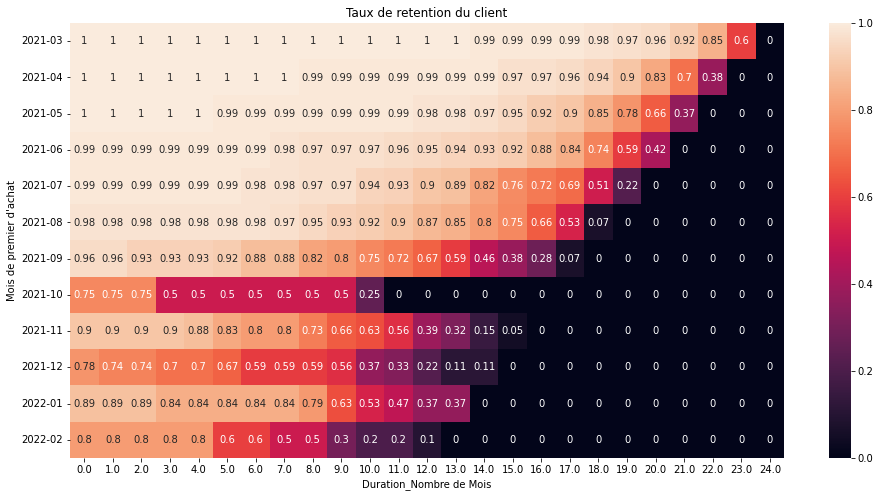

In [129]:
Retention_Client_Ration.iloc[0:12,0:25]

plt.figure(figsize=(16,8))
sns.heatmap(Retention_Client_Ration.iloc[0:12,0:25],annot=True)
plt.title('Taux de retention du client')
plt.xlabel('Duration_Nombre de Mois')
plt.yticks(rotation=0)
plt.show()

### Heatmap interpretation:
    
    Octobre 2121 est particulier car nous avons supprimé les données de ce mois 
    suite à l'absence des données de catégorie 1 pour équilibrer les données de 3 catégories.
    
    Le capacité de la rétention du client de l'entreprise est en baisse entre Novembre 2021 et Février 2022, 
    la duréé de la rétention du client est diminué également de 22 mois à 15 mois.
    
    La période s'arrête à Février 2022 montre que l'entre prise n'a pas pu intégrer les nouveaux clients depuis 1 ans,
    CA est bassé principalement sur les clients connues.

### 2.5 Appliquer Méthode RFM pour segmenter les clients en différents groupes

    RFM:
    R:La durée entre le jour actuel et la date de dernier achat
    M:Montant total dépensé par client
    F:Nombre de session d'achat par client

    On compare chacun de la valeur R, M  et F avec le valeur moyenne de chaque variable. 
    S'il est supérieur à la valeur moyenne, on le code en 1, sinon on donne le valeur 0.

    A la fin, on regoupe les 3 codes obtenues en 1 seule code de 3 lettre qui composé de 0 ou 1 pour chaque client.
    En fonction de le code de 3 lettre donnée au client, on regroupe les clients dans 8 groupes différentes.





In [130]:
#Nous avons déjà un tableau Client_Produits_Quantite_CA qui regroupe l'information de M (Montant total dépensé)
#Nous avons également la date de dernier d'achat dans le tableau 'Client_Type', on le récupère pour calculer R (la distance entre le jour présent et la date de dernier d'achat)
display(Client_Produits_Quantite_CA.head(),Client_Type.head())

client_id       CA  Quantité des produits achetés
0       c_1   550.19                             38
1      c_10  1353.60                             58
2     c_100   254.85                              8
3    c_1000  2251.90                            124
4    c_1001  1767.27                             99

client_id Prem_Date_Achat Dern_Date_Achat       client_type  \
0       c_1      2021-06-11      2023-01-15  multiple d'achat   
1      c_10      2021-03-21      2023-01-27  multiple d'achat   
2     c_100      2021-04-20      2022-09-20  multiple d'achat   
3    c_1000      2021-03-13      2023-01-24  multiple d'achat   
4    c_1001      2021-03-07      2023-02-23  multiple d'achat   

   Duration du client en Mois Mois de premier d'achat  
0                        20.0                 2021-06  
1                        23.0                 2021-03  
2                        18.0                 2021-04  
3                        23.0                 2021-03  
4                        24.0                 2021-03

In [131]:
#Créer RFM en mergant Client_Produits_Quantite_CA et Client_Type avec le clés 'client_id'
RFM=pd.merge(Client_Produits_Quantite_CA,Client_Type,how='left',on='client_id')

#renommer les colonnes de RFM
RFM=RFM[['client_id','CA','Quantité des produits achetés','Dern_Date_Achat']]

#Affichier informations et les premières lignes de RFM
display(RFM.info(),RFM.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8599 entries, 0 to 8598
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   client_id                      8599 non-null   object        
 1   CA                             8599 non-null   float64       
 2   Quantité des produits achetés  8599 non-null   int64         
 3   Dern_Date_Achat                8599 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 335.9+ KB


None

client_id       CA  Quantité des produits achetés Dern_Date_Achat
0       c_1   550.19                             38      2023-01-15
1      c_10  1353.60                             58      2023-01-27
2     c_100   254.85                              8      2022-09-20
3    c_1000  2251.90                            124      2023-01-24
4    c_1001  1767.27                             99      2023-02-23

In [132]:
#Calculer la fréquence d'avaht F de RFM avec nombre de session_id par client
Frequence=transactions.groupby(['client_id'],as_index=False)['session_id'].count().rename({'session_id':'F'},axis=1)
Frequence.head()

client_id    F
0       c_1   38
1      c_10   58
2     c_100    8
3    c_1000  124
4    c_1001   99

In [133]:
#Ajouter Fréquence dans RFM
RFM=pd.merge(RFM,Frequence,how='left',on='client_id')
RFM.head()

client_id       CA  Quantité des produits achetés Dern_Date_Achat    F
0       c_1   550.19                             38      2023-01-15   38
1      c_10  1353.60                             58      2023-01-27   58
2     c_100   254.85                              8      2022-09-20    8
3    c_1000  2251.90                            124      2023-01-24  124
4    c_1001  1767.27                             99      2023-02-23   99

In [134]:
#Chercher le jour présent, on consière que la dernière date de tableau de transactions est le jour présent.
RFM['max_date']=transactions['transaction_date'].max()

#Créer la colonne R en calculant la différence entre la date de jour présent et la date de dernier d'achat
# R doit être négative pour l'étiquetter 1 quand le dernière achat est récent

RFM['R']=RFM['Dern_Date_Achat']-RFM['max_date']

#Reformuler la colonne R (supprimer 'days' suite à la calcule de datetime) 
RFM['R']=RFM['R']/np.timedelta64(1,'D')
RFM.head()

client_id       CA  Quantité des produits achetés Dern_Date_Achat    F  \
0       c_1   550.19                             38      2023-01-15   38   
1      c_10  1353.60                             58      2023-01-27   58   
2     c_100   254.85                              8      2022-09-20    8   
3    c_1000  2251.90                            124      2023-01-24  124   
4    c_1001  1767.27                             99      2023-02-23   99   

    max_date      R  
0 2023-02-28  -44.0  
1 2023-02-28  -32.0  
2 2023-02-28 -161.0  
3 2023-02-28  -35.0  
4 2023-02-28   -5.0

In [135]:
#Renommer les colonnes M (CA) et F(Quantité des produits achetés) et supprimer les colonnes non utiles
RFM=RFM.drop(['Dern_Date_Achat','max_date','Quantité des produits achetés'],axis=1)
RFM = RFM.rename(columns={'CA': 'M'})
RFM.head()

client_id        M    F      R
0       c_1   550.19   38  -44.0
1      c_10  1353.60   58  -32.0
2     c_100   254.85    8 -161.0
3    c_1000  2251.90  124  -35.0
4    c_1001  1767.27   99   -5.0

In [136]:
#définir client_id comme index pour ne pas impacter le calcule des autres variables R, F et M
RFM.set_index(['client_id'],inplace=True)

In [137]:
def RFM_fonction(x):
    
    #Créer fonction pour chaque case de tableau si la valeur de case >=0, on donne le valeur 1, sinon 0
    level=x.map(lambda x: '1' if x>=0 else '0')
    
    #Combiner le code obtenue pour R, F et M de chaque client
    label= level.R+level.F+level.M
    
    #Créer la dictionnaire
        #si M=1 client Valeur sinon 0 client normale
        #si F=1 client achat fréquenté il faut le maintenir, sinon 0 il faut les stimuler pour l'augmenter la la fréquence d'achat.
        #si R=1 client le dernier d'achat est proche par rapport à la moyenne, sinon 0 on doit les regagner. 
        
    d={
    '111' : 'Valeur_VIP', #M CA/session important + F haut fréquence d'achat  + R dernier achat récent
    '011' : 'Valeur__A_MAINTENIR', #M CA/session haut + F haut fréquence d'achat  + R dernier achat loin
    '101' : 'Valeur_A_FEDELISER', #M CA/session haut + F bas fréquence d'achat  + R dernier achat récent
    '001' : 'Valeur_A_DEVELOPPER', #M CA/session haut + F bas fréquence d'achat  + R dernier achat loin
    '110' : 'Normal_VIP',         #M  CA/session bas + F haut fréquence d'achat  + R dernier achat récent
    '010' : 'Normal_A_MAINTENIR', #M CA/session bas + F haut fréquence d'achat  + R dernier achat loin
    '100' : 'Normal_A_FEDELISER', #M CA/session bas + F bas fréquence d'achat  + R dernier achat récent
    '000' : 'Normal_A_DEVELOPPER', #M CA/session bas + F bas fréquence d'achat  + R dernier achat loin
    }
    
    #Chercher le code de 3 lettres dans la dictionnaire d et retourner l'étiquette du client prédéfini dans le dictionnaire
    result=d[label]
    return result

In [138]:
#chaque valeur de variable R,F,M de tableau RFM comparer avec son valeur moyenne pour trouver le code 1 ou 0,
#Puis son résultat avec code 1 et 0 applique la fonction RFM_fonction défini précédement.

RFM['Etiquette_Client']=RFM.apply(lambda x: x-x.mean()).apply(RFM_fonction,axis=1)

display(RFM.head())


M    F      R     Etiquette_Client
client_id                                          
c_1         550.19   38  -44.0  Normal_A_DEVELOPPER
c_10       1353.60   58  -32.0   Valeur_A_FEDELISER
c_100       254.85    8 -161.0  Normal_A_DEVELOPPER
c_1000     2251.90  124  -35.0           Valeur_VIP
c_1001     1767.27   99   -5.0           Valeur_VIP

#### Visualiser le nombre des clients par segmentation RFM

Normal_A_FEDELISER     2947
Valeur_VIP             2213
Normal_A_DEVELOPPER    2018
Valeur_A_FEDELISER      720
Normal_VIP              448
Valeur_A_DEVELOPPER     162
Normal_A_MAINTENIR       48
Valeur__A_MAINTENIR      43
Name: Etiquette_Client, dtype: int64


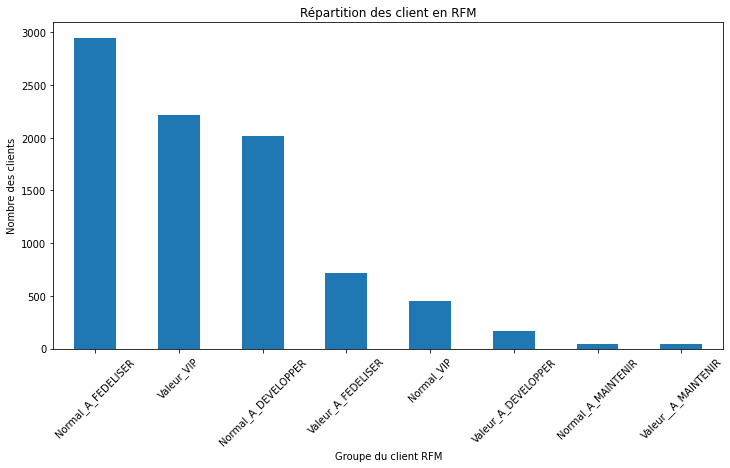

In [139]:
print(RFM.Etiquette_Client.value_counts())
plt.figure(figsize=(12,6))
RFM.Etiquette_Client.value_counts().plot.bar()
plt.xticks(rotation=45)
plt.xlabel('Groupe du client RFM')
plt.ylabel('Nombre des clients')
plt.title('Répartition des client en RFM')
plt.show()

### Interpretation graphique bar:
    
    Selon le groupe du client (valeur ou normal), l'entreprise pourra définir les démarches marketings différentes 
    en fonction de la rentabilité client.
    
    48 clients à maintenir dans les clients valeur et 43 clients à maintenir dans les clients normaux 
    dont la dernière d'achat est loin, nous pouvons les envoyer les offres spéciales pour les regagner.
    
    2018 clients Normal_A_DEVELOPPER et 162 client valeur_A_DEVELOPPER sont également le risque pour l'entreprise
    à cause de dernière date d'achat loin.
    
    
    Pour les clients A_FEDELISER, l'entreprise pourra proposer les nouveaux produits présent sur le site selon leur
    consomation historique pour augmenter la fréquence d'achat de ses clients.Il est possible proposer le cumul 
    des points de consommation pour stimuler la fréquence d'achat.
    
    Pour les clients VIP, l'entreprise pourra proposer la programme de fédélisation avantageuse et l'évenement privé 
    pour maintenir la relation clientèle.
    
    
    Pour pouvoir suivre l'efficacité des actions marketing, je vais proposer les outils dans le bloc suivant 
    pour évaluer le cycle de vie des clients en inter-période example de nouveau à active, de l'active 
    à non active ect.
    
    

# 3. Analyser la cycle de vie d'un client

    Dans ce bloc, nous donnerons à chaque client une étiquette des 5 status 
    suivant 'Observe','Nouveau','Active','NOactive','Retour' pour chaque période. 
    
    cette étiquette est en fonction de son achat ou non sur la période P,
    en comparant avec sa étiquette de la période P-1.
    
    Cet outil permets à l'entreprise de savoir:
        -La répartition des clients selon statu par période
        -Comparer la période P avec la période P-1 pour mesurer l'efficacité des démarches marketing 
        via une matrice de transition
    

#### Définition de la période
    Selon le caractère des produits (livres), on définisse 6 mois comme la période de statistique.
    Donc, nous ajouter l'étiquette semestre à chaque ligne de tableau transactions.

In [140]:
# Identifier la semestre de chaque date en format string en ajoutant l'année et 'S'
transactions['Semester']= transactions.year.astype(str) + 'S'+ np.where(transactions.transaction_date.dt.quarter.gt(2),2,1).astype(str)
transactions.head()

id_prod                        date session_id client_id  price  categ sex  \
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534  15.99    1.0   m   
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714   7.99    0.0   f   
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941  69.99    2.0   m   
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232   4.99    0.0   m   

   birth transaction_date  age  year  month Semester  
0   1986       2022-05-20   37  2022      5   2022S1  
1   1988       2022-02-02   35  2022      2   2022S1  
2   1968       2022-06-18   55  2022      6   2022S1  
3   2000       2021-06-24   23  2021      6   2021S1  
4   1980       2023-01-11   43  2023      1   2023S1

#### Calculer le nombre de session_id(achat) de chaque client par semestre

In [141]:
#Créer Client_Freq et calculer le nombre de session par client par semestre
Client_Freq=transactions.groupby(['Semester','client_id'],as_index=False)['session_id'].count().rename({'session_id':'Nombre_Session'},axis=1)

#Pivoter le tableau et mettre le Semestrer comme colonne en créant Client_Freq_Semester
#En cas de sans achat sur la période, on donne la valeur '0'
Client_Freq_Semester=Client_Freq.pivot_table(index='client_id',values='Nombre_Session',columns='Semester').fillna(0)

Client_Freq_Semester.head()

Semester   2021S1  2021S2  2022S1  2022S2  2023S1
client_id                                        
c_1           1.0    17.0     9.0     9.0     2.0
c_10          9.0    19.0    10.0    15.0     5.0
c_100         3.0     3.0     0.0     2.0     0.0
c_1000       16.0    25.0    47.0    29.0     7.0
c_1001       12.0    34.0    22.0    21.0    10.0

#### Il y a 5 périodes définies

In [142]:
#Trouver le nombre de période de tableau Client_Freq_Semester
print('Nombre de période est:',len(Client_Freq_Semester.columns))

Nombre de période est: 5


#### Pour un client donné, on code 1 s'il a effectué au moin un achat durant la période, sinon on le code 0

In [143]:
#Pour un client a réalisé le ou les achats sur une période donnée, on le donne la valeur 1, sinon 0
Client_Freq_Semester=Client_Freq_Semester.applymap(lambda x:1 if x>=1 else 0)
Client_Freq_Semester

Semester   2021S1  2021S2  2022S1  2022S2  2023S1
client_id                                        
c_1             1       1       1       1       1
c_10            1       1       1       1       1
c_100           1       1       0       1       0
c_1000          1       1       1       1       1
c_1001          1       1       1       1       1
...           ...     ...     ...     ...     ...
c_995           1       1       0       1       0
c_996           1       1       1       1       1
c_997           1       1       1       1       1
c_998           1       1       1       1       1
c_999           0       1       1       1       1

[8599 rows x 5 columns]

#### Créer fonction client_statu pour prédéfinir l'étiquette d'un client en fonction de son achat de la période en cours et son étiquette de la période précédente.

In [144]:

#Définir la fonction pour étiquetter le client en Observe,Nouveau,Active,NOactive,Retour
def client_statu(data):
    
    #Créer liste vide statu pour stocker le résultat
    statu=[]
    
    #Pour chaque période dans les 5 périodes concernées
    for i in range(5):
        
        #Si il n'y a pas de l'achat à la période indiqué
        if data[i]==0:
            
            #Si c'est pas la première période avec une étiquette
            if len(statu)>0:
                
                #Si il est étiquetté 'Observe' durant la période précédant P-1
                if statu[i-1]=='Observe':
                    #la période présent est 'Observe'
                    statu.append('Observe')
                #Sinon le client a un achat historique dans la période P-1 (cas de Nouveau, Active,Retour), 
                #donc maintenant il devient 'NOactive'
                else:
                    statu.append('NOactive')
                    
            #Si c'est la première période du client, on le note comme 'Observe' comme il n'y a pas de l'achat réalisé
            else:
                statu.append('Observe')
        
        # Si la période présent avec un achat
        else:
            
            #Si c'est le premier période à étiquetter pour le client
            if len(statu)==0:
                #On le considère comme client 'Nouveau'
                statu.append('Nouveau')
                
            #Sinon ce n'est pas la première étiquette du client
            else:
                
                #Si l'étiquette de la période précédant est 'NOactive', 
                #on considère que le client est 'Retour' avec l'achat de cette période
                if statu[i-1]=='NOactive':
                    statu.append('Retour')
                
                #Si l'étiquette de la période précédant est 'Observe', 
                #on considère que le client est 'Nouveau' avec l'achat de cette période
                elif statu[i-1]=='Observe':
                    statu.append('Nouveau')
                
                 #Sinon l'étiquette de la période précédant est 'Active','Nouveau' ou 'Retour', 
                 #on considère que le client est 'Active' avec l'achat de cette période
                else:
                    statu.append('Active')
    #Retourner le liste des étiquettes mensuelles de chaque client
    return statu

#### Appliquer la fonction client_statu dans le tableau Client_Freq_Semester d'où nous avons coder 1 ou 0 pour chaque client par période.

       La fonction retourne un résultat de type objet.
       
       Chaque client a une liste de 5 étiquette qui correspondent à 5 périodes (semestre) 
       de tableau Client_Freq_Semester.

In [145]:
#Créer Etiquette_Client pour appliquer la fonction client_statu avec tableau Client_Freq_Semester
Etiquette_Client=Client_Freq_Semester.apply(client_statu,axis=1)
Etiquette_Client.head()

client_id
c_1           [Nouveau, Active, Active, Active, Active]
c_10          [Nouveau, Active, Active, Active, Active]
c_100     [Nouveau, Active, NOactive, Retour, NOactive]
c_1000        [Nouveau, Active, Active, Active, Active]
c_1001        [Nouveau, Active, Active, Active, Active]
dtype: object

#### Stocker le résultat de fonction client_statu dans le tableau Etiquette_Client_Semester en fonction des client_id (index) et la période concerné de tableau Client_Freq_Semester(Colonne) en remplaçant le code 1 et 0. 

In [146]:
#Utiliser l'index et les colonnes de Client_Freq_Semester remplir un nouveau tableau Etiquette_Client_Month avec les étiquettes par semester trouvé
Etiquette_Client_Semester=pd.DataFrame(data=Etiquette_Client.values.tolist(),index=Client_Freq_Semester.index,columns=Client_Freq_Semester.columns)
Etiquette_Client_Semester.head()

Semester    2021S1  2021S2    2022S1  2022S2    2023S1
client_id                                             
c_1        Nouveau  Active    Active  Active    Active
c_10       Nouveau  Active    Active  Active    Active
c_100      Nouveau  Active  NOactive  Retour  NOactive
c_1000     Nouveau  Active    Active  Active    Active
c_1001     Nouveau  Active    Active  Active    Active

#### Calculer le nombre total des clients de chaque statu (étiquette) par période et stocker le résultat dans Statu_Client_stats

In [147]:
#Créer Statu_Client_stats calculer le nombre de client total de chaque type par semestre
Statu_Client_stats=Etiquette_Client_Semester.apply(lambda x : pd.value_counts(x)).fillna(0)

#reformuler  le tableau  Statu_Client_stats avec  reset_index en le transposant 
Statu_Client_stats=Statu_Client_stats.T
Statu_Client_stats=Statu_Client_stats.reset_index()
Statu_Client_stats

Semester  Active  NOactive  Nouveau  Observe  Retour
0   2021S1     0.0       0.0   8125.0    474.0     0.0
1   2021S2  7916.0     209.0    445.0     29.0     0.0
2   2022S1  8120.0     287.0     29.0      0.0   163.0
3   2022S2  8125.0     264.0      0.0      0.0   210.0
4   2023S1  6982.0    1514.0      0.0      0.0   103.0

In [148]:
#Vérifier l'information de Statu_Client_stats
Statu_Client_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Semester  5 non-null      object 
 1   Active    5 non-null      float64
 2   NOactive  5 non-null      float64
 3   Nouveau   5 non-null      float64
 4   Observe   5 non-null      float64
 5   Retour    5 non-null      float64
dtypes: float64(5), object(1)
memory usage: 368.0+ bytes


#### Création de graphique pour visualiser la répartition des clients en fonction de statu par période

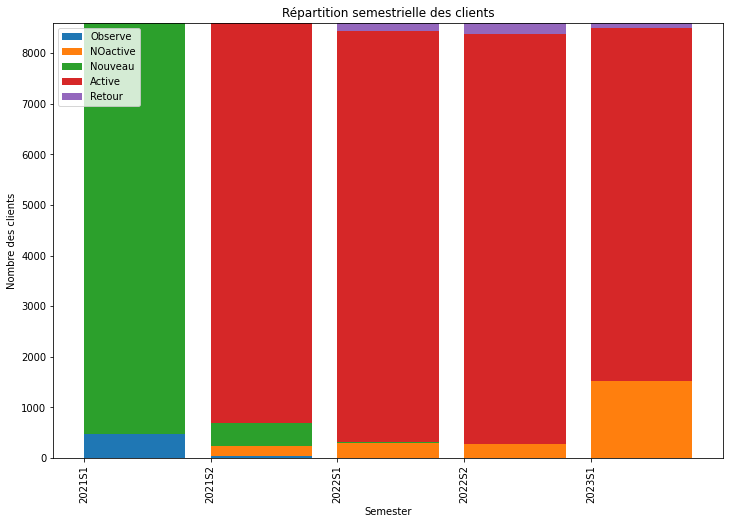

In [149]:
#Définir X et Y de graphique
x0=Statu_Client_stats.Semester
y1=Statu_Client_stats.Observe
y2=Statu_Client_stats.NOactive
y3=Statu_Client_stats.Nouveau
y4=Statu_Client_stats.Active
y5=Statu_Client_stats.Retour

#Surposer les valeurs des différents classe de Y avec subplots
fig,ax=plt.subplots(figsize=(12,8))
ax.bar(x0,y1, align='edge',label='Observe')
ax.bar(x0,y2,align='edge',bottom=y1,label='NOactive')
ax.bar(x0,y3,align='edge',bottom=y1+y2,label='Nouveau')
ax.bar(x0,y4,align='edge',bottom=y1+y2+y3,label='Active')
ax.bar(x0,y5,align='edge',bottom=y1+y2+y3+y4,label='Retour')

plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Semester')
plt.ylabel('Nombre des clients')
plt.title('Répartition semestrielle des clients')
plt.show()


### Interpretation de Graphique:

     Depuis 2022S1, l'entreprise n'a plus des clients 'Observe',ou 'Nouveau', 
     donc il y a un problème d'attirer les nouveaux clients.
     
     Le nombre de client en statu 'active','NOactive','Retour' sont stable. 
     En plus le client active occupe de grande pourcentage de la répartition.
     L'entreprise est capable d'assurer un bon niveau de rétention.
     
     Le nombre des clients 'Retour' indique les clients regagnés après un achat daté loin.
     
     2023S1 n'est pas une période complete, la hausse des clients 'NOactive' pourra être amélioré 
     avant de la fin de la période.
    
    Mais comment savoir l'évolution de chaque statu de période P-1 vers la période P, 
    nous créerons les outils pour traiter ce sujet par la suite.
    

### Outil de suivi de l'évolution des status inter_périodes

In [150]:
#Créer le list vide 'd' pour stocker le nom des tableaux de l'évolution 
d=[]

# Comme nous avons 5 semestres dans le tableau Etiquette_Client_Semester, 
#donc le nombre des tableaux de l'évolution est 4

for i in range(4):
    
    #Sélectionne 2 colonnes de 2 périodes à comparer en le stockant dans Evolution
    Evolution=Etiquette_Client_Semester.iloc[:,i:i+2].reset_index()
    
    #Définir le nom de tableau Evolution + le nom de la période P en le stockant dans variable a
    a=Evolution.columns[-1:].to_list()[0]+'Evolution'
    
    #Nommer le tableau d'évolution avec le nom créé avec a
    locals()[a]=Evolution
    
    #Dans list d, stocker chaque nom de tableau d'évolution généré
    d.append(a)
    
    #imprimer les noms des tableaux d'évolution
    print(a)
    
    
    #Groupby selon l'étiquette de période P-1 et de période P en calculant le nombre de client de chaque segment
    locals()[a]=locals()[a].groupby(Evolution.columns[-2:].to_list(),as_index=False).count().rename({'client_id':'Nombre de Client',Evolution.columns[-2:].to_list()[0]:'Statu P-1',Evolution.columns[-2:].to_list()[1]:'Statu P'},axis=1)
    
    #Pour faciliter la vérification, créer une colonne 'Evolution Statu' pour mémoriser l'évolution de statu entre période
    locals()[a]['Evolution Statu']=locals()[a]['Statu P-1']+' to '+locals()[a]['Statu P']
    
    #Créer colonne Période avec le nom de période P (car en période P on compare avec la période P-1)
    locals()[a]['Période']=Evolution.columns[-2:].to_list()[1]
    
    
    #Affichier tous les tableaux d'évolution
    display(locals()[a])


2021S2Evolution


Semester Statu P-1   Statu P  Nombre de Client      Evolution Statu Période
0          Nouveau    Active              7916    Nouveau to Active  2021S2
1          Nouveau  NOactive               209  Nouveau to NOactive  2021S2
2          Observe   Nouveau               445   Observe to Nouveau  2021S2
3          Observe   Observe                29   Observe to Observe  2021S2

2022S1Evolution


Semester Statu P-1   Statu P  Nombre de Client       Evolution Statu Période
0           Active    Active              7746      Active to Active  2022S1
1           Active  NOactive               170    Active to NOactive  2022S1
2         NOactive  NOactive                46  NOactive to NOactive  2022S1
3         NOactive    Retour               163    NOactive to Retour  2022S1
4          Nouveau    Active               374     Nouveau to Active  2022S1
5          Nouveau  NOactive                71   Nouveau to NOactive  2022S1
6          Observe   Nouveau                29    Observe to Nouveau  2022S1

2022S2Evolution


Semester Statu P-1   Statu P  Nombre de Client       Evolution Statu Période
0           Active    Active              7967      Active to Active  2022S2
1           Active  NOactive               153    Active to NOactive  2022S2
2         NOactive  NOactive                77  NOactive to NOactive  2022S2
3         NOactive    Retour               210    NOactive to Retour  2022S2
4          Nouveau    Active                19     Nouveau to Active  2022S2
5          Nouveau  NOactive                10   Nouveau to NOactive  2022S2
6           Retour    Active               139      Retour to Active  2022S2
7           Retour  NOactive                24    Retour to NOactive  2022S2

2023S1Evolution


Semester Statu P-1   Statu P  Nombre de Client       Evolution Statu Période
0           Active    Active              6894      Active to Active  2023S1
1           Active  NOactive              1231    Active to NOactive  2023S1
2         NOactive  NOactive               161  NOactive to NOactive  2023S1
3         NOactive    Retour               103    NOactive to Retour  2023S1
4           Retour    Active                88      Retour to Active  2023S1
5           Retour  NOactive               122    Retour to NOactive  2023S1

#### Le liste des tableaux d'évolution
    Il y a 4 tableaux générés

In [151]:
#Imrpimer le nom de tous les tableaux d'évolution généré que nous avons stocké dans le list 'd'
print(d)

['2021S2Evolution', '2022S1Evolution', '2022S2Evolution', '2023S1Evolution']


#### Concatener tous les tableaux d'évolution dans un seul tableau de synthèse

In [152]:

#Créer concat_table pour concatener les 2 premiers tableaux

concat_table=pd.concat([locals()[d[0]],locals()[d[1]]])

#A partir de 3iem tableau, on applique un boucle
#selon le longeur de list de tableaux générés qui est stocké dans le liste d

for i in range(2,len(d)):
                        concat_table=pd.concat([concat_table,locals()[d[i]]])

#Affichier le tableau de synthèse
concat_table
                        

Semester Statu P-1   Statu P  Nombre de Client       Evolution Statu Période
0          Nouveau    Active              7916     Nouveau to Active  2021S2
1          Nouveau  NOactive               209   Nouveau to NOactive  2021S2
2          Observe   Nouveau               445    Observe to Nouveau  2021S2
3          Observe   Observe                29    Observe to Observe  2021S2
0           Active    Active              7746      Active to Active  2022S1
1           Active  NOactive               170    Active to NOactive  2022S1
2         NOactive  NOactive                46  NOactive to NOactive  2022S1
3         NOactive    Retour               163    NOactive to Retour  2022S1
4          Nouveau    Active               374     Nouveau to Active  2022S1
5          Nouveau  NOactive                71   Nouveau to NOactive  2022S1
6          Observe   Nouveau                29    Observe to Nouveau  2022S1
0           Active    Active              7967      Active to Active  2022S2
1           Active  NOactive               153    Active to NOactive  2022S2
2         NOactive  NOactive                77  NOactive to NOactive  2022S2
3         NOactive    Retour               210    NOactive to Retour  2022S2
4          Nouveau    Active                19     Nouveau to Active  2022S2
5          Nouveau  NOactive                10   Nouveau to NOactive  2022S2
6           Retour    Active               139      Retour to Active  2022S2
7           Retour  NOactive                24    Retour to NOactive  2022S2
0           Active    Active              6894      Active to Active  2023S1
1           Active  NOactive              1231    Active to NOactive  2023S1
2         NOactive  NOactive               161  NOactive to NOactive  2023S1
3         NOactive    Retour               103    NOactive to Retour  2023S1
4           Retour    Active                88      Retour to Active  2023S1
5           Retour  NOactive               122    Retour to NOactive  2023S1

#### Transposer le tableau de synthèse de l'évolution pour faciliter la visualisation de la comparaison des status inter_pérides

In [153]:

#Transposer le tableau synthèse et l'affichier
Matrice_Transition=pd.crosstab(concat_table['Statu P-1'],
                               [concat_table['Période'],concat_table['Statu P']],
                               values=concat_table['Nombre de Client'], 
                               aggfunc='sum').fillna(0)
display(Matrice_Transition)


#affichier le nombre de période
print(concat_table['Période'].unique())


Période    2021S2                           2022S1                          \
Statu P    Active NOactive Nouveau Observe  Active NOactive Nouveau Retour   
Statu P-1                                                                    
Active        0.0      0.0     0.0     0.0  7746.0    170.0     0.0    0.0   
NOactive      0.0      0.0     0.0     0.0     0.0     46.0     0.0  163.0   
Nouveau    7916.0    209.0     0.0     0.0   374.0     71.0     0.0    0.0   
Observe       0.0      0.0   445.0    29.0     0.0      0.0    29.0    0.0   
Retour        0.0      0.0     0.0     0.0     0.0      0.0     0.0    0.0   

Période    2022S2                  2023S1                  
Statu P    Active NOactive Retour  Active NOactive Retour  
Statu P-1                                                  
Active     7967.0    153.0    0.0  6894.0   1231.0    0.0  
NOactive      0.0     77.0  210.0     0.0    161.0  103.0  
Nouveau      19.0     10.0    0.0     0.0      0.0    0.0  
Observe       0.0      0.0    0.0     0.0      0.0    0.0  
Retour      139.0     24.0    0.0    88.0    122.0    0.0

['2021S2' '2022S1' '2022S2' '2023S1']


#### Vérification de Nombre de status

In [154]:
print('Il y a',len(concat_table['Statu P'].unique()), 'types de status dans période P qui sont:',concat_table['Statu P'].unique())

Il y a 5 types de status dans période P qui sont: ['Active' 'NOactive' 'Nouveau' 'Observe' 'Retour']


#### Mise en place de fonction Matrice_Transition_Periodique pour faciliter la comparaison de 2 périodes.
    
    Dans la fonction, on va générer 2 tableaux
        
        -Premier tableau: Compter le nombre des clients
        
        
        -Deuxième tableau: Calculer le ratio de d'évolution selon la segment de période P 
        
        (ex en P-1 il y a 2 client nouveau dont 1 devient NOactive en période P, 
        donc le ratio de Nouveau à Noactive est 0.5)

In [155]:
def Matrice_Transition_Periodique(x):
    
    #Nommer le premier tableau avec 'Matrice_Transition_count' + 'période' qui est donné la demandeur
    Period1='Matrice_Transition_count' + x
    
    #Selectionner les données de la période concernée dans le tableau de synthèse
    locals()[Period1]=concat_table[concat_table['Période']==x]
    
    #Transposer le premier tableau des données sélectionnées 
    #en calculant le nombre des clients de chaque segment (groupby étiquette période P et période P-1 vue précédament)
    locals()[Period1]=pd.crosstab(locals()[Period1]['Statu P-1'],
                                         [locals()[Period1]['Période'],locals()[Period1]['Statu P']],
                                         values=locals()[Period1]['Nombre de Client'], 
                                         aggfunc='sum').fillna(0)
    
    # On va affichier également le ratio de la répartition 
    #donc on ajoute le nombre total des clients de chaque segment de la période P-1 dans colonne sum
    locals()[Period1]['sum']=locals()[Period1].sum(axis=1)
    
    #Créer deuxiem tableau ratio avec le nom 'Matrice_Transition_ratio' + x (x est donné par la demandeur)
    Period2='Matrice_Transition_ratio' + x
    
    #Calculer la ratio selon le résultat de premier tableau 
    locals()[Period2]=locals()[Period1].iloc[:,0:7].div(locals()[Period1]['sum'],axis=0).round(2)
    
    
    #Affichier le tableau d'évolution en 
    return display(locals()[Period1],locals()[Period2])


#### L'utilisation de la fonction Matrice_Transition_Periodique

##### Affichier le résultat de la période '2021S2' (2021S2 compare 2021S1)
    97% de client Nouveau de 2021S1 sont maintenu en Active en 2021S2
    94% de client Observe de 2021S1 sont transformé en Nouveau en 2021S2

In [156]:
Matrice_Transition_Periodique('2021S2')

Période    2021S2                              sum
Statu P    Active NOactive Nouveau Observe        
Statu P-1                                         
Nouveau    7916.0    209.0     0.0     0.0  8125.0
Observe       0.0      0.0   445.0    29.0   474.0

Période   2021S2                           sum
Statu P   Active NOactive Nouveau Observe     
Statu P-1                                     
Nouveau     0.97     0.03    0.00    0.00  1.0
Observe     0.00     0.00    0.94    0.06  1.0

##### Affichier le résultat de la période '2022S1' (2021S2 compare 2022S1)
    98% de client Active de 2021S2 sont maintenu en Active en 2022S1
    84% de client Nouveau de 2021S2 sont maintenu en Active en 2022S1
    78% de client NOactive de 2021S2 sont regagné en Retour en 2022S1
    100% de client Observe de 2021S2 sont transformé en Nouveau en 2022S1

In [157]:
Matrice_Transition_Periodique('2022S1')

Période    2022S1                             sum
Statu P    Active NOactive Nouveau Retour        
Statu P-1                                        
Active     7746.0    170.0     0.0    0.0  7916.0
NOactive      0.0     46.0     0.0  163.0   209.0
Nouveau     374.0     71.0     0.0    0.0   445.0
Observe       0.0      0.0    29.0    0.0    29.0

Période   2022S1                          sum
Statu P   Active NOactive Nouveau Retour     
Statu P-1                                    
Active      0.98     0.02     0.0   0.00  1.0
NOactive    0.00     0.22     0.0   0.78  1.0
Nouveau     0.84     0.16     0.0   0.00  1.0
Observe     0.00     0.00     1.0   0.00  1.0

##### Affichier le résultat de la période '2022S2' (2022S1 compare 2022S2)
    98% de client Active de 2022S1 sont maintenu en Active en 2022S2
    66% de client Nouveau de 2022S1 sont maintenu en Active en 2022S2
    73% de client NOactive de 2022S1 sont regagné en Retour en 2022S2
    85% de client Retour de 2022S1 sont maintenu en Active en 2022S2
    
    Une baisse de taux de transformation de nouveau client (Nouveau à Active et NOactive à Retour) montre que les actions marketing n'ont pas répondu parfaitement au besoin des certaines clients.

In [158]:
Matrice_Transition_Periodique('2022S2')

Période    2022S2                     sum
Statu P    Active NOactive Retour        
Statu P-1                                
Active     7967.0    153.0    0.0  8120.0
NOactive      0.0     77.0  210.0   287.0
Nouveau      19.0     10.0    0.0    29.0
Retour      139.0     24.0    0.0   163.0

Période   2022S2                  sum
Statu P   Active NOactive Retour     
Statu P-1                            
Active      0.98     0.02   0.00  1.0
NOactive    0.00     0.27   0.73  1.0
Nouveau     0.66     0.34   0.00  1.0
Retour      0.85     0.15   0.00  1.0

##### Affichier le résultat de la période '2023S1' (2022S2 compare 2023S1)
    85% de client Active de 2022S2 sont maintenu en Active en 2023S1
    39% de client NOactive de 2022S2 sont regagné en Retour en 2023S1
    42% de client Retour de 2022S2 sont maintenu en Active en 2023S1
    
    2023S1 est une période incomplete,la baisse temporaire ne nous permettrons pas de faire une conclusion de la période.
    Mais il pourra nous donner un état de lieu du jour par rapport aux actions marketing dans la période.

In [159]:
Matrice_Transition_Periodique('2023S1')

Période    2023S1                     sum
Statu P    Active NOactive Retour        
Statu P-1                                
Active     6894.0   1231.0    0.0  8125.0
NOactive      0.0    161.0  103.0   264.0
Retour       88.0    122.0    0.0   210.0

Période   2023S1                  sum
Statu P   Active NOactive Retour     
Statu P-1                            
Active      0.85     0.15   0.00  1.0
NOactive    0.00     0.61   0.39  1.0
Retour      0.42     0.58   0.00  1.0